# NLP Project for Advanced Topics in Machine Learning
## Product Review Analysis
#### Group: Alexandra Pritoula, Huong Tran, Laura Winkler and Anna Venancio-van Es
May 2023

## Introduction and Motivation

 This project was implemented in collaboration with <a href="https://effixis.ch">Effixis,</a> a data science company specialized in NLP solutions. A large dataset of customer reviews from an online commercial platform was kindly provided by the company. The data are composed of textual customer reviews for given products and additional information such as product category. Each review is accompanied by a customer rating of product satisfaction. 

 The project is subdivided into two tasks. This notebook first provides EDA and then focuses on <b>Task 2.</b>

The structure of the report is as follows. The first step is to perform an explanatory data analysis. Then, in Task 2, a deeper analysis is performed for the selected topic categories. Task 2 has been included before Task 1 since it relates strongly to the EDA and can also be considered an explanatory type of research. It furthers the insights of the EDA. Task 1 is presented last; it describes all models implemented, including the best model for predicting customers' rating.

# EDA

In [9]:
# Install a pip package in the current Jupyter kernel
#import sys
#sys.executable
#!{sys.executable} -m pip install pyLDAvis.sklearn

For the code to run smoothly, place the datasets in the same folder as this document under <code>data/</code>.

First, all the needed packages are loaded.

In [10]:
#kernel (reminder to self, ignore): nlp-dev on macbook; nlp miniconda on minimac

#install if needed
#!pip install pyLDAvis
#!pip install textblob
#!pip install wordcloud
#!pip install fasttext
#!pip install contractions
#!pip install scikit-learn

In [11]:
import pyLDAvis
import pyLDAvis.gensim_models

In [12]:
#import pyLDAvis.sklearn

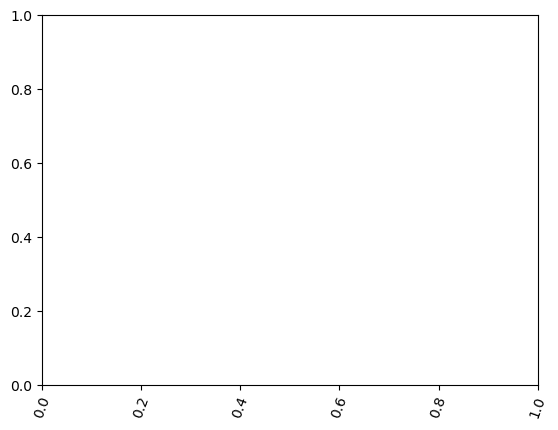

In [57]:
import numpy as np
import pandas as pd
import nltk
import sklearn
import pickle
import string
import fasttext
import contractions
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
%matplotlib inline
plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

Import and inspect data:

In [14]:
# df_test = pd.read_csv("C:\Git\project 2\Data\ATML2023_reviews_test.csv")
# df_train = pd.read_csv("C:\Git\project 2\Data\ATML2023_reviews_train.csv")
# sample_subm = pd.read_csv("C:\Git\project 2\Data\ATML2023_sampleSubmission.csv")

df_test = pd.read_csv("data/ATML2023_reviews_test.csv")
df_train = pd.read_csv("data/ATML2023_reviews_train.csv")
sample_subm = pd.read_csv("data/ATML2023_sampleSubmission.csv")

In [15]:
df_test.head()

Id   product_id           reviewer_id   
0   0  pid_7914467  comment_user_0624561  \
1   1  pid_7678174  comment_user_0444733   
2   2  pid_7685785  comment_user_0291315   
3   3  pid_7001060  comment_user_0612425   
4   4  pid_7071152  comment_user_0642639   

                                                                                           review_body   
0                         I have removed this from my PC. To many issues with it. Would not recommend.  \
1  I got this product to try to fix the cruise control on my car. When it was delivered to my house...   
2  Really cute and comfortable, but as other reviewers have mentioned - they really stink. I put th...   
3  The links are rather large so I have a difficult time cleaning my cast iron grill pan. I cant te...   
4  These look cool but they are not. I bought 4 of them hoping to help keep track of my glasses. Th...   

                                                                    review_title   
0                                                      Better products out there  \
1                                                     Poor Shipping and Function   
2  Really cute and comfortable, but as other reviewers have mentioned - they ...   
3                                           Great! But maybe not for a grill pan   
4                                            Great place to smudge your glasses.   

  language product_category  
0       en            other  
1       en       automotive  
2       en            shoes  
3       en          kitchen  
4       en        drugstore

In [16]:
df_train.head()

Id   product_id           reviewer_id  rating   
0   0  pid_7930618  comment_user_0166666       5  \
1   1  pid_7750075  comment_user_0337482       2   
2   2  pid_7757282  comment_user_0581878       3   
3   3  pid_7006646  comment_user_0562723       3   
4   4  pid_7584741  comment_user_0679072       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

  language     product_category  
0       en              kitchen  
1       en       office_product  
2       en  industrial_supplies  
3       en               beauty  
4       en                 home

In [17]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (164000, 8)
Test: (41000, 7)


There are 164000 observations of 8 covariates in the training set.
For the test set there are 41000 obeservations and only 7 covariates since the rating column was removed (to be predicted).

In [18]:
for col in df_train.columns:
    print(col)

print(df_train.language.unique())


Id
product_id
reviewer_id
rating
review_body
review_title
language
product_category
['en']


The columns of the data frame are presented above. Important features will be <code>review_body, review_title</code> and the <code>rating</code>. Since the only language for the reviews is English, this column does not add any additional information and can be removed.

In [19]:
df_train = df_train.drop('language', axis=1)

In [20]:
for col in df_test.columns:
    print(col)

print(df_test.language.unique())

df_test = df_test.drop('language', axis=1)

Id
product_id
reviewer_id
review_body
review_title
language
product_category
['en']


Checking if there are any missing values: 

In [72]:
for col in df_train.columns:
    print(col, df_train[col].isnull().sum())

for col in df_test.columns:
    print(col, df_test[col].isnull().sum())


Id 0
product_id 0
reviewer_id 0
rating 0
review_body 0
review_title 25
product_category 0
length 0
Id 0
product_id 0
reviewer_id 0
review_body 0
review_title 9
product_category 0


In [75]:
print(f"Percentage missing titles in test: {(df_test.review_title.isnull().sum()/df_train.shape[0])*100}")
print(f"Percentage missing titles in train: {(df_train.review_title.isnull().sum()/df_train.shape[0])*100}")

Percentage missing titles in test: 0.005487804878048781
Percentage missing titles in train: 0.01524390243902439


Some reviews titles are missing (25 in train set, 9 in test set), but nothing dramatic.

In [22]:
df_train.product_category.value_counts()

product_category
home                        14490
apparel                     13110
wireless                    12947
other                       10979
beauty                       9936
drugstore                    9605
kitchen                      8584
toy                          7151
sports                       6751
automotive                   6127
lawn_and_garden              6023
home_improvement             5821
pet_products                 5755
digital_ebook_purchase       5562
pc                           5176
electronics                  5110
office_product               4496
shoes                        4217
grocery                      3912
book                         3103
baby_product                 2615
furniture                    2478
jewelry                      2234
camera                       1752
industrial_supplies          1639
digital_video_download       1117
luggage                      1099
musical_instruments           885
video_games                   6

In [23]:
df_train.rating.value_counts()

rating
4    32945
1    32830
5    32824
3    32747
2    32654
Name: count, dtype: int64

<Axes: title={'center': 'Percentage of Ratings'}, ylabel='count'>

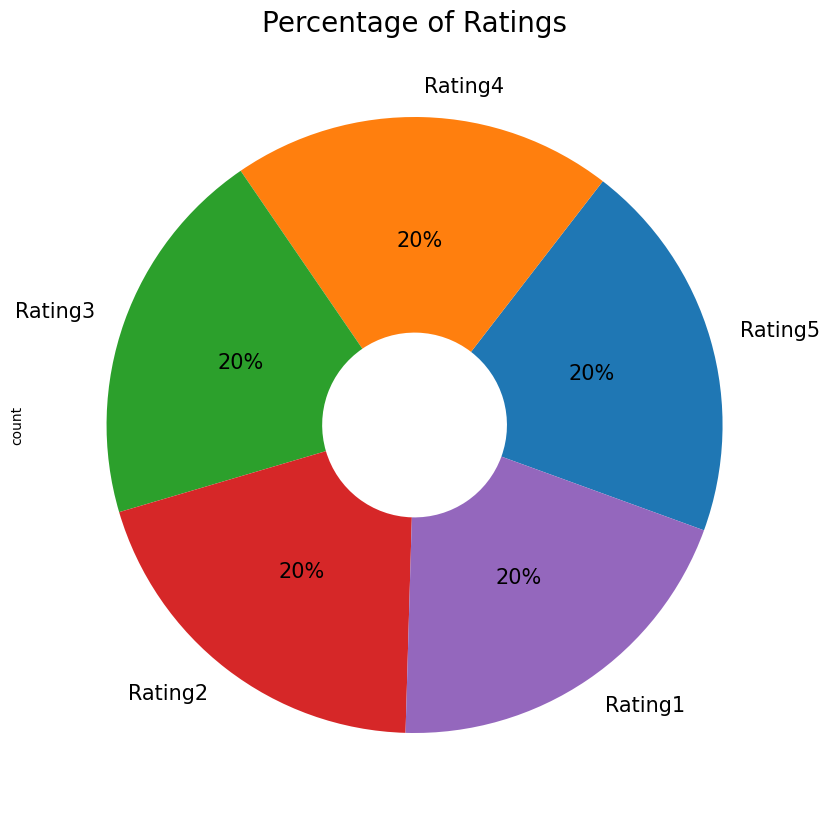

In [24]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Ratings', fontsize=20)
df_train.rating.value_counts().plot(kind='pie', labels=['Rating5', 'Rating4', 'Rating3', 'Rating2', 'Rating1'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

From the output numbers and 'Percentage of Ratings ' plot it can be seen that the data is quite balanced (each rating is almost equally represented).

Next, review body length is inspected.

In [25]:
df_train['length']=df_train['review_body'].apply(len)
df_train.head()

Id   product_id           reviewer_id  rating   
0   0  pid_7930618  comment_user_0166666       5  \
1   1  pid_7750075  comment_user_0337482       2   
2   2  pid_7757282  comment_user_0581878       3   
3   3  pid_7006646  comment_user_0562723       3   
4   4  pid_7584741  comment_user_0679072       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category  length  
0              kitchen      91  
1       office_product     114  
2  industrial_supplies      68  
3               beauty      34  
4                 home      80

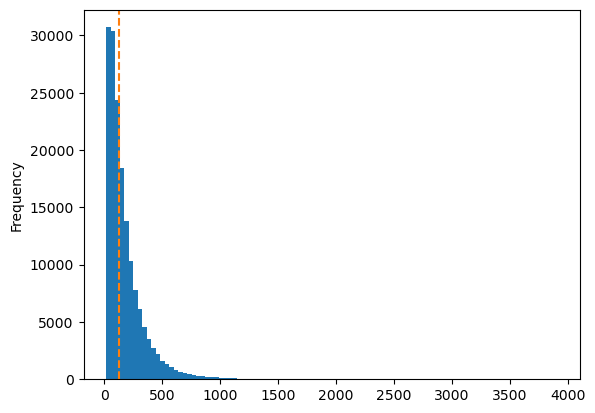

In [84]:
plt.xlabel('length of the review')
df_train['length'].plot(bins=100,kind='hist')
# compute the median
median_length = df_train['length'].median()
plt.axvline(median_length, color='tab:orange', linestyle='--')
plt.show()

In [87]:
print("Review median length:", median_length)

Review median length: 125.0


The distribution is right-skewed, the median line (in dashed orange) is pretty close to 0, indicating half of the reviews are shorter than 125 tokens.

In [27]:
df_train.length.describe()

count    164000.000000
mean        178.681280
std         179.667303
min          15.000000
25%          66.000000
50%         125.000000
75%         228.000000
max        3908.000000
Name: length, dtype: float64

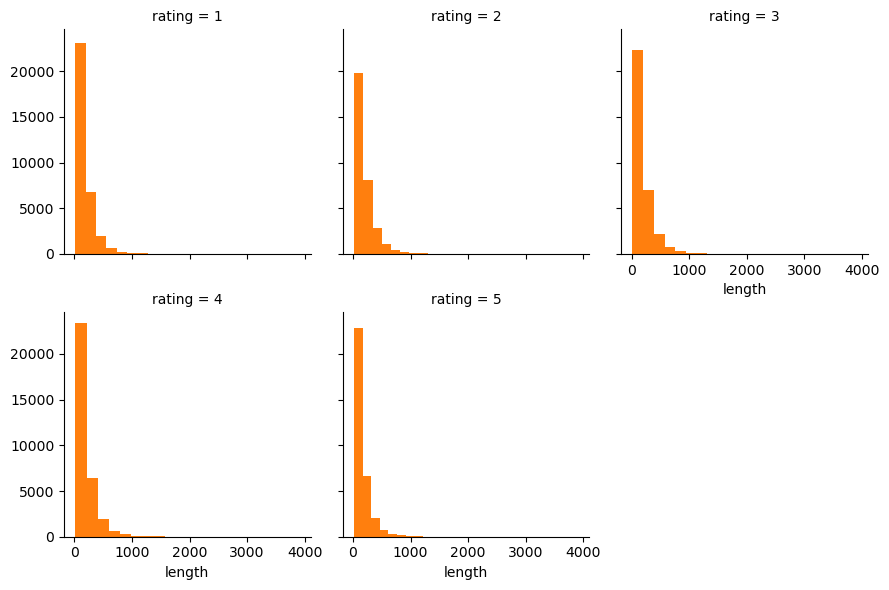

In [88]:
g = sns.FacetGrid(data=df_train,col='rating',col_wrap=3)
g.map(plt.hist,'length',bins=20,color='tab:orange')

The distributions of the lengths of the reviews look very similar for all the ratings.

The following plots show review length based on product category. All distributions are right-skewed. This follows the general trend observed before.

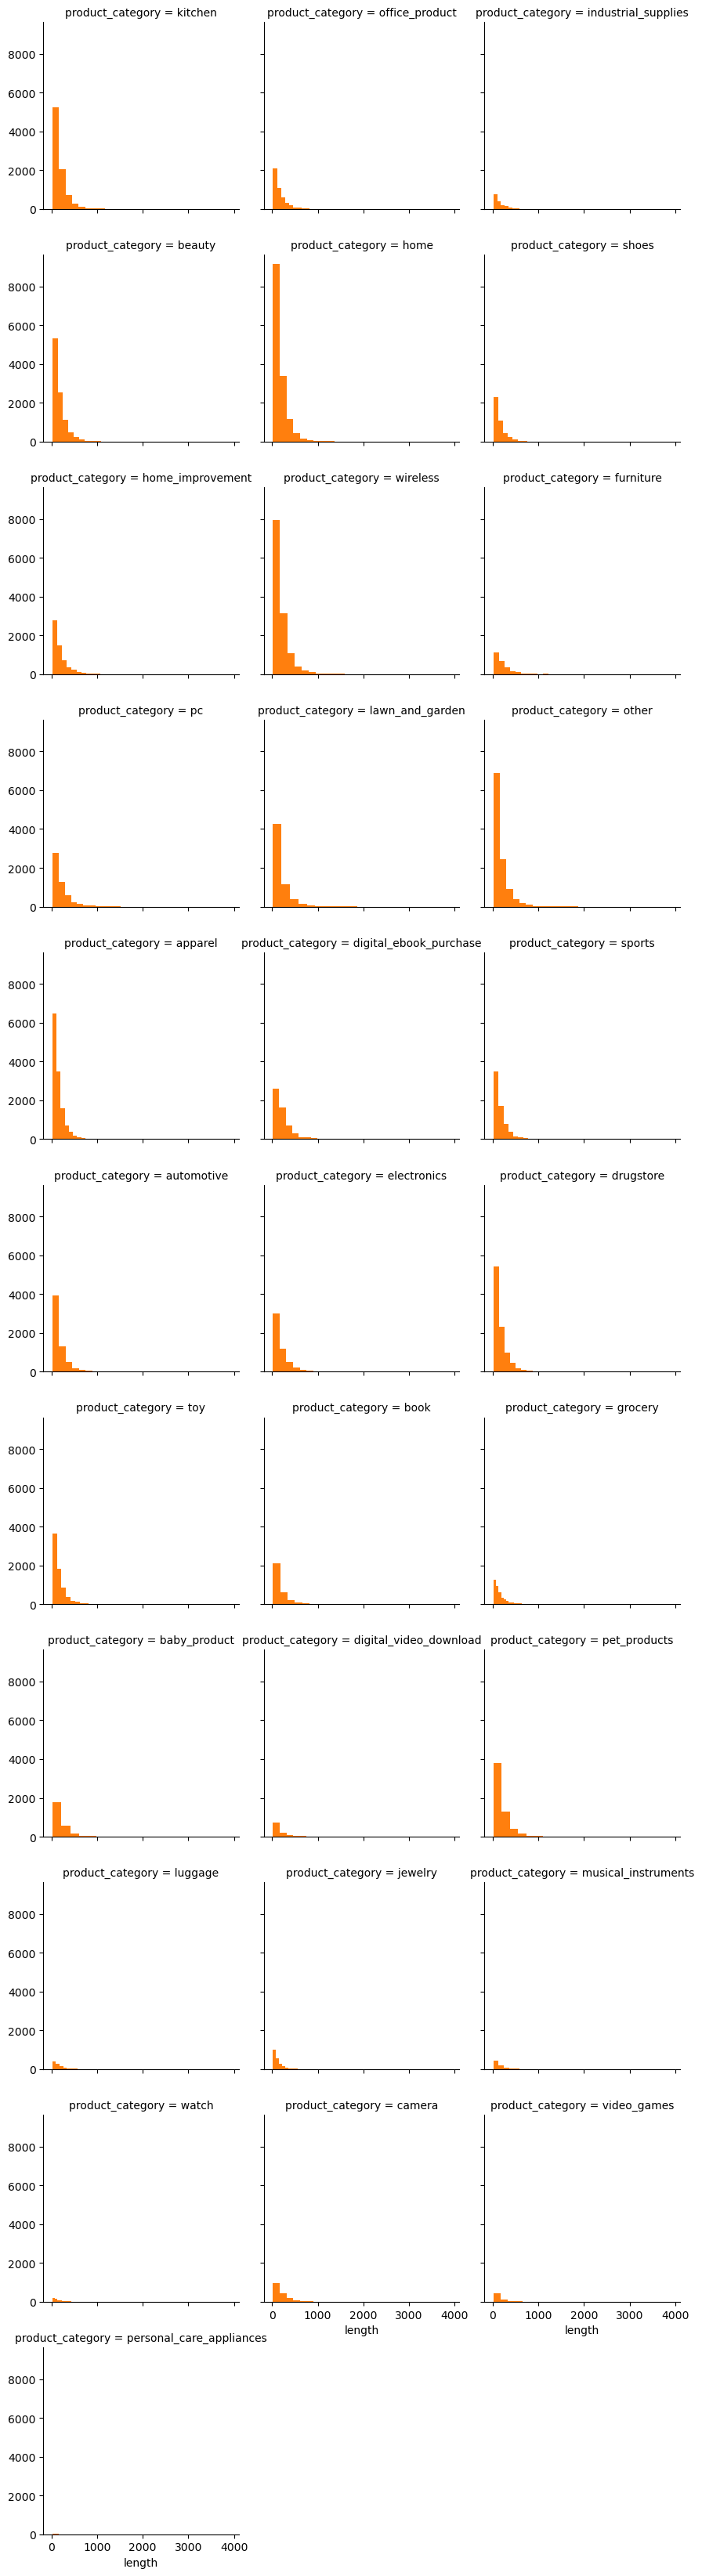

In [89]:
g = sns.FacetGrid(data=df_train,col='product_category',col_wrap=3)
g.map(plt.hist,'length',bins=20,color='tab:orange')

The Top 10 categories based on the number of reviews are plotted below. The top 3 categories are <b>home, apparel and wireless</b>.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'home'),
  Text(1, 0, 'apparel'),
  Text(2, 0, 'wireless'),
  Text(3, 0, 'other'),
  Text(4, 0, 'beauty'),
  Text(5, 0, 'drugstore'),
  Text(6, 0, 'kitchen'),
  Text(7, 0, 'toy'),
  Text(8, 0, 'sports'),
  Text(9, 0, 'automotive')])

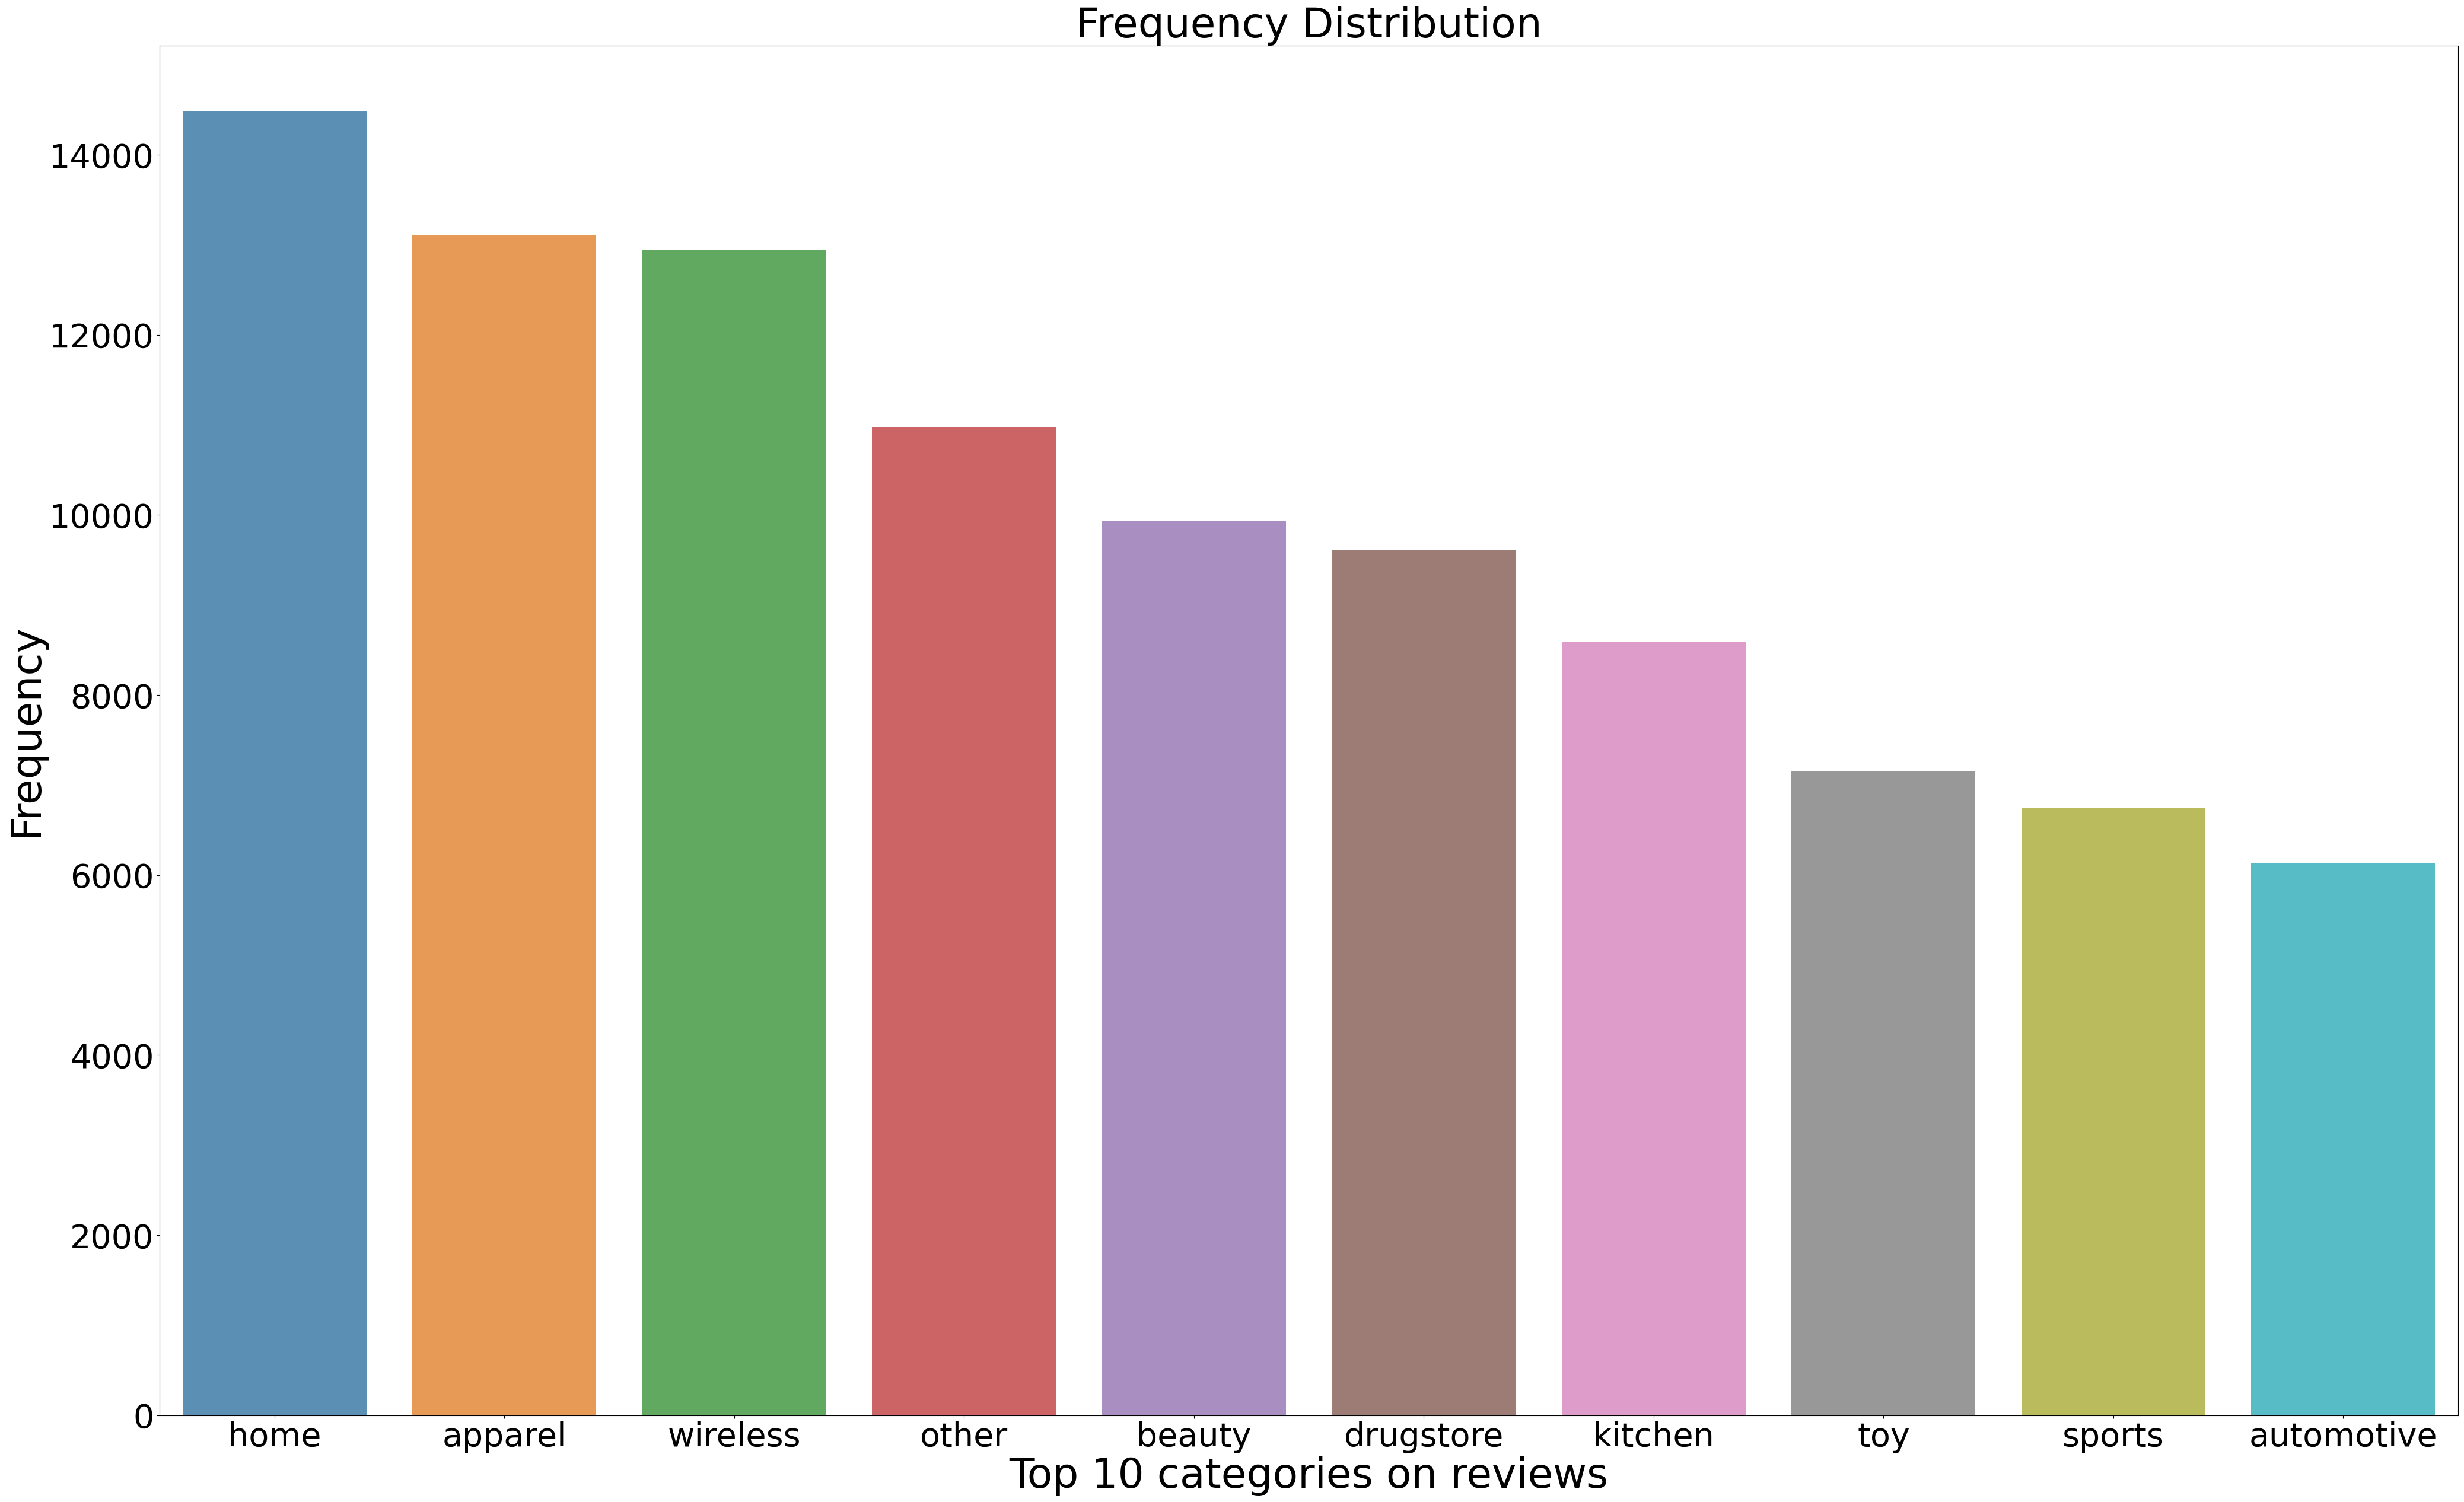

In [30]:
x_rating = df_train.product_category.value_counts()[0:10]
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x = x_rating.index, y = x_rating.values, alpha=0.8)
plt.title("Frequency Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Top 10 categories on reviews', fontsize=50)
plt.xticks(fontsize=40)

#### General feeling: Customer Statisfaction (CSAT) Calculation

CSAT is a metrics that measures how a customer feels about a specific service or product.
It is measured on a scale of 0-5 and can be computed as follows <a href="#ref">(Kim et al.).</a>

Let the number of satisfied customers be denoted by $S$, and the total number of reviews by $R$. Let $C_s$ be the percentage of the satisfied customers. Then, the customer satisfaction formula can be written as:

$$
C_s = \frac{S}{R} \cdot 100
$$

Then, the customers could be subdivided into the following groups:

- Very unsatisfied (0%)
- Unsatisfied (20%)
- Neutral (60%)
- Satisfied (80%)
- Very satisfied (100%)

In [31]:
# Calculate CSAT
csat = len(df_train.loc[df_train['rating']>=4])/len(df_train)
print("Comcast's Customer Satisfaction Score calculated from the dataset is {:.2f}%".format(csat*100))

Comcast's Customer Satisfaction Score calculated from the dataset is 40.10%


Customer satisfaction score of around 40% is not very good. According to the rule of thumb mentioned above, this means the customers are somewhere in between dissatisfied and neutral.

In the next section, reasons for customer dissatisfaction are explored.

### Data Pre-Processing

Next, the data will be properly preprocessed. The column <code>review_body</code> is merged with <code>review_title</code> to get the most information.

Next, contractions are removed. Examples of contractions are should have/should've, do not/don't etc. The expanded words are tokenized together.

In [90]:
df_train['review_full'] = df_train['review_title'] + ' ' + df_train['review_body']
df_test['review_full'] = df_test['review_title'] + ' ' + df_test['review_body']

In [91]:
rws_train = df_train.loc[:,['rating', 'review_body', 'review_title', 'product_category','review_full']]
rws_test = df_test.loc[:,['review_body','review_title','review_full']]
rws_train.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category   
0              kitchen  \
1       office_product   
2  industrial_supplies   
3               beauty   
4                 home   

                                                                                           review_full  
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...  
2                    Don't bother 12 dollars for 16 days of use? I thought this came with more then 1.  
3                                                              Nice Using for crafts - not as make-up.  
4  ... for what I wanted but didn't absorb craft paint like I thought they Worked for what I wanted...

Since there are only 25 missing values, they can be deleted.

In [92]:
rws_train = rws_train[rws_train['review_full'].notnull()]

In [93]:
rws_train['no_contract'] = rws_train['review_full'].apply(lambda x: [contractions.fix(word) for word in x.split()])

rws_train.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category   
0              kitchen  \
1       office_product   
2  industrial_supplies   
3               beauty   
4                 home   

                                                                                           review_full   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                    Don't bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but didn't absorb craft paint like I thought they Worked for what I wanted...   

                                                                                           no_contract  
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig., Has, kept, coffee,...  
1  [Not, adjustable, The, finger, hole, is, small., Not, suitable, for, a, larger, man., Does, not,...  
2  [Do not, bother, 12, dollars, for, 16, days, of, use?, I, thought, this, came, with, more, then,...  
3                                                     [Nice, Using, for, crafts, -, not, as, make-up.]  
4  [..., for, what, I, wanted, but, did not, absorb, craft, paint, like, I, thought, they, Worked, ...

Splitting the tokenized words again:

In [94]:
rws_train['review_body_str'] = [' '.join(map(str, l)) for l in rws_train['no_contract']]
rws_train.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category   
0              kitchen  \
1       office_product   
2  industrial_supplies   
3               beauty   
4                 home   

                                                                                           review_full   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                    Don't bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but didn't absorb craft paint like I thought they Worked for what I wanted...   

                                                                                           no_contract   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig., Has, kept, coffee,...  \
1  [Not, adjustable, The, finger, hole, is, small., Not, suitable, for, a, larger, man., Does, not,...   
2  [Do not, bother, 12, dollars, for, 16, days, of, use?, I, thought, this, came, with, more, then,...   
3                                                     [Nice, Using, for, crafts, -, not, as, make-up.]   
4  [..., for, what, I, wanted, but, did not, absorb, craft, paint, like, I, thought, they, Worked, ...   

                                                                                       review_body_str  
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...  
2                   Do not bother 12 dollars for 16 days of use? I thought this came with more then 1.  
3                                                              Nice Using for crafts - not as make-up.  
4  ... for what I wanted but did not absorb craft paint like I thought they Worked for what I wante...

### Tokenization

Tokenization is a part of text normalization. Its goal is to separate the words from running text, for example recognizing "I'm" as two words: "I" and "am" <a href="#ref">(Jurafsky et al.)</a>

In [95]:
rws_train['tokenized'] = rws_train['review_body_str'].apply(word_tokenize)
rws_train.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category   
0              kitchen  \
1       office_product   
2  industrial_supplies   
3               beauty   
4                 home   

                                                                                           review_full   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                    Don't bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but didn't absorb craft paint like I thought they Worked for what I wanted...   

                                                                                           no_contract   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig., Has, kept, coffee,...  \
1  [Not, adjustable, The, finger, hole, is, small., Not, suitable, for, a, larger, man., Does, not,...   
2  [Do not, bother, 12, dollars, for, 16, days, of, use?, I, thought, this, came, with, more, then,...   
3                                                     [Nice, Using, for, crafts, -, not, as, make-up.]   
4  [..., for, what, I, wanted, but, did not, absorb, craft, paint, like, I, thought, they, Worked, ...   

                                                                                       review_body_str   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                   Do not bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but did not absorb craft paint like I thought they Worked for what I wante...   

                                                                                             tokenized  
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig, ., Has, kept, coffe...  
1  [Not, adjustable, The, finger, hole, is, small, ., Not, suitable, for, a, larger, man, ., Does, ...  
2  [Do, not, bother, 12, dollars, for, 16, days, of, use, ?, I, thought, this, came, with, more, th...  
3                                                   [Nice, Using, for, crafts, -, not, as, make-up, .]  
4  [..., for, what, I, wanted, but, did, not, absorb, craft, paint, like, I, thought, they, Worked,...

Next, all characters are converted to lowercase.

In [96]:
rws_train['lower'] = rws_train['tokenized'].apply(lambda x: [word.lower() for word in x])
rws_train.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category   
0              kitchen  \
1       office_product   
2  industrial_supplies   
3               beauty   
4                 home   

                                                                                           review_full   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                    Don't bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but didn't absorb craft paint like I thought they Worked for what I wanted...   

                                                                                           no_contract   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig., Has, kept, coffee,...  \
1  [Not, adjustable, The, finger, hole, is, small., Not, suitable, for, a, larger, man., Does, not,...   
2  [Do not, bother, 12, dollars, for, 16, days, of, use?, I, thought, this, came, with, more, then,...   
3                                                     [Nice, Using, for, crafts, -, not, as, make-up.]   
4  [..., for, what, I, wanted, but, did not, absorb, craft, paint, like, I, thought, they, Worked, ...   

                                                                                       review_body_str   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                   Do not bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but did not absorb craft paint like I thought they Worked for what I wante...   

                                                                                             tokenized   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig, ., Has, kept, coffe...  \
1  [Not, adjustable, The, finger, hole, is, small, ., Not, suitable, for, a, larger, man, ., Does, ...   
2  [Do, not, bother, 12, dollars, for, 16, days, of, use, ?, I, thought, this, came, with, more, th...   
3                                                   [Nice, Using, for, crafts, -, not, as, make-up, .]   
4  [..., for, what, I, wanted, but, did, not, absorb, craft, paint, like, I, thought, they, Worked,...   

                                                                                                 lower  
0  [keep

The punctuations are removed.

In [97]:
punc = string.punctuation
rws_train['no_punc'] = rws_train['lower'].apply(lambda x: [word for word in x if word not in punc])
rws_train.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category   
0              kitchen  \
1       office_product   
2  industrial_supplies   
3               beauty   
4                 home   

                                                                                           review_full   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                    Don't bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but didn't absorb craft paint like I thought they Worked for what I wanted...   

                                                                                           no_contract   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig., Has, kept, coffee,...  \
1  [Not, adjustable, The, finger, hole, is, small., Not, suitable, for, a, larger, man., Does, not,...   
2  [Do not, bother, 12, dollars, for, 16, days, of, use?, I, thought, this, came, with, more, then,...   
3                                                     [Nice, Using, for, crafts, -, not, as, make-up.]   
4  [..., for, what, I, wanted, but, did not, absorb, craft, paint, like, I, thought, they, Worked, ...   

                                                                                       review_body_str   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                   Do not bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but did not absorb craft paint like I thought they Worked for what I wante...   

                                                                                             tokenized   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig, ., Has, kept, coffe...  \
1  [Not, adjustable, The, finger, hole, is, small, ., Not, suitable, for, a, larger, man, ., Does, ...   
2  [Do, not, bother, 12, dollars, for, 16, days, of, use, ?, I, thought, this, came, with, more, th...   
3                                                   [Nice, Using, for, crafts, -, not, as, make-up, .]   
4  [..., for, what, I, wanted, but, did, not, absorb, craft, paint, like, I, thought, they, Worked,...   

                                                                                                 lower   
0  [kee

In the English language common stopwords include “you, he, she, in, a, has, are, etc.” They do not carry information of interest and are thus removed.

In [98]:
stop_words = set(stopwords.words('english'))
rws_train['stopwords_removed'] = rws_train['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
rws_train.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category   
0              kitchen  \
1       office_product   
2  industrial_supplies   
3               beauty   
4                 home   

                                                                                           review_full   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                    Don't bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but didn't absorb craft paint like I thought they Worked for what I wanted...   

                                                                                           no_contract   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig., Has, kept, coffee,...  \
1  [Not, adjustable, The, finger, hole, is, small., Not, suitable, for, a, larger, man., Does, not,...   
2  [Do not, bother, 12, dollars, for, 16, days, of, use?, I, thought, this, came, with, more, then,...   
3                                                     [Nice, Using, for, crafts, -, not, as, make-up.]   
4  [..., for, what, I, wanted, but, did not, absorb, craft, paint, like, I, thought, they, Worked, ...   

                                                                                       review_body_str   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                   Do not bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but did not absorb craft paint like I thought they Worked for what I wante...   

                                                                                             tokenized   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig, ., Has, kept, coffe...  \
1  [Not, adjustable, The, finger, hole, is, small, ., Not, suitable, for, a, larger, man, ., Does, ...   
2  [Do, not, bother, 12, dollars, for, 16, days, of, use, ?, I, thought, this, came, with, more, th...   
3                                                   [Nice, Using, for, crafts, -, not, as, make-up, .]   
4  [..., for, what, I, wanted, but, did, not, absorb, craft, paint, like, I, thought, they, Worked,...   

                                                                                                 lower   
0  [kee

Next, words are tagged using <code>nltk</code> words tag. This process has as goal to classify words into their parts of speech and label them accordingly. This is known as part-of-speech tagging, POS-tagging, or simply tagging. This will be further used for lemmatization.

In [99]:
rws_train['pos_tags'] = rws_train['stopwords_removed'].apply(nltk.tag.pos_tag)
rws_train.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category   
0              kitchen  \
1       office_product   
2  industrial_supplies   
3               beauty   
4                 home   

                                                                                           review_full   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                    Don't bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but didn't absorb craft paint like I thought they Worked for what I wanted...   

                                                                                           no_contract   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig., Has, kept, coffee,...  \
1  [Not, adjustable, The, finger, hole, is, small., Not, suitable, for, a, larger, man., Does, not,...   
2  [Do not, bother, 12, dollars, for, 16, days, of, use?, I, thought, this, came, with, more, then,...   
3                                                     [Nice, Using, for, crafts, -, not, as, make-up.]   
4  [..., for, what, I, wanted, but, did not, absorb, craft, paint, like, I, thought, they, Worked, ...   

                                                                                       review_body_str   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                   Do not bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but did not absorb craft paint like I thought they Worked for what I wante...   

                                                                                             tokenized   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig, ., Has, kept, coffe...  \
1  [Not, adjustable, The, finger, hole, is, small, ., Not, suitable, for, a, larger, man, ., Does, ...   
2  [Do, not, bother, 12, dollars, for, 16, days, of, use, ?, I, thought, this, came, with, more, th...   
3                                                   [Nice, Using, for, crafts, -, not, as, make-up, .]   
4  [..., for, what, I, wanted, but, did, not, absorb, craft, paint, like, I, thought, they, Worked,...   

                                                                                                 lower   
0  [kee

Lemmatization is another part of text normalization. Here, the task is to determine whether two words have the same roots, despite their surface differences. For example, the words "sang", "sings", "sung" are all forms of the verb "sing" <a href="#ref">(Jurasky et al.)</a>

The <code>nltk</code> word lemmatizer needs the parts of speech tags to be converted to wordnet’s format. Below is a function which converts the tags into word classes. This function is used by <code>nltk</code> lemmatizer.

In [100]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
rws_train['wordnet_pos'] = rws_train['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
rws_train.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category   
0              kitchen  \
1       office_product   
2  industrial_supplies   
3               beauty   
4                 home   

                                                                                           review_full   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                    Don't bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but didn't absorb craft paint like I thought they Worked for what I wanted...   

                                                                                           no_contract   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig., Has, kept, coffee,...  \
1  [Not, adjustable, The, finger, hole, is, small., Not, suitable, for, a, larger, man., Does, not,...   
2  [Do not, bother, 12, dollars, for, 16, days, of, use?, I, thought, this, came, with, more, then,...   
3                                                     [Nice, Using, for, crafts, -, not, as, make-up.]   
4  [..., for, what, I, wanted, but, did not, absorb, craft, paint, like, I, thought, they, Worked, ...   

                                                                                       review_body_str   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                   Do not bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but did not absorb craft paint like I thought they Worked for what I wante...   

                                                                                             tokenized   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig, ., Has, kept, coffe...  \
1  [Not, adjustable, The, finger, hole, is, small, ., Not, suitable, for, a, larger, man, ., Does, ...   
2  [Do, not, bother, 12, dollars, for, 16, days, of, use, ?, I, thought, this, came, with, more, th...   
3                                                   [Nice, Using, for, crafts, -, not, as, make-up, .]   
4  [..., for, what, I, wanted, but, did, not, absorb, craft, paint, like, I, thought, they, Worked,...   

                                                                                                 lower   
0  [kee

Now, the NLTK word lemmatizer is applied to the dataset. Notice, the lemmatizer function requires two parameters: the word and its tag (in wordnet form).

In [101]:
wnl = WordNetLemmatizer()
rws_train['lemmatized'] = rws_train['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
rws_train.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                           review_body   
0          Nice addition to my new kurig. Has kept coffee warm for 8 hours. Definitely worth the money  \
1  The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...   
2                                 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                                   Using for crafts - not as make-up.   
4                     Worked for what I wanted but didn't absorb craft paint like I thought they would   

                                                              review_title   
0                                         Keeps coffee hot for a long time  \
1                                                           Not adjustable   
2                                                             Don't bother   
3                                                                     Nice   
4  ... for what I wanted but didn't absorb craft paint like I thought they   

      product_category   
0              kitchen  \
1       office_product   
2  industrial_supplies   
3               beauty   
4                 home   

                                                                                           review_full   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                    Don't bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but didn't absorb craft paint like I thought they Worked for what I wanted...   

                                                                                           no_contract   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig., Has, kept, coffee,...  \
1  [Not, adjustable, The, finger, hole, is, small., Not, suitable, for, a, larger, man., Does, not,...   
2  [Do not, bother, 12, dollars, for, 16, days, of, use?, I, thought, this, came, with, more, then,...   
3                                                     [Nice, Using, for, crafts, -, not, as, make-up.]   
4  [..., for, what, I, wanted, but, did not, absorb, craft, paint, like, I, thought, they, Worked, ...   

                                                                                       review_body_str   
0  Keeps coffee hot for a long time Nice addition to my new kurig. Has kept coffee warm for 8 hours...  \
1  Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...   
2                   Do not bother 12 dollars for 16 days of use? I thought this came with more then 1.   
3                                                              Nice Using for crafts - not as make-up.   
4  ... for what I wanted but did not absorb craft paint like I thought they Worked for what I wante...   

                                                                                             tokenized   
0  [Keeps, coffee, hot, for, a, long, time, Nice, addition, to, my, new, kurig, ., Has, kept, coffe...  \
1  [Not, adjustable, The, finger, hole, is, small, ., Not, suitable, for, a, larger, man, ., Does, ...   
2  [Do, not, bother, 12, dollars, for, 16, days, of, use, ?, I, thought, this, came, with, more, th...   
3                                                   [Nice, Using, for, crafts, -, not, as, make-up, .]   
4  [..., for, what, I, wanted, but, did, not, absorb, craft, paint, like, I, thought, they, Worked,...   

                                                                                                 lower   
0  [kee

Save the data in a new csv file:

In [42]:
# rws_train = pd.read_csv("data/rws_train_scrape_clean.csv")

In [43]:
#rws_train.to_csv('data/rws_train_scrape_clean.csv')

#rws.to_csv('indeed_scrape_clean.csv')
#with open('indeed_scrape_clean.pkl', 'rb') as pickle_file:
#    df = pickle.load(pickle_file)

Next, a new dataset is created which is a subset of the full one, with two columns: rating and lemmatized words.

In [102]:
rws_train.head()
df = rws_train[['rating', 'lemmatized']]
df.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                            lemmatized  
0  [keep, coffee, hot, long, time, nice, addition, new, kurig, keep, coffee, warm, 8, hour, definit...  
1               [adjustable, finger, hole, small, suitable, large, man, adjust, would, recommend, buy]  
2                                                   [bother, 12, dollar, 16, day, use, think, come, 1]  
3                                                                          [nice, use, craft, make-up]  
4  [..., want, absorb, craft, paint, like, thought, work, wanted, absorb, craft, paint, like, thoug...

### Sentiment Analysis

An important aspect of dealing with customer reviews is to understand their general feeling about the website. Sentiment analysis is the process of determining the writer’s attitude or opinion ranging from -1 (negative attitude) to 1 (positive attitude). The <code>TextBlob</code> library will be used to analyze the sentiments. First, the words are joined back again.

In [103]:
df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemmatized']]
df.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                            lemmatized   
0  [keep, coffee, hot, long, time, nice, addition, new, kurig, keep, coffee, warm, 8, hour, definit...  \
1               [adjustable, finger, hole, small, suitable, large, man, adjust, would, recommend, buy]   
2                                                   [bother, 12, dollar, 16, day, use, think, come, 1]   
3                                                                          [nice, use, craft, make-up]   
4  [..., want, absorb, craft, paint, like, thought, work, wanted, absorb, craft, paint, like, thoug...   

                                                                                          lemma_str  
0  keep coffee hot long time nice addition new kurig keep coffee warm 8 hour definitely worth money  
1                        adjustable finger hole small suitable large man adjust would recommend buy  
2                                                          bother 12 dollar 16 day use think come 1  
3                                                                            nice use craft make-up  
4        ... want absorb craft paint like thought work wanted absorb craft paint like thought would

Computing the sentiments:

In [104]:
df['sentiment'] = df['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                            lemmatized   
0  [keep, coffee, hot, long, time, nice, addition, new, kurig, keep, coffee, warm, 8, hour, definit...  \
1               [adjustable, finger, hole, small, suitable, large, man, adjust, would, recommend, buy]   
2                                                   [bother, 12, dollar, 16, day, use, think, come, 1]   
3                                                                          [nice, use, craft, make-up]   
4  [..., want, absorb, craft, paint, like, thought, work, wanted, absorb, craft, paint, like, thoug...   

                                                                                          lemma_str   
0  keep coffee hot long time nice addition new kurig keep coffee warm 8 hour definitely worth money  \
1                        adjustable finger hole small suitable large man adjust would recommend buy   
2                                                          bother 12 dollar 16 day use think come 1   
3                                                                            nice use craft make-up   
4        ... want absorb craft paint like thought work wanted absorb craft paint like thought would   

   sentiment  
0   0.306061  
1   0.171429  
2   0.000000  
3   0.600000  
4   0.000000

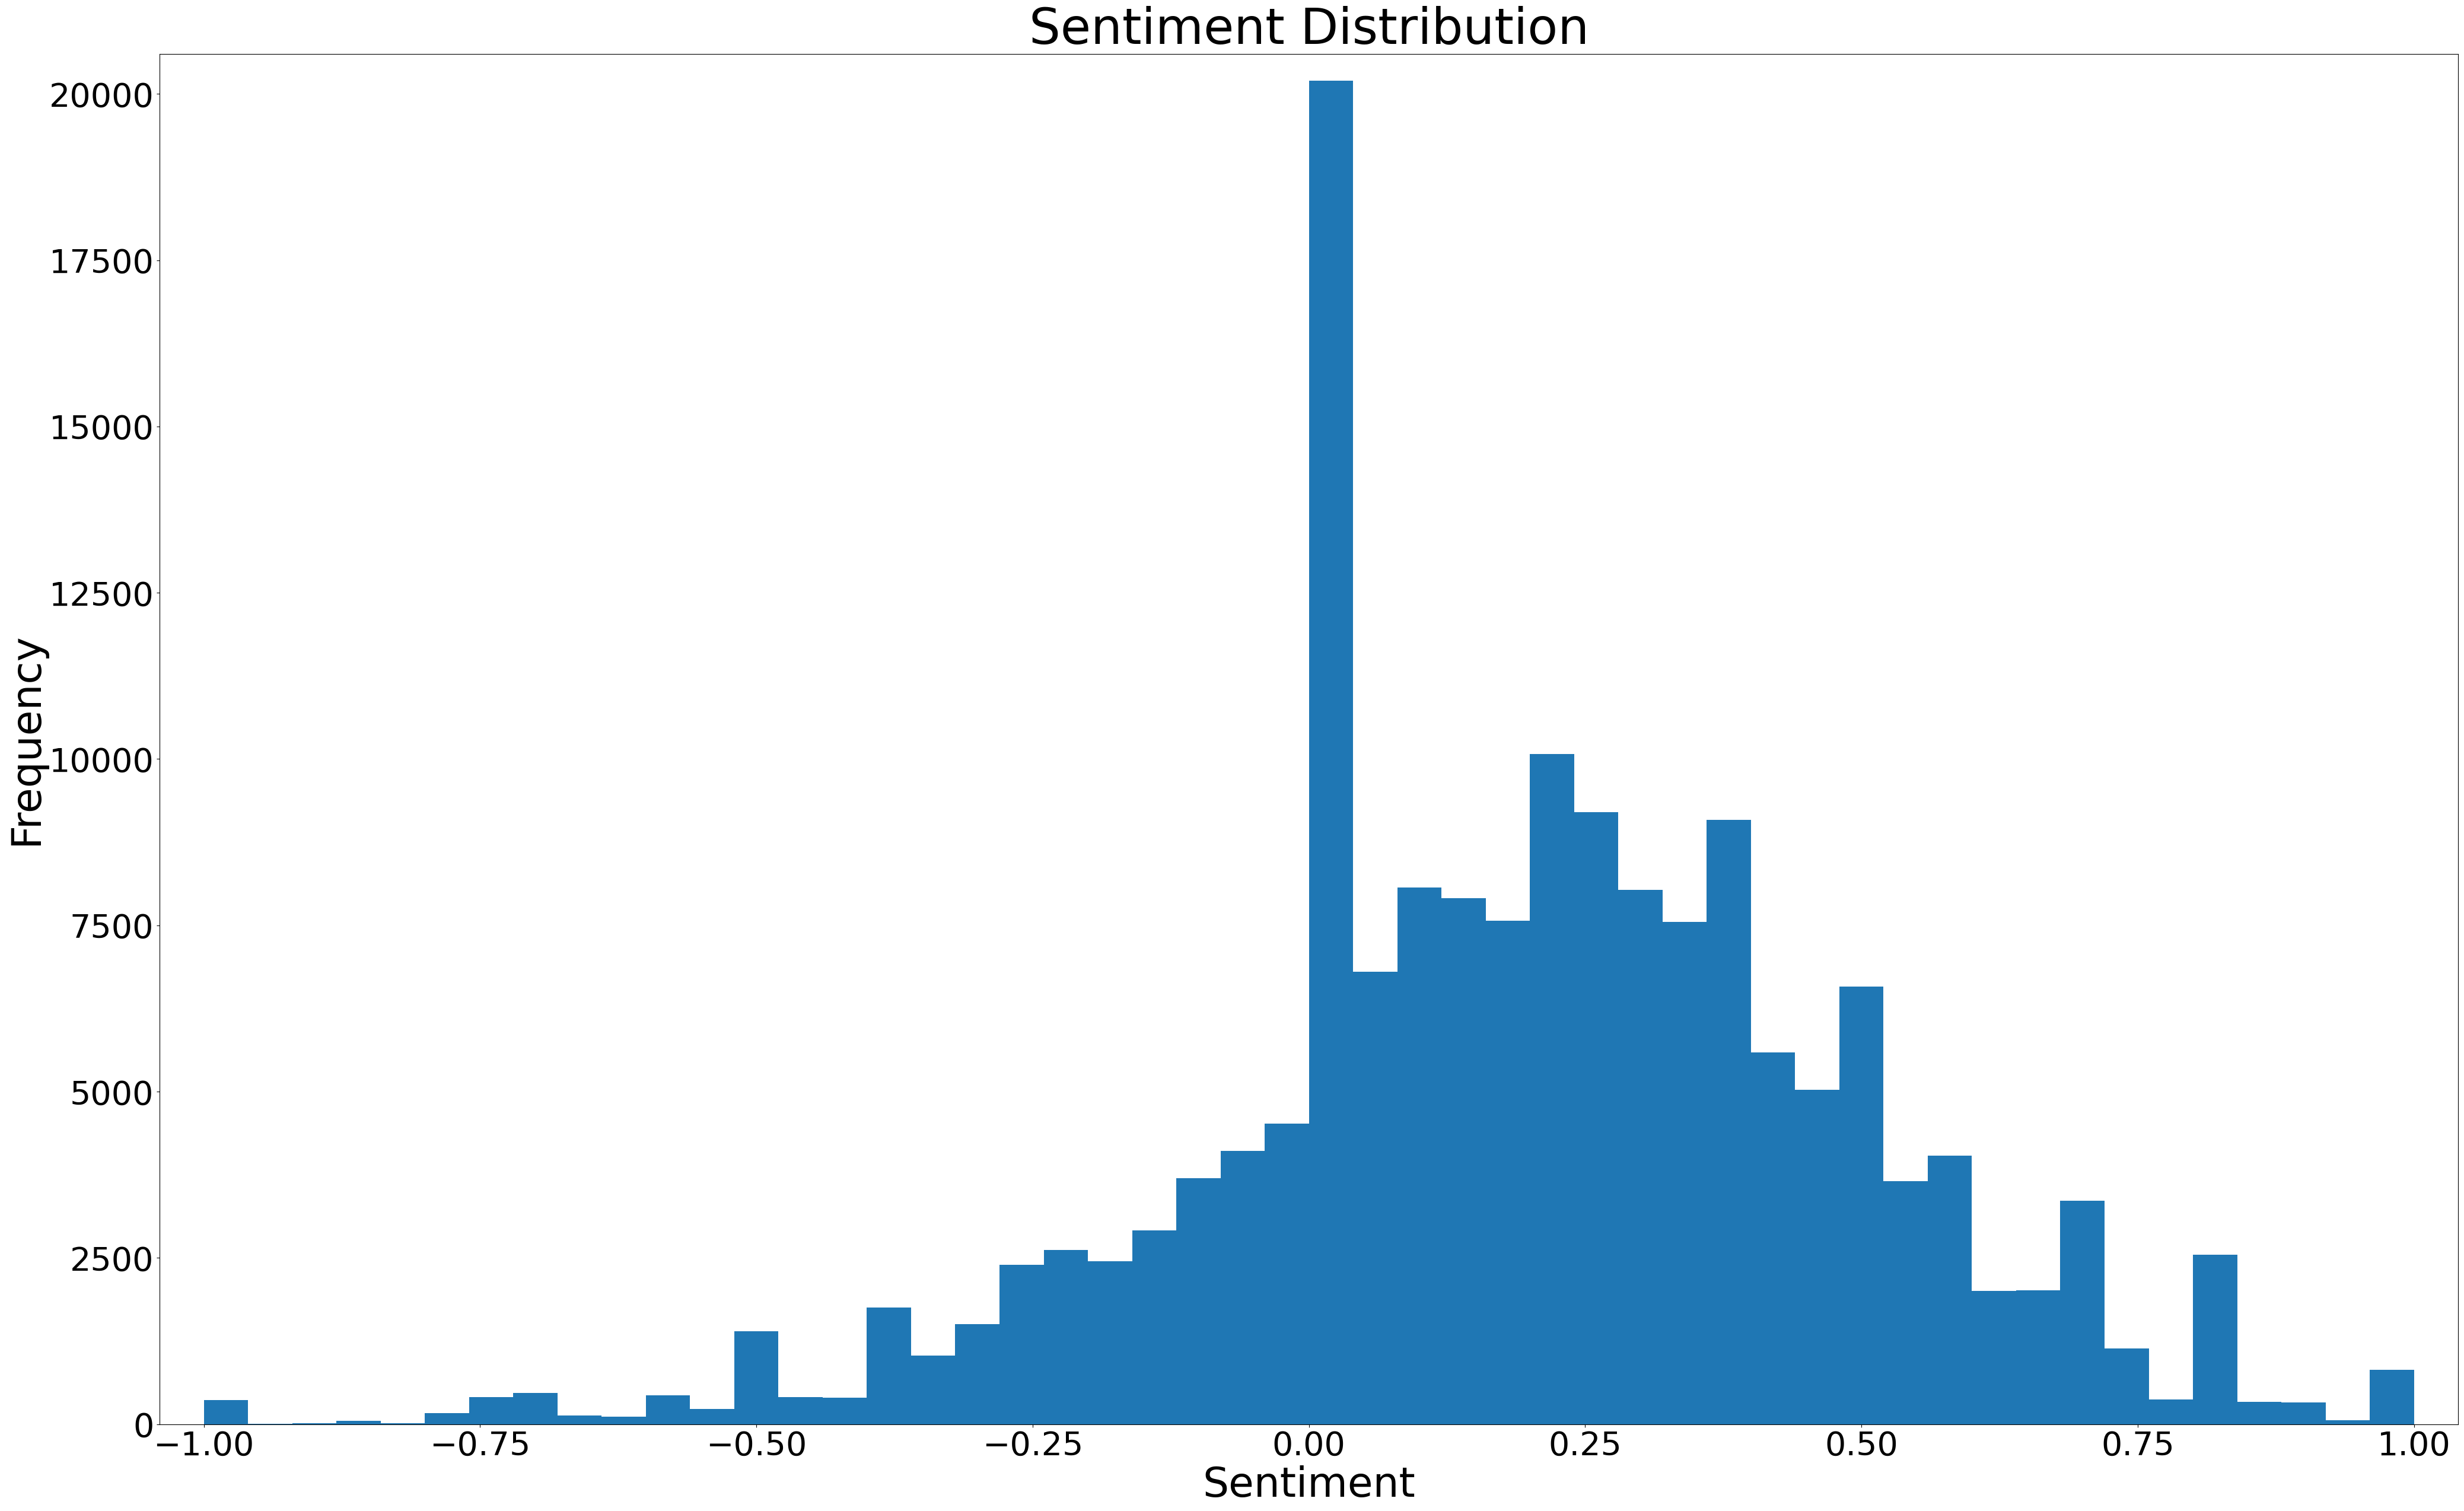

In [105]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

The plot above represents a histogram of sentiment analysis. Roughly 2/3 of the reviews have a positively-derived sentiment rating. However, when comparing with the ratings distribution, which is almost perfectly uniform, the results seem contradictory. This could be due to the fact that rather positive comments/wordings are in ratings 5,4,3 but not so much (if at all) in 1 or 2.

There are also clearly negative reviews, i.e. with a sentiment of -1. Interestingly, there is an excess of zeros in the data. This could be due to words being ambigous or used in a context where one cannot tell whether the client's impression is good or bad.


An additional feature is created called <code>word_count</code>, to determine the number of words per review .

In [106]:
df['word_count'] = df['lemmatized'].apply(lambda x: len(str(x).split()))
df['review_len'] = df['lemma_str'].astype(str).apply(len)
df.head()

rating   
0       5  \
1       2   
2       3   
3       3   
4       4   

                                                                                            lemmatized   
0  [keep, coffee, hot, long, time, nice, addition, new, kurig, keep, coffee, warm, 8, hour, definit...  \
1               [adjustable, finger, hole, small, suitable, large, man, adjust, would, recommend, buy]   
2                                                   [bother, 12, dollar, 16, day, use, think, come, 1]   
3                                                                          [nice, use, craft, make-up]   
4  [..., want, absorb, craft, paint, like, thought, work, wanted, absorb, craft, paint, like, thoug...   

                                                                                          lemma_str   
0  keep coffee hot long time nice addition new kurig keep coffee warm 8 hour definitely worth money  \
1                        adjustable finger hole small suitable large man adjust would recommend buy   
2                                                          bother 12 dollar 16 day use think come 1   
3                                                                            nice use craft make-up   
4        ... want absorb craft paint like thought work wanted absorb craft paint like thought would   

   sentiment  word_count  review_len  
0   0.306061          17          96  
1   0.171429          11          74  
2   0.000000           9          40  
3   0.600000           4          22  
4   0.000000          15          90

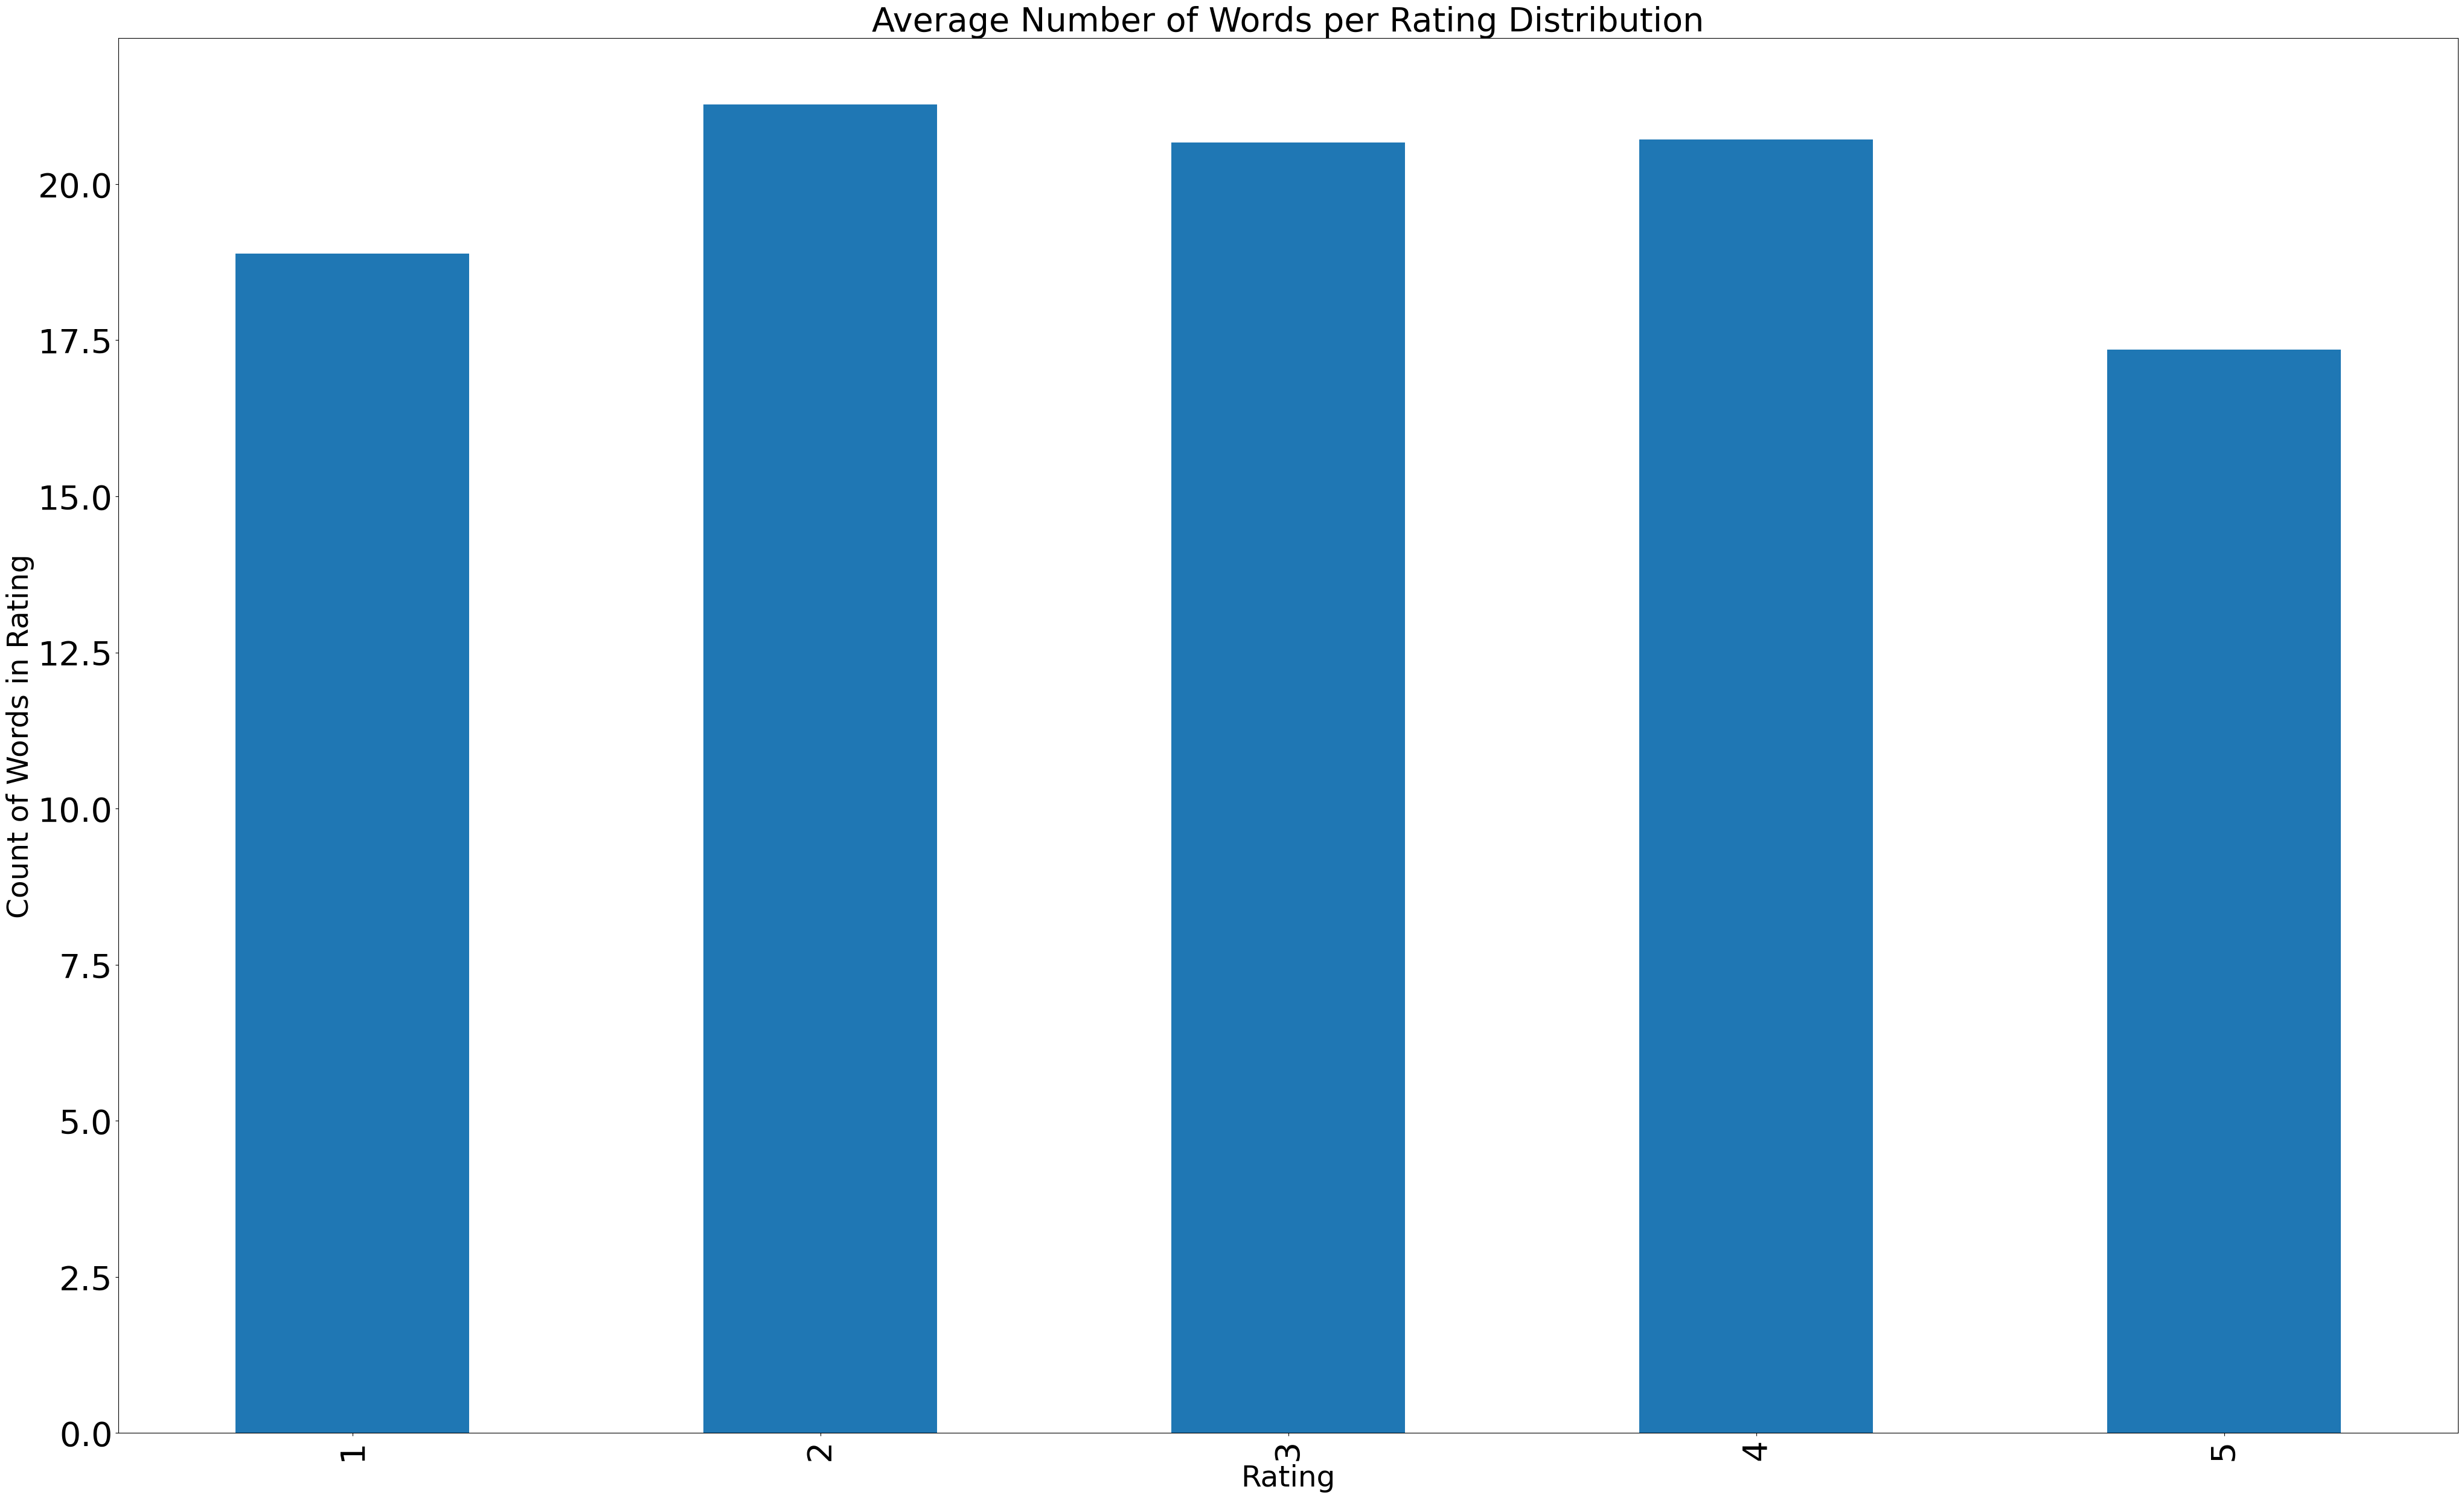

In [107]:
word_avg = df.groupby('rating')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Rating Distribution', fontsize=40)
plt.show()

Rating 2 has the most words on average. Rating 5 has the least; customers tend to write shorter reviews when they are satisfied. A distribution for letters was also plotted. However, since it looks similar to that for words, it has not been depicted.

It seems disgruntled customers typically provide significantly more detail in their reviews. This result is not uncommon as humans have a tendency to complain in detail but praise in brief. This can be further confirmed by examining the correlation matrix below. Both ratings and sentiment have a negative correlation with “review_len” and “word_count”. This could explain the inverse relationship;  the overall rating and sentiment decreases as the count of words per review increases. The correlation is small, but nevertheless negative. 

<Axes: >

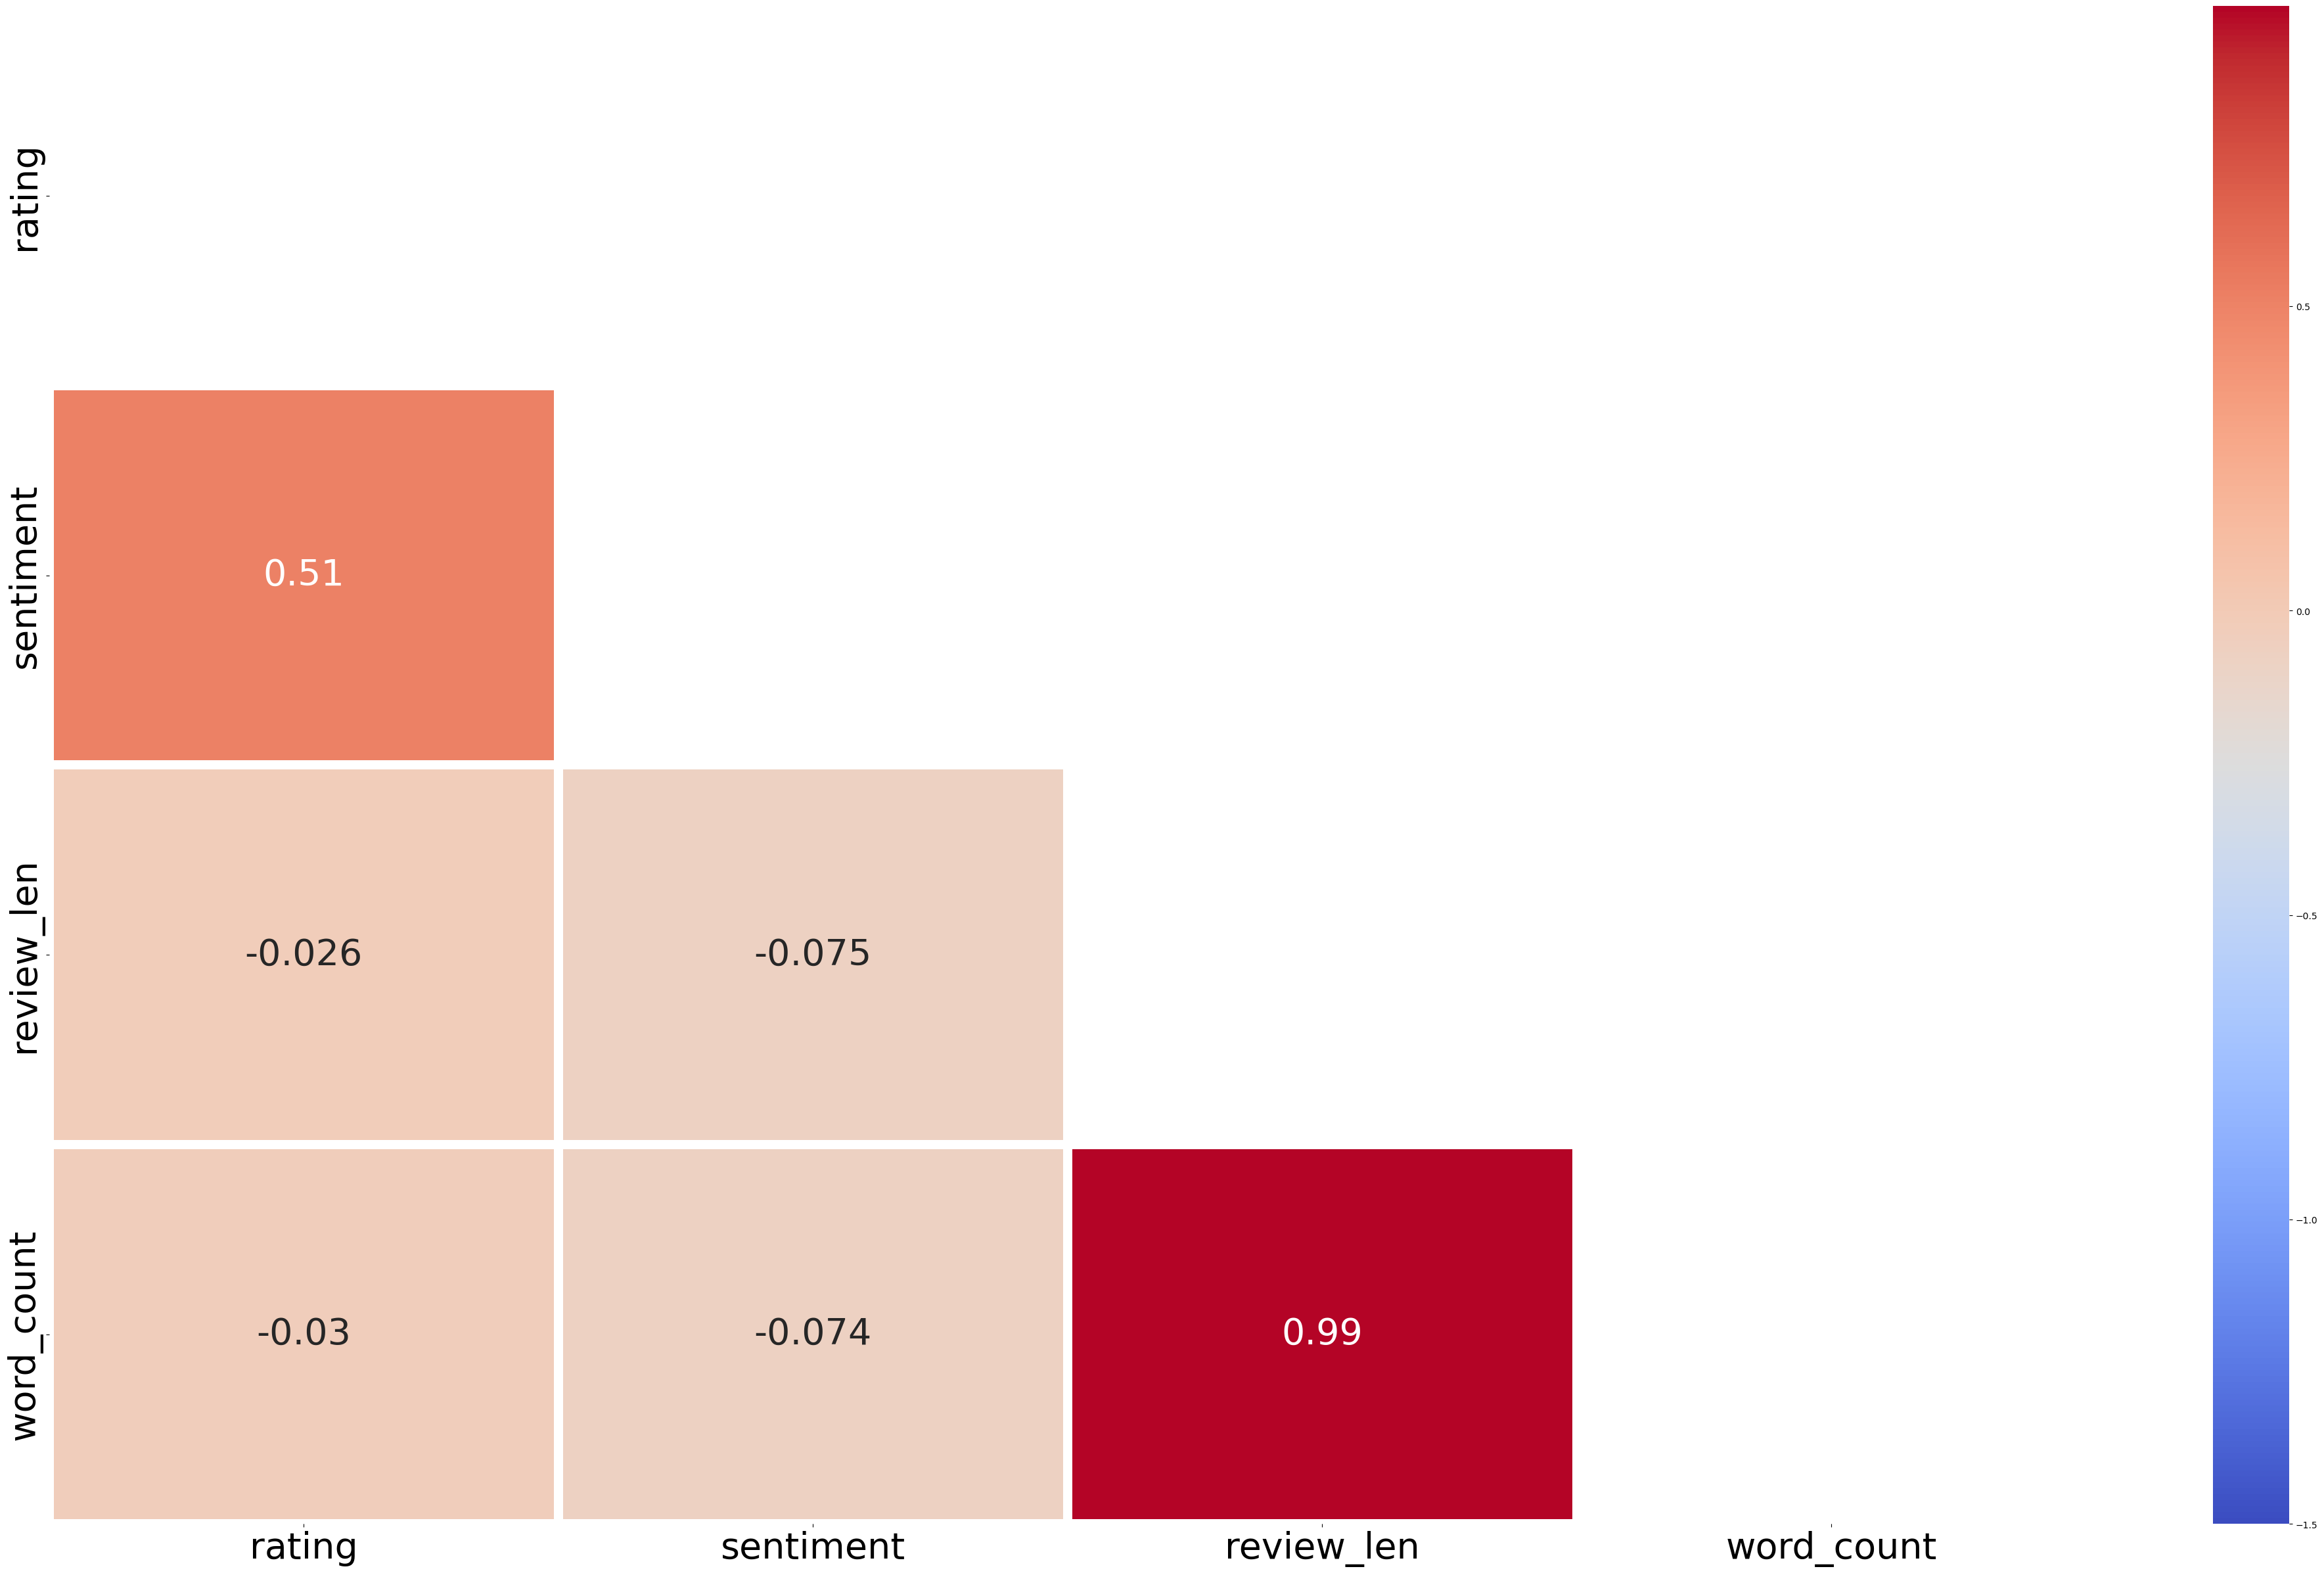

In [108]:
correlation = df[['rating','sentiment', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

Term Frequency Analysis

The next part of the analysis is the term frequency analysis. The term frequency is defined simply as the frequency of the word $t$ in document $d$. The raw count is then the term frequency <a href="#ref">(Jurafsky et al.)</a>:

$$
tf_{t,d}=\text{count}(t,d)
$$

Taking an in-depth look at the actual reviews themselves. What are the most common words? What are the most common words by rating? 

In [109]:
words = df['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
#print(allwords)

/Users/annavenancio/miniconda3/envs/nlp/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/annavenancio/miniconda3/envs/nlp/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/annavenancio/miniconda3/envs/nlp/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/annavenancio/miniconda3/envs/nlp/lib/python3.10/site-packages/wordcloud/wordclo

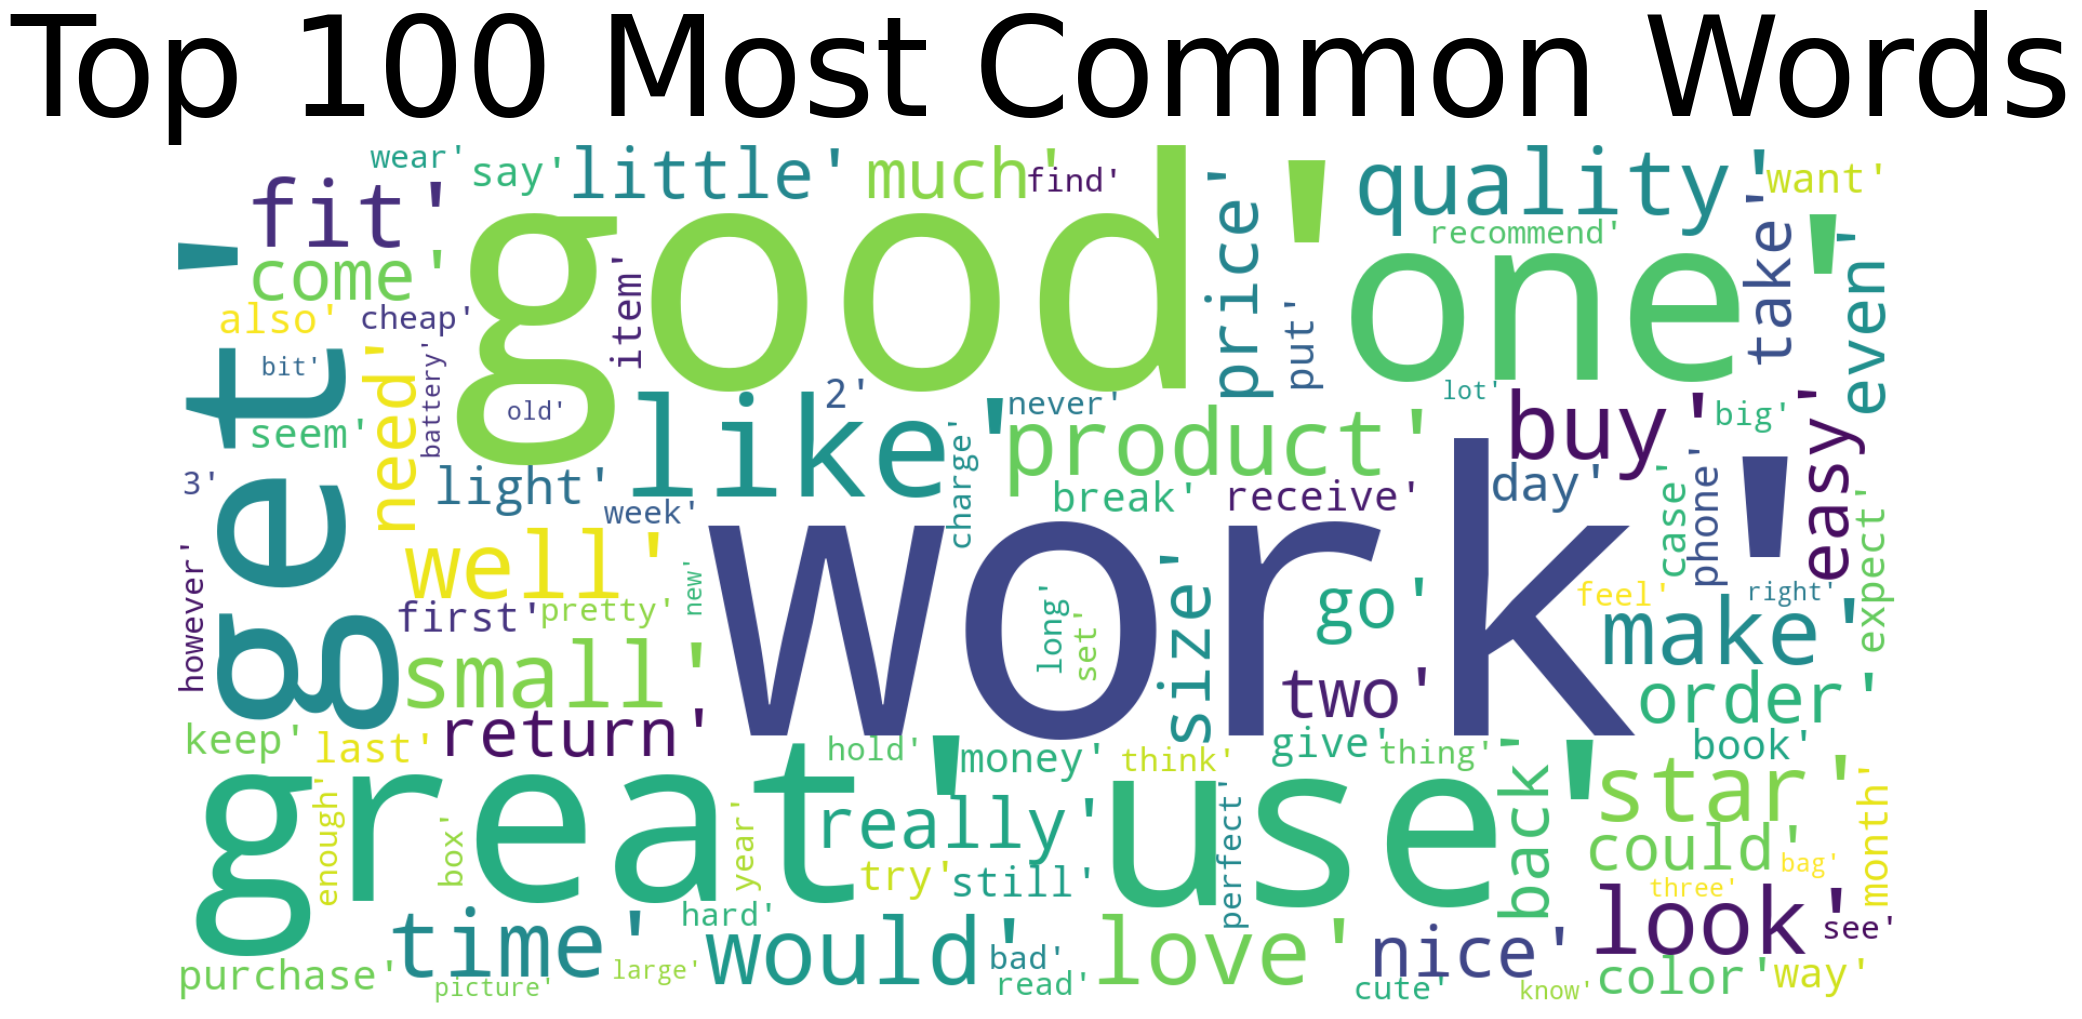

In [110]:
from wordcloud import WordCloud, ImageColorGenerator
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

The most common words seem to be "work", "use", "get", "like" etc. which gives us an obvious insight that the main goal for products are their usage. We could notice that it is very much about verbs (e.g. use, get, look, like) and also attributes/judgements (e.g. like, good, well, great, small).

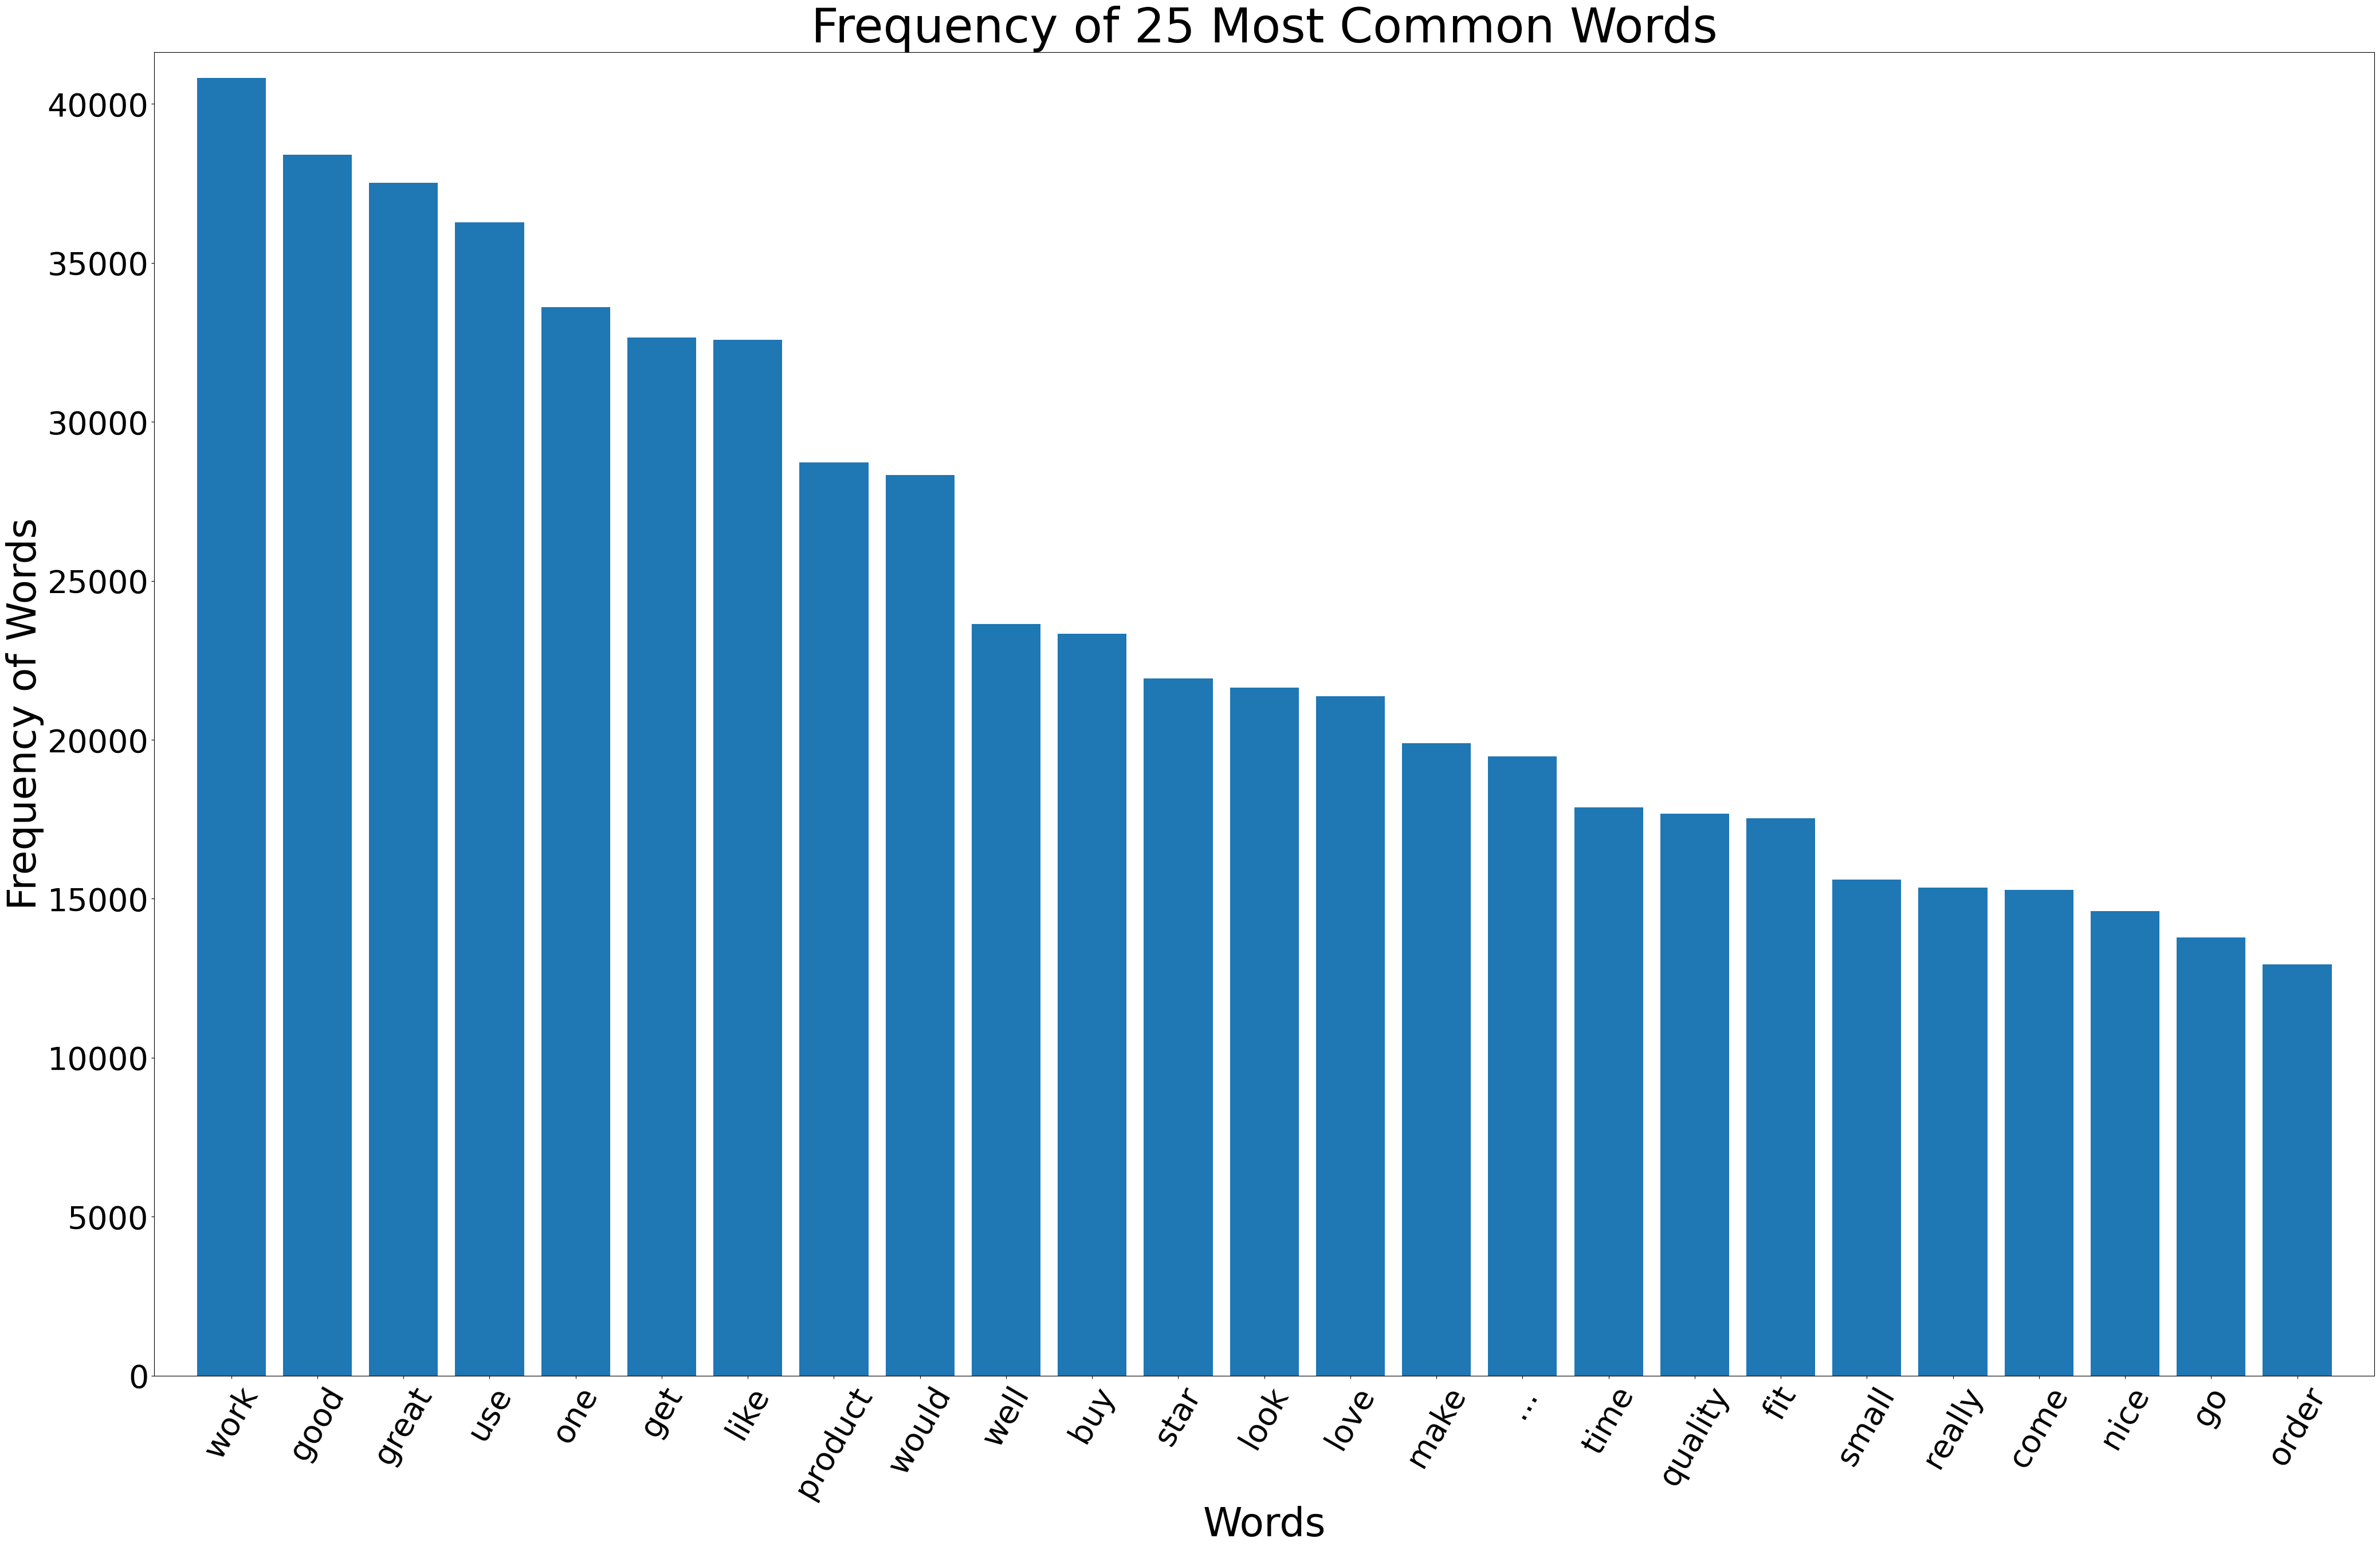

In [111]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

It is not clear how to interpret this graph. Terms such as "Like", “Work”, "Love", "Great" point to a positive customer experience. Terms as "get" and "would" however depend on the context. "One" could refer to either "company number one" or "my rating is one" etc. The verb "work" might be used in sentences as "the product works great" as well as "it doesn't work at all".

Thus, further research is needed. The most common words for each rating will be considered separately below.

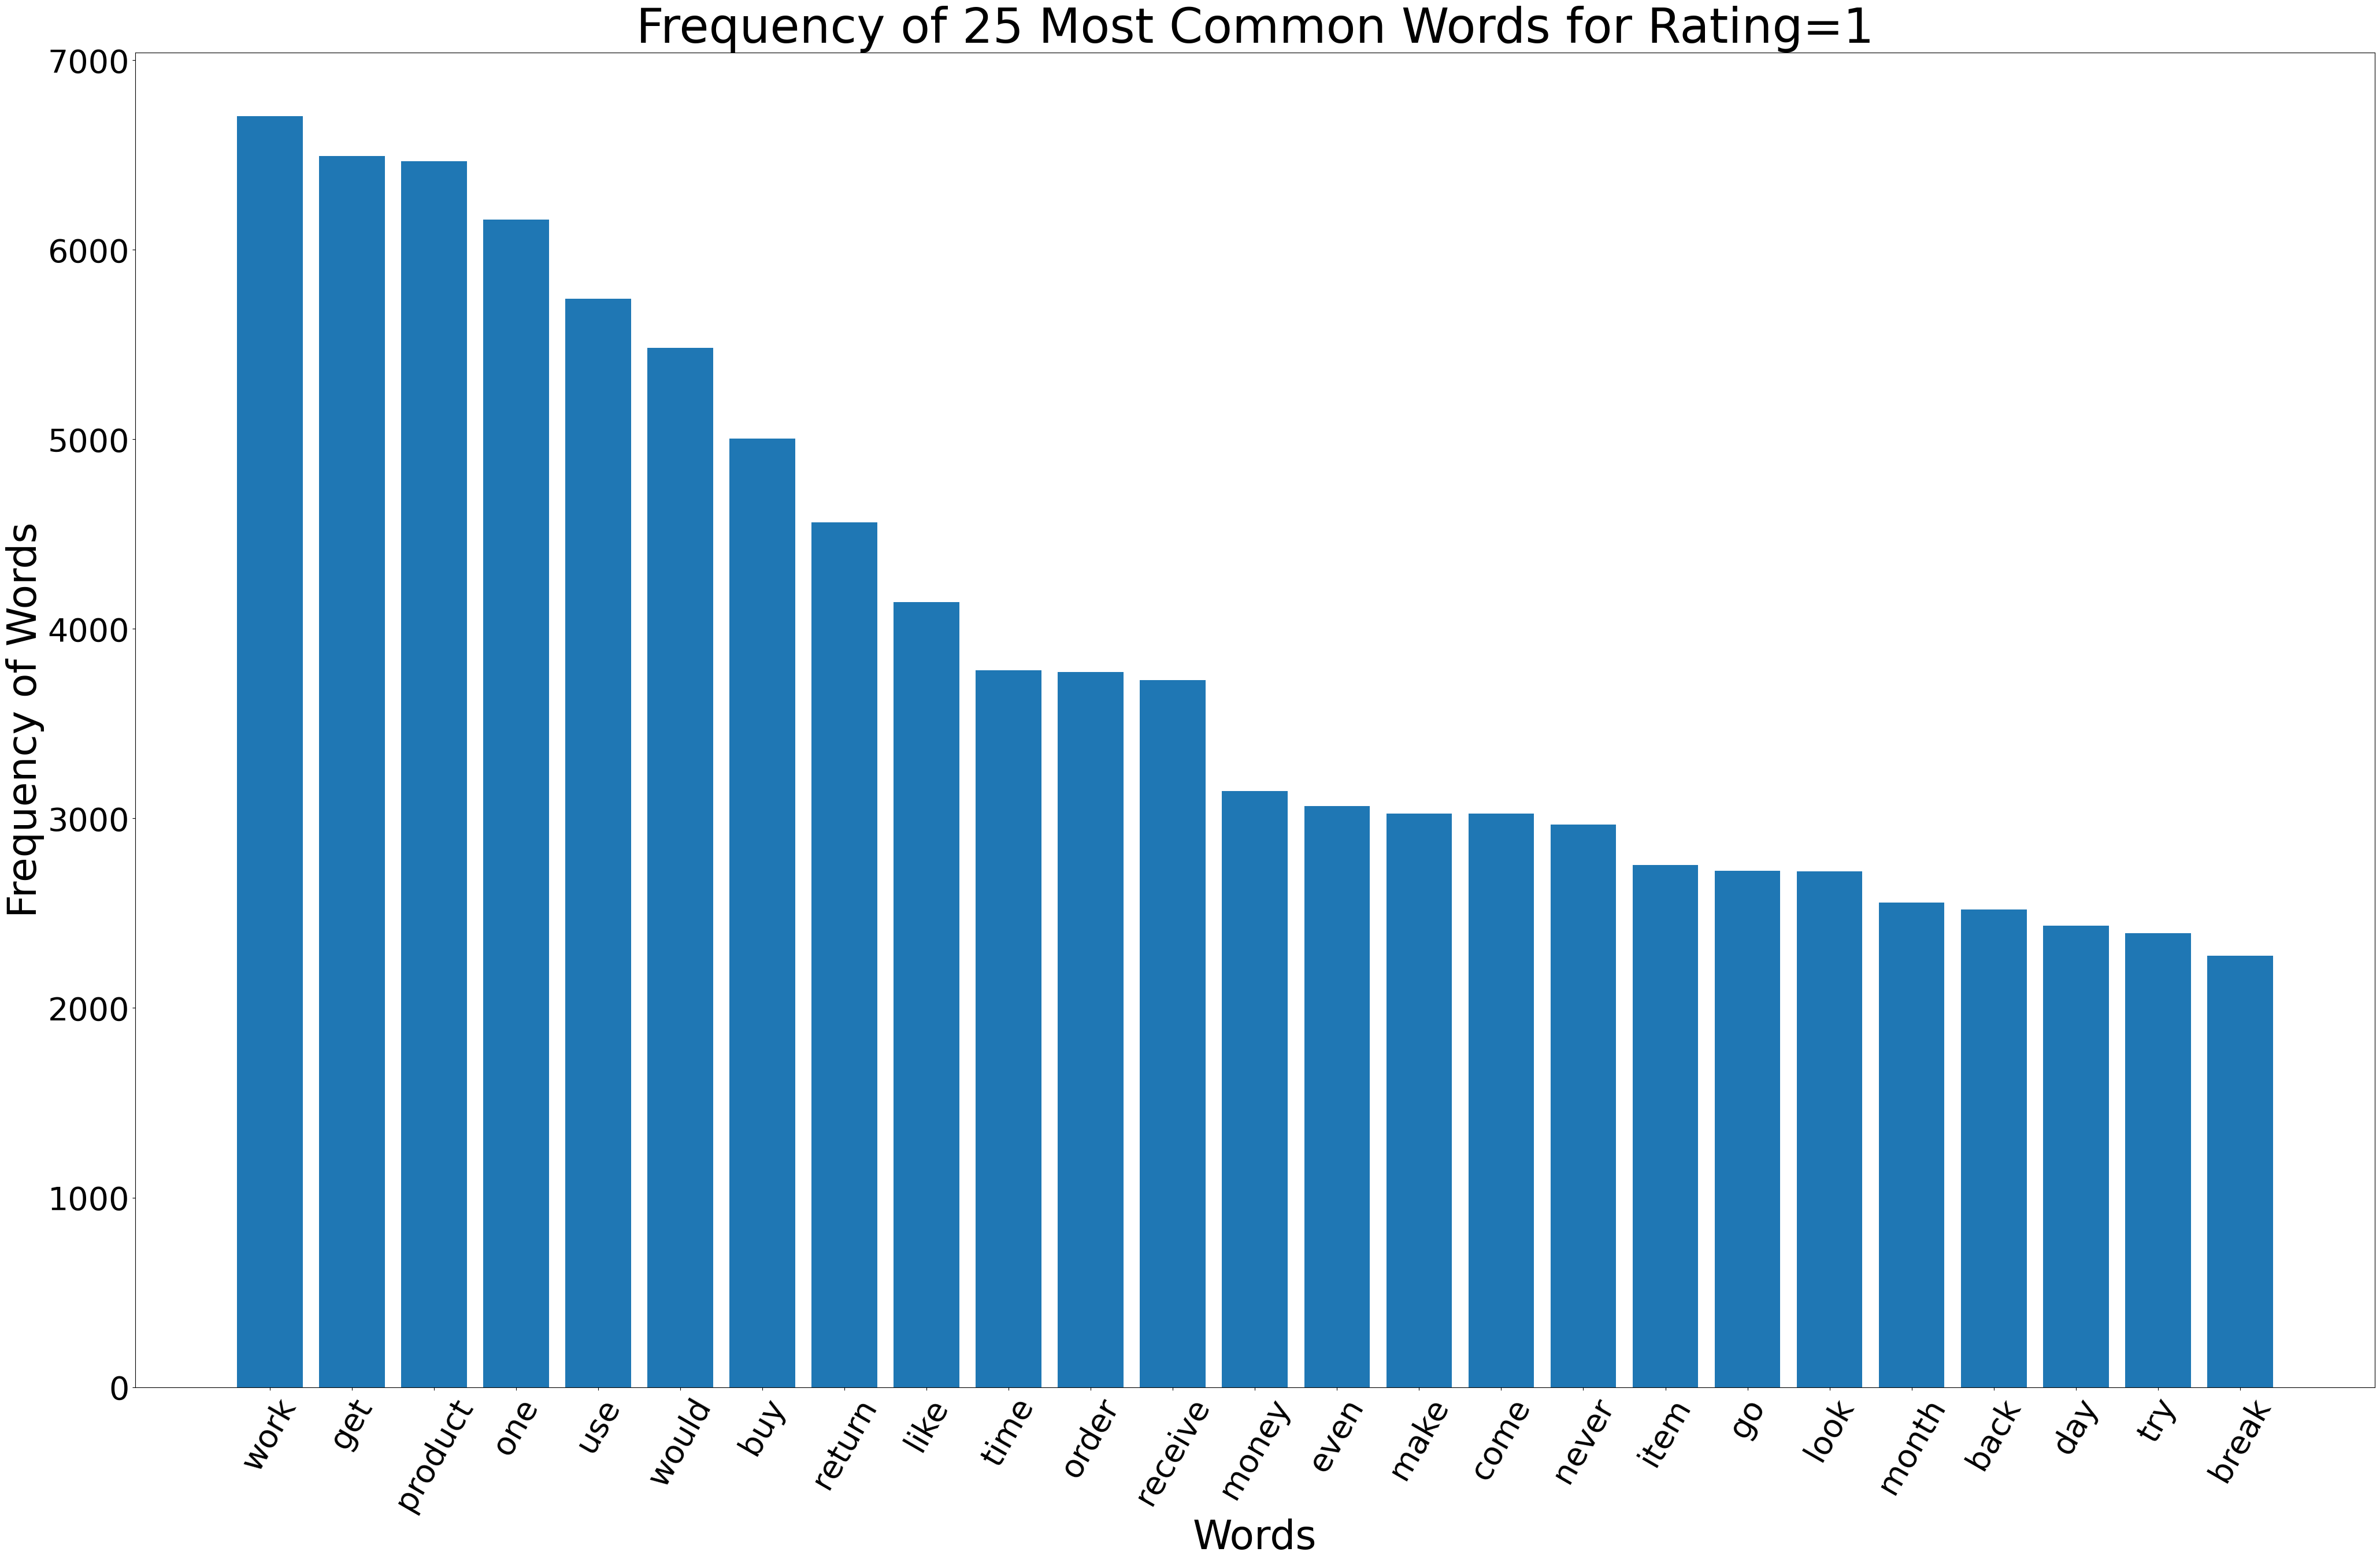

In [ ]:
group_by = df.groupby('rating')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=1', fontsize=60)
plt.show()

It seems the most common words for reviews where the rating = 1 had something to do with the "Work", "Product" - probably a faulty item. No constraints on the interpretation since the ratings are equally distributed.

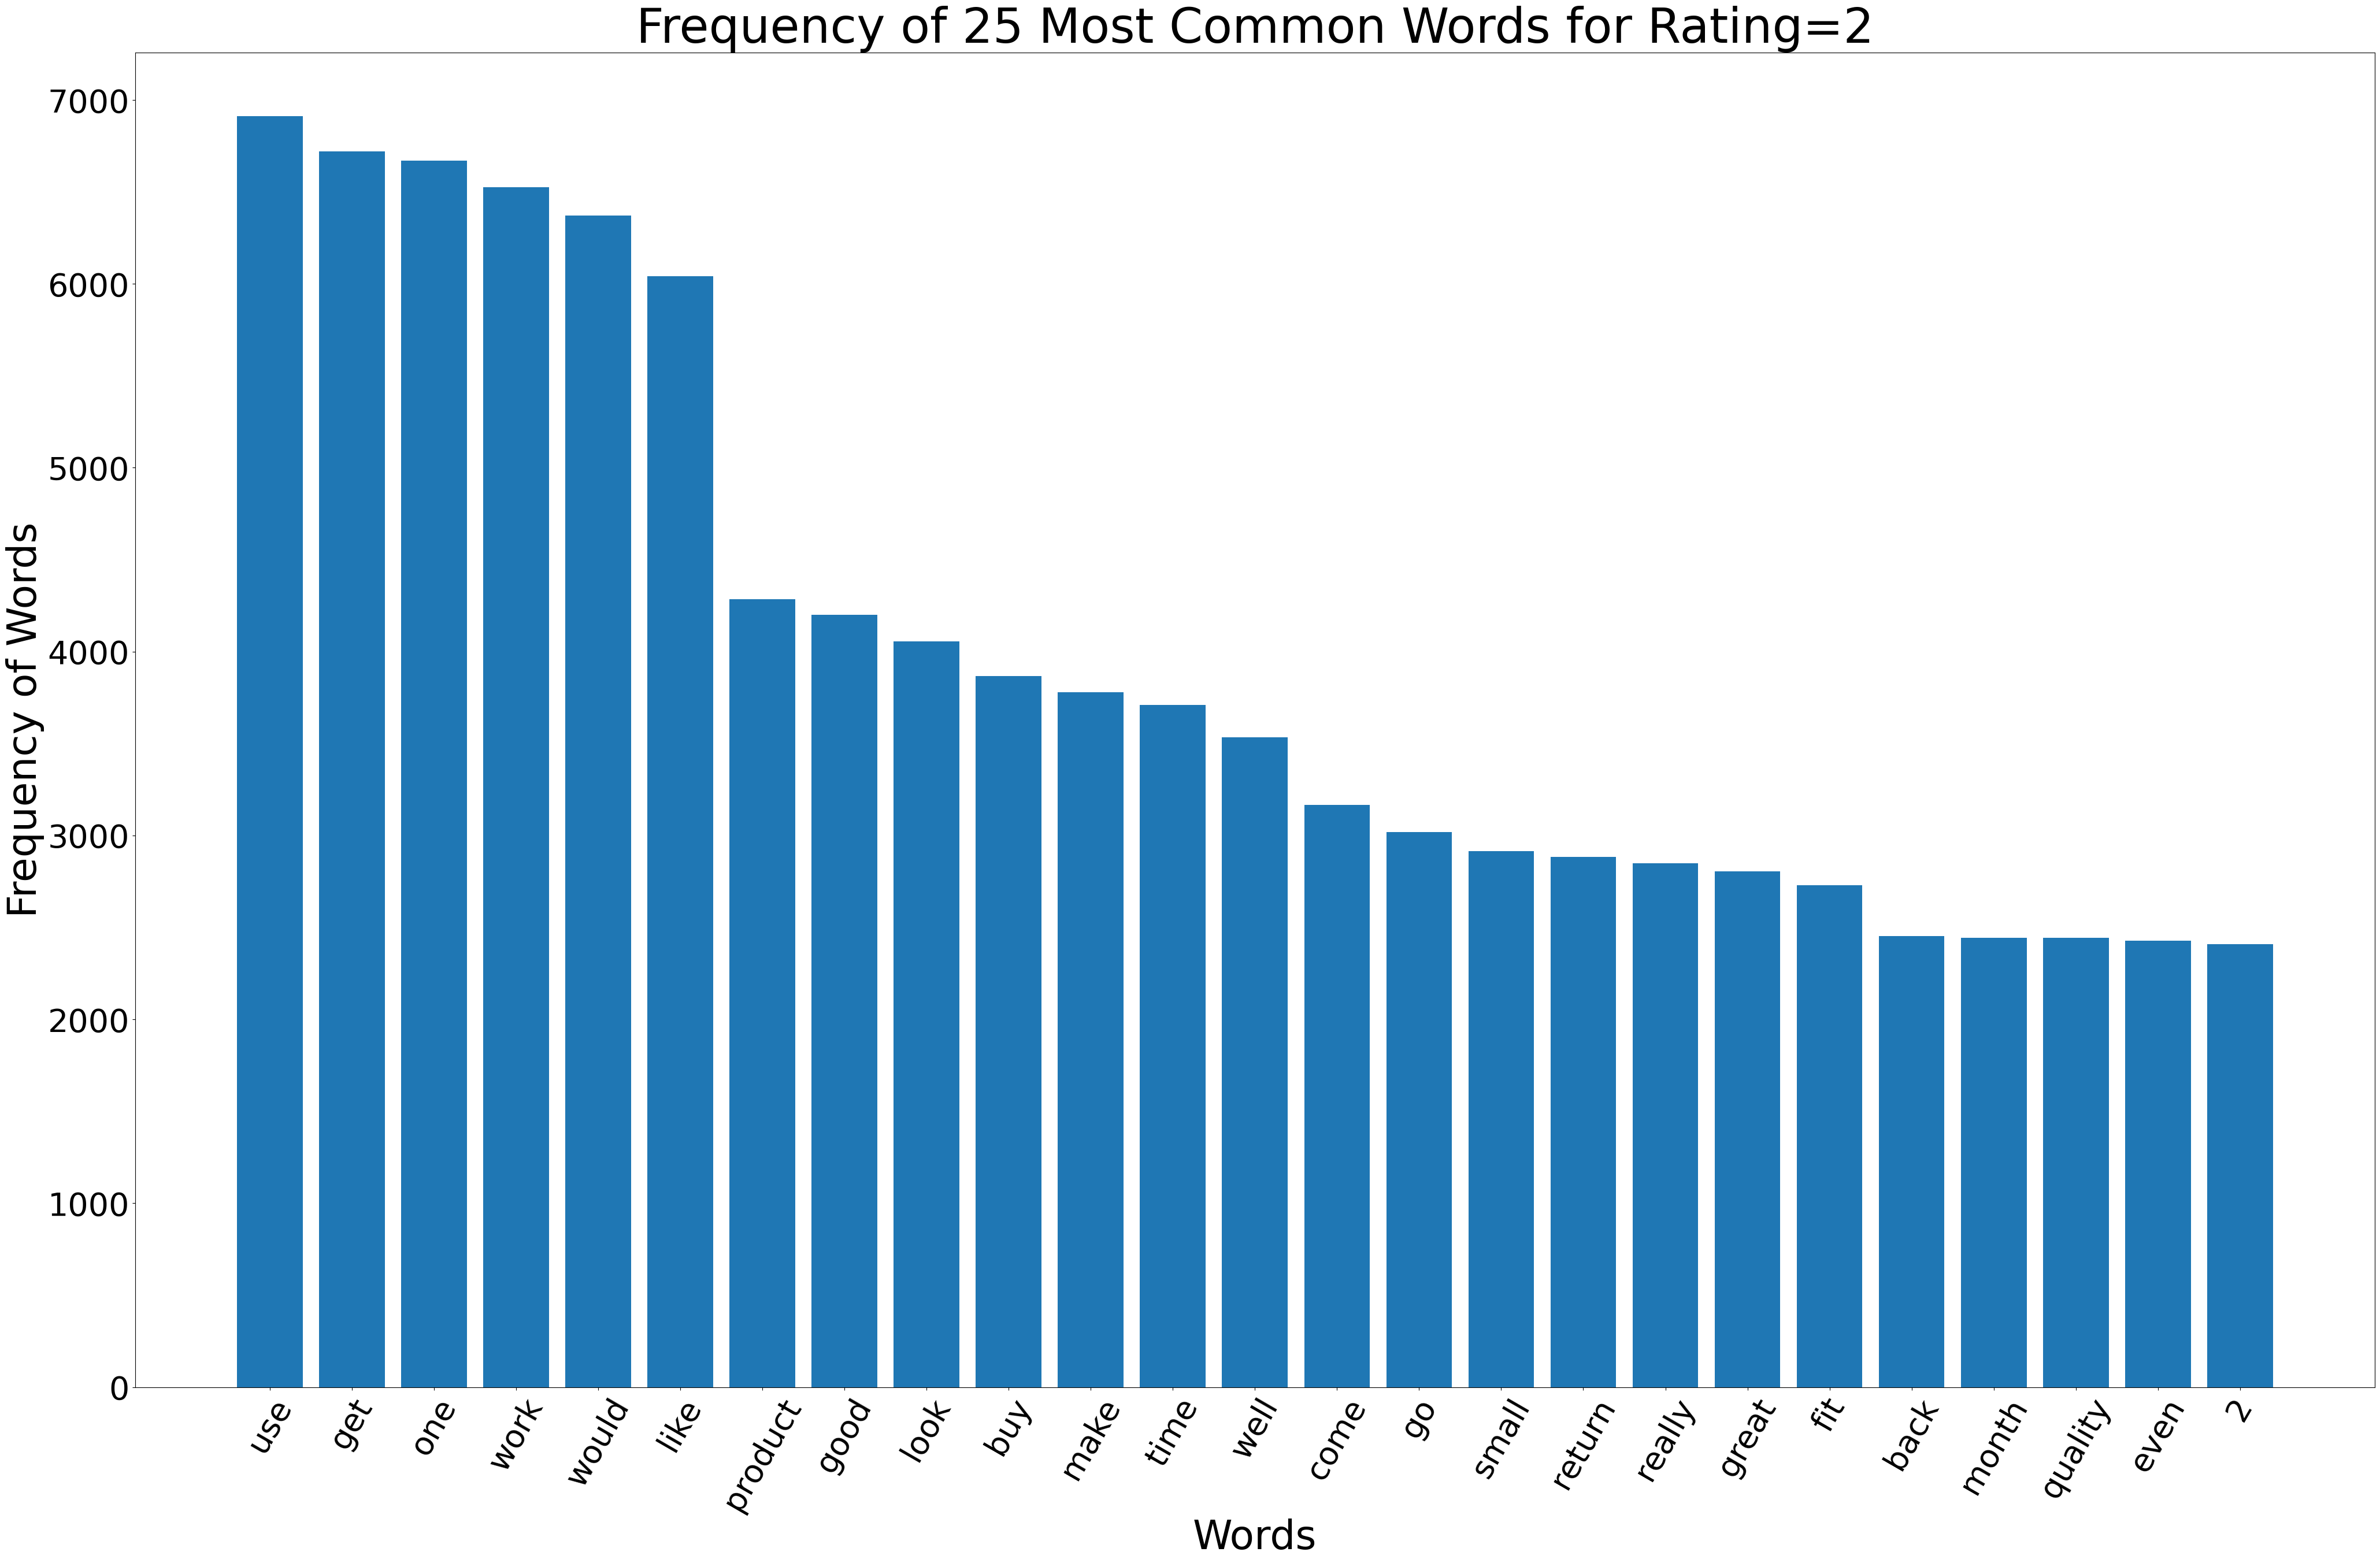

In [ ]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(50,30))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=2', fontsize=60)
plt.show()

This looks pretty similar to rating 1, although there is an interesting drop in frequency after the word "like".

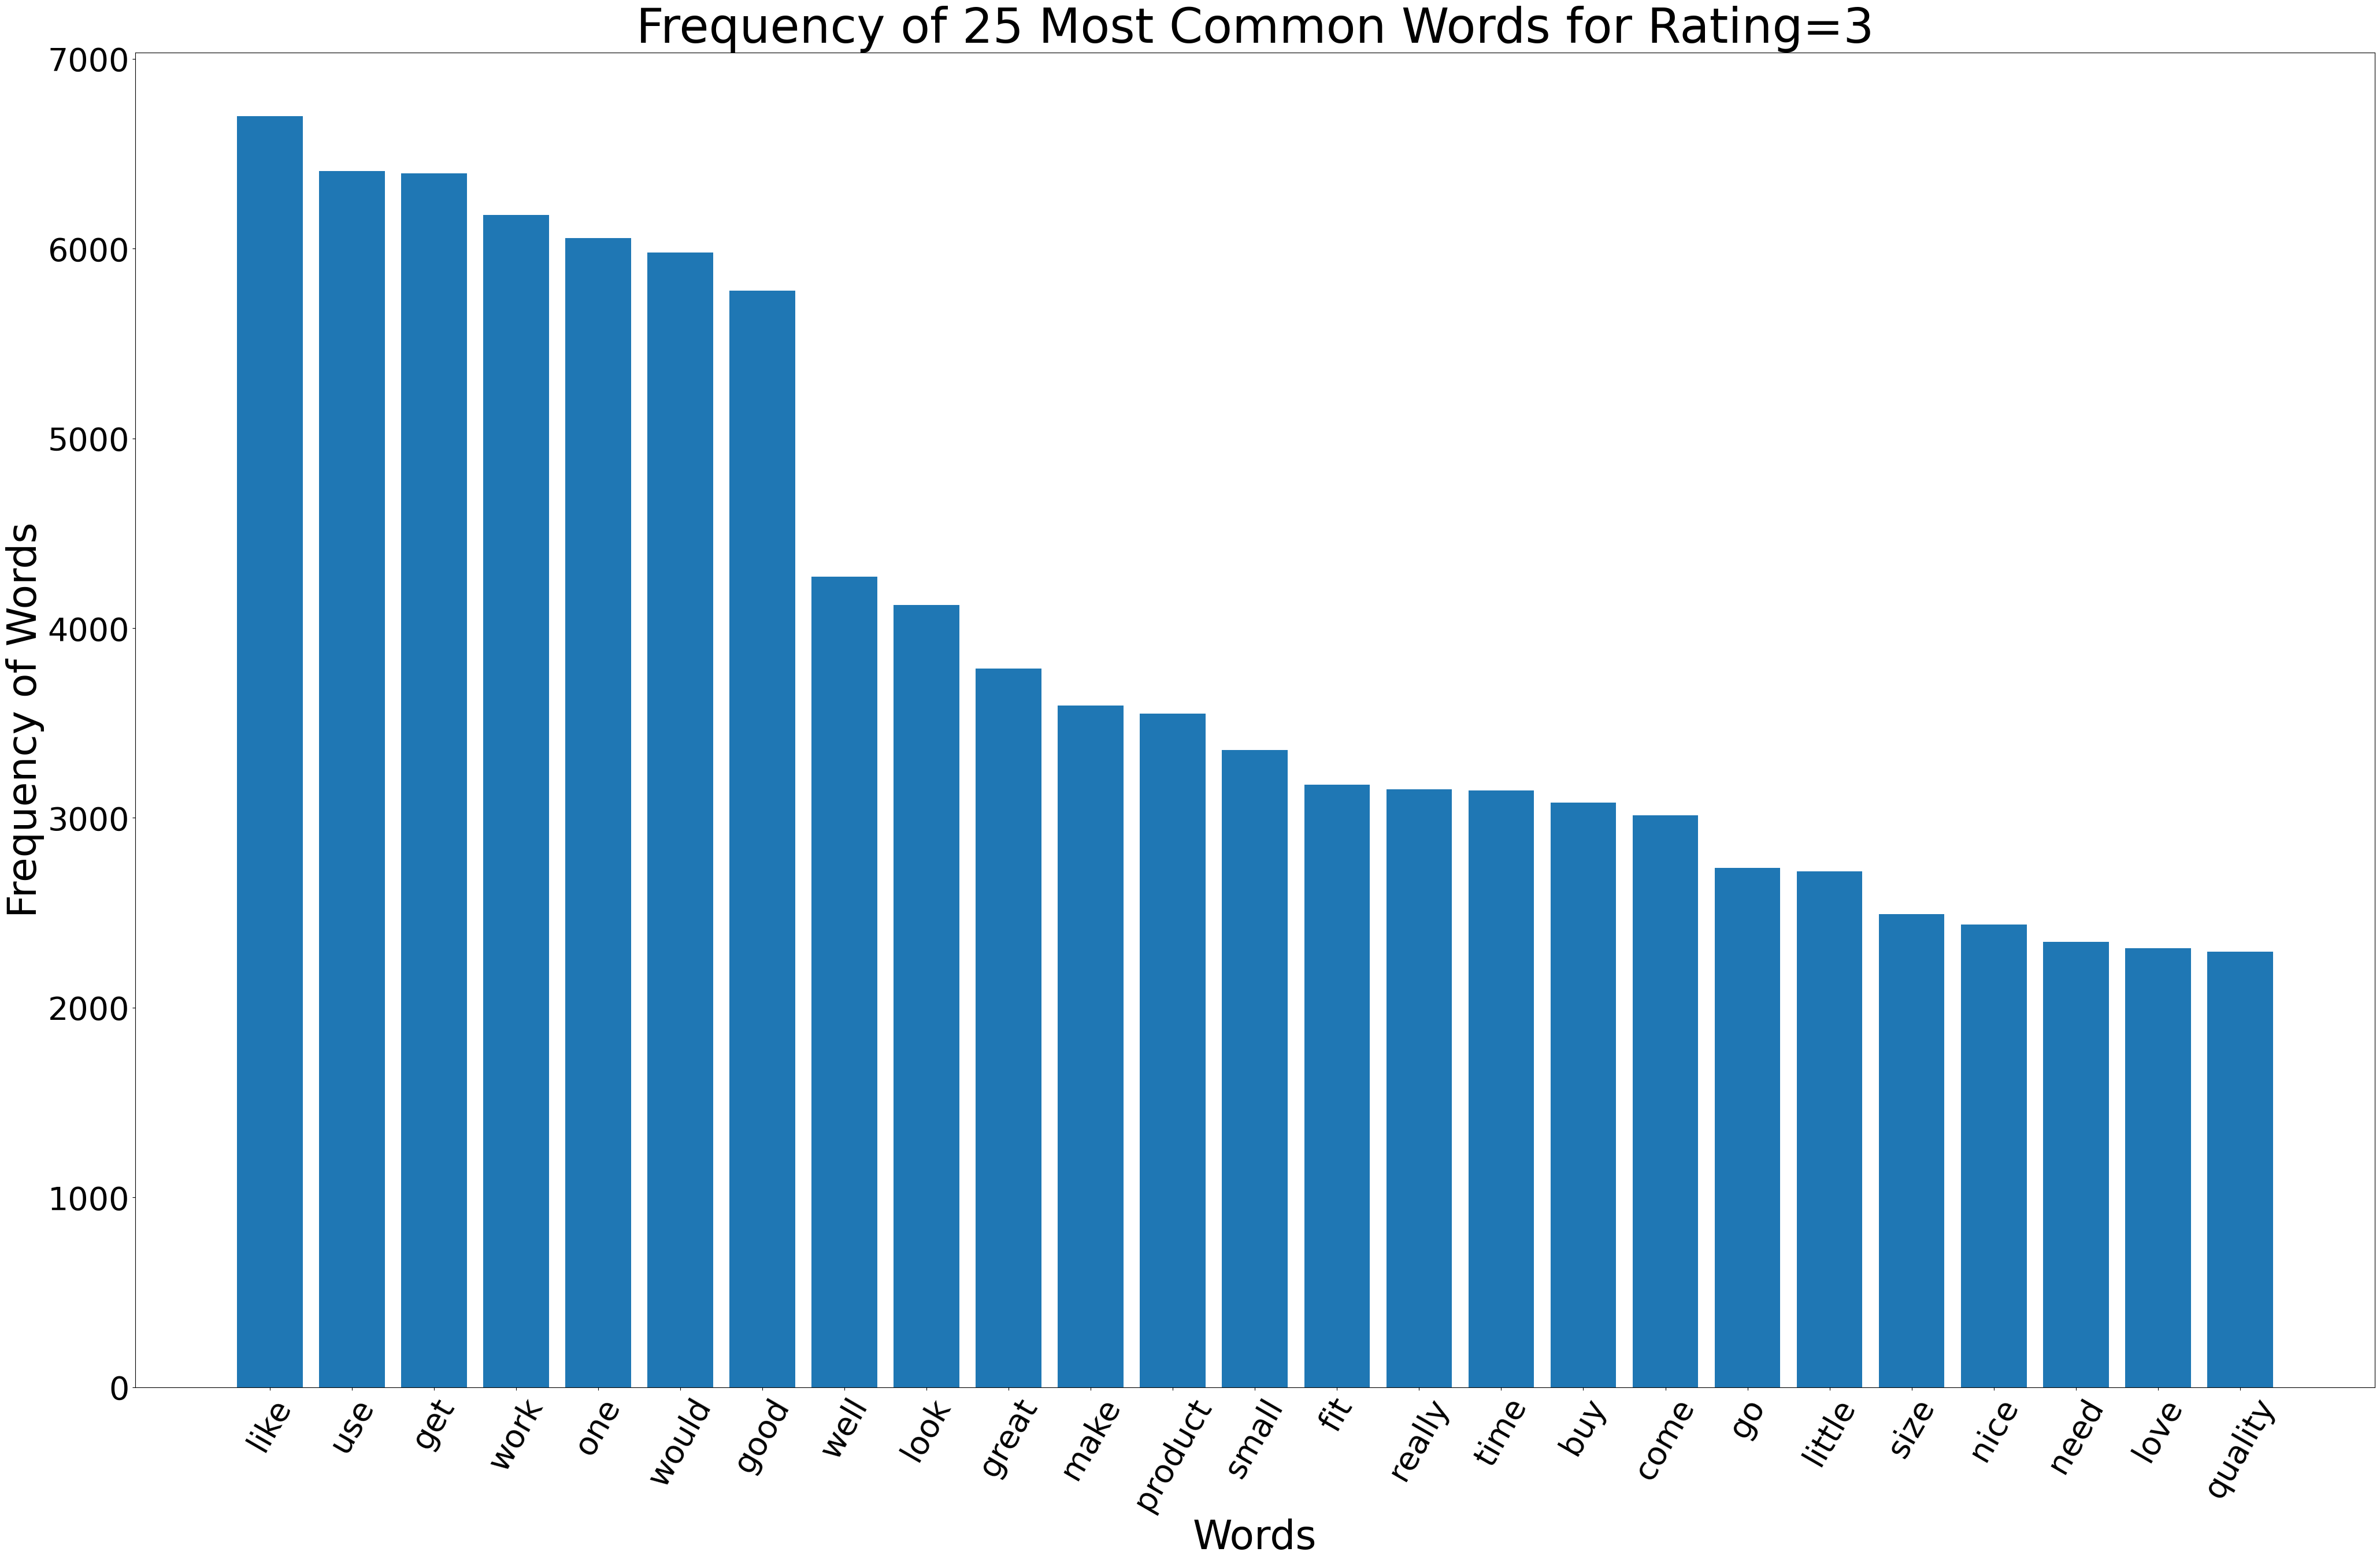

In [ ]:
group_by_2 = group_by.iloc[2]
words2 = list(zip(*group_by_2))[0]
freq2 = list(zip(*group_by_2))[1]
plt.figure(figsize=(50,30))
plt.bar(words2, freq2)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=3', fontsize=60)
plt.show()

It is difficult to derive accurate insights from “neutral” ratings. The distribution looks similar to rating 2, indicating there are some faulty products sold to customers. This also mentions "small" and "fit" as well as "look".

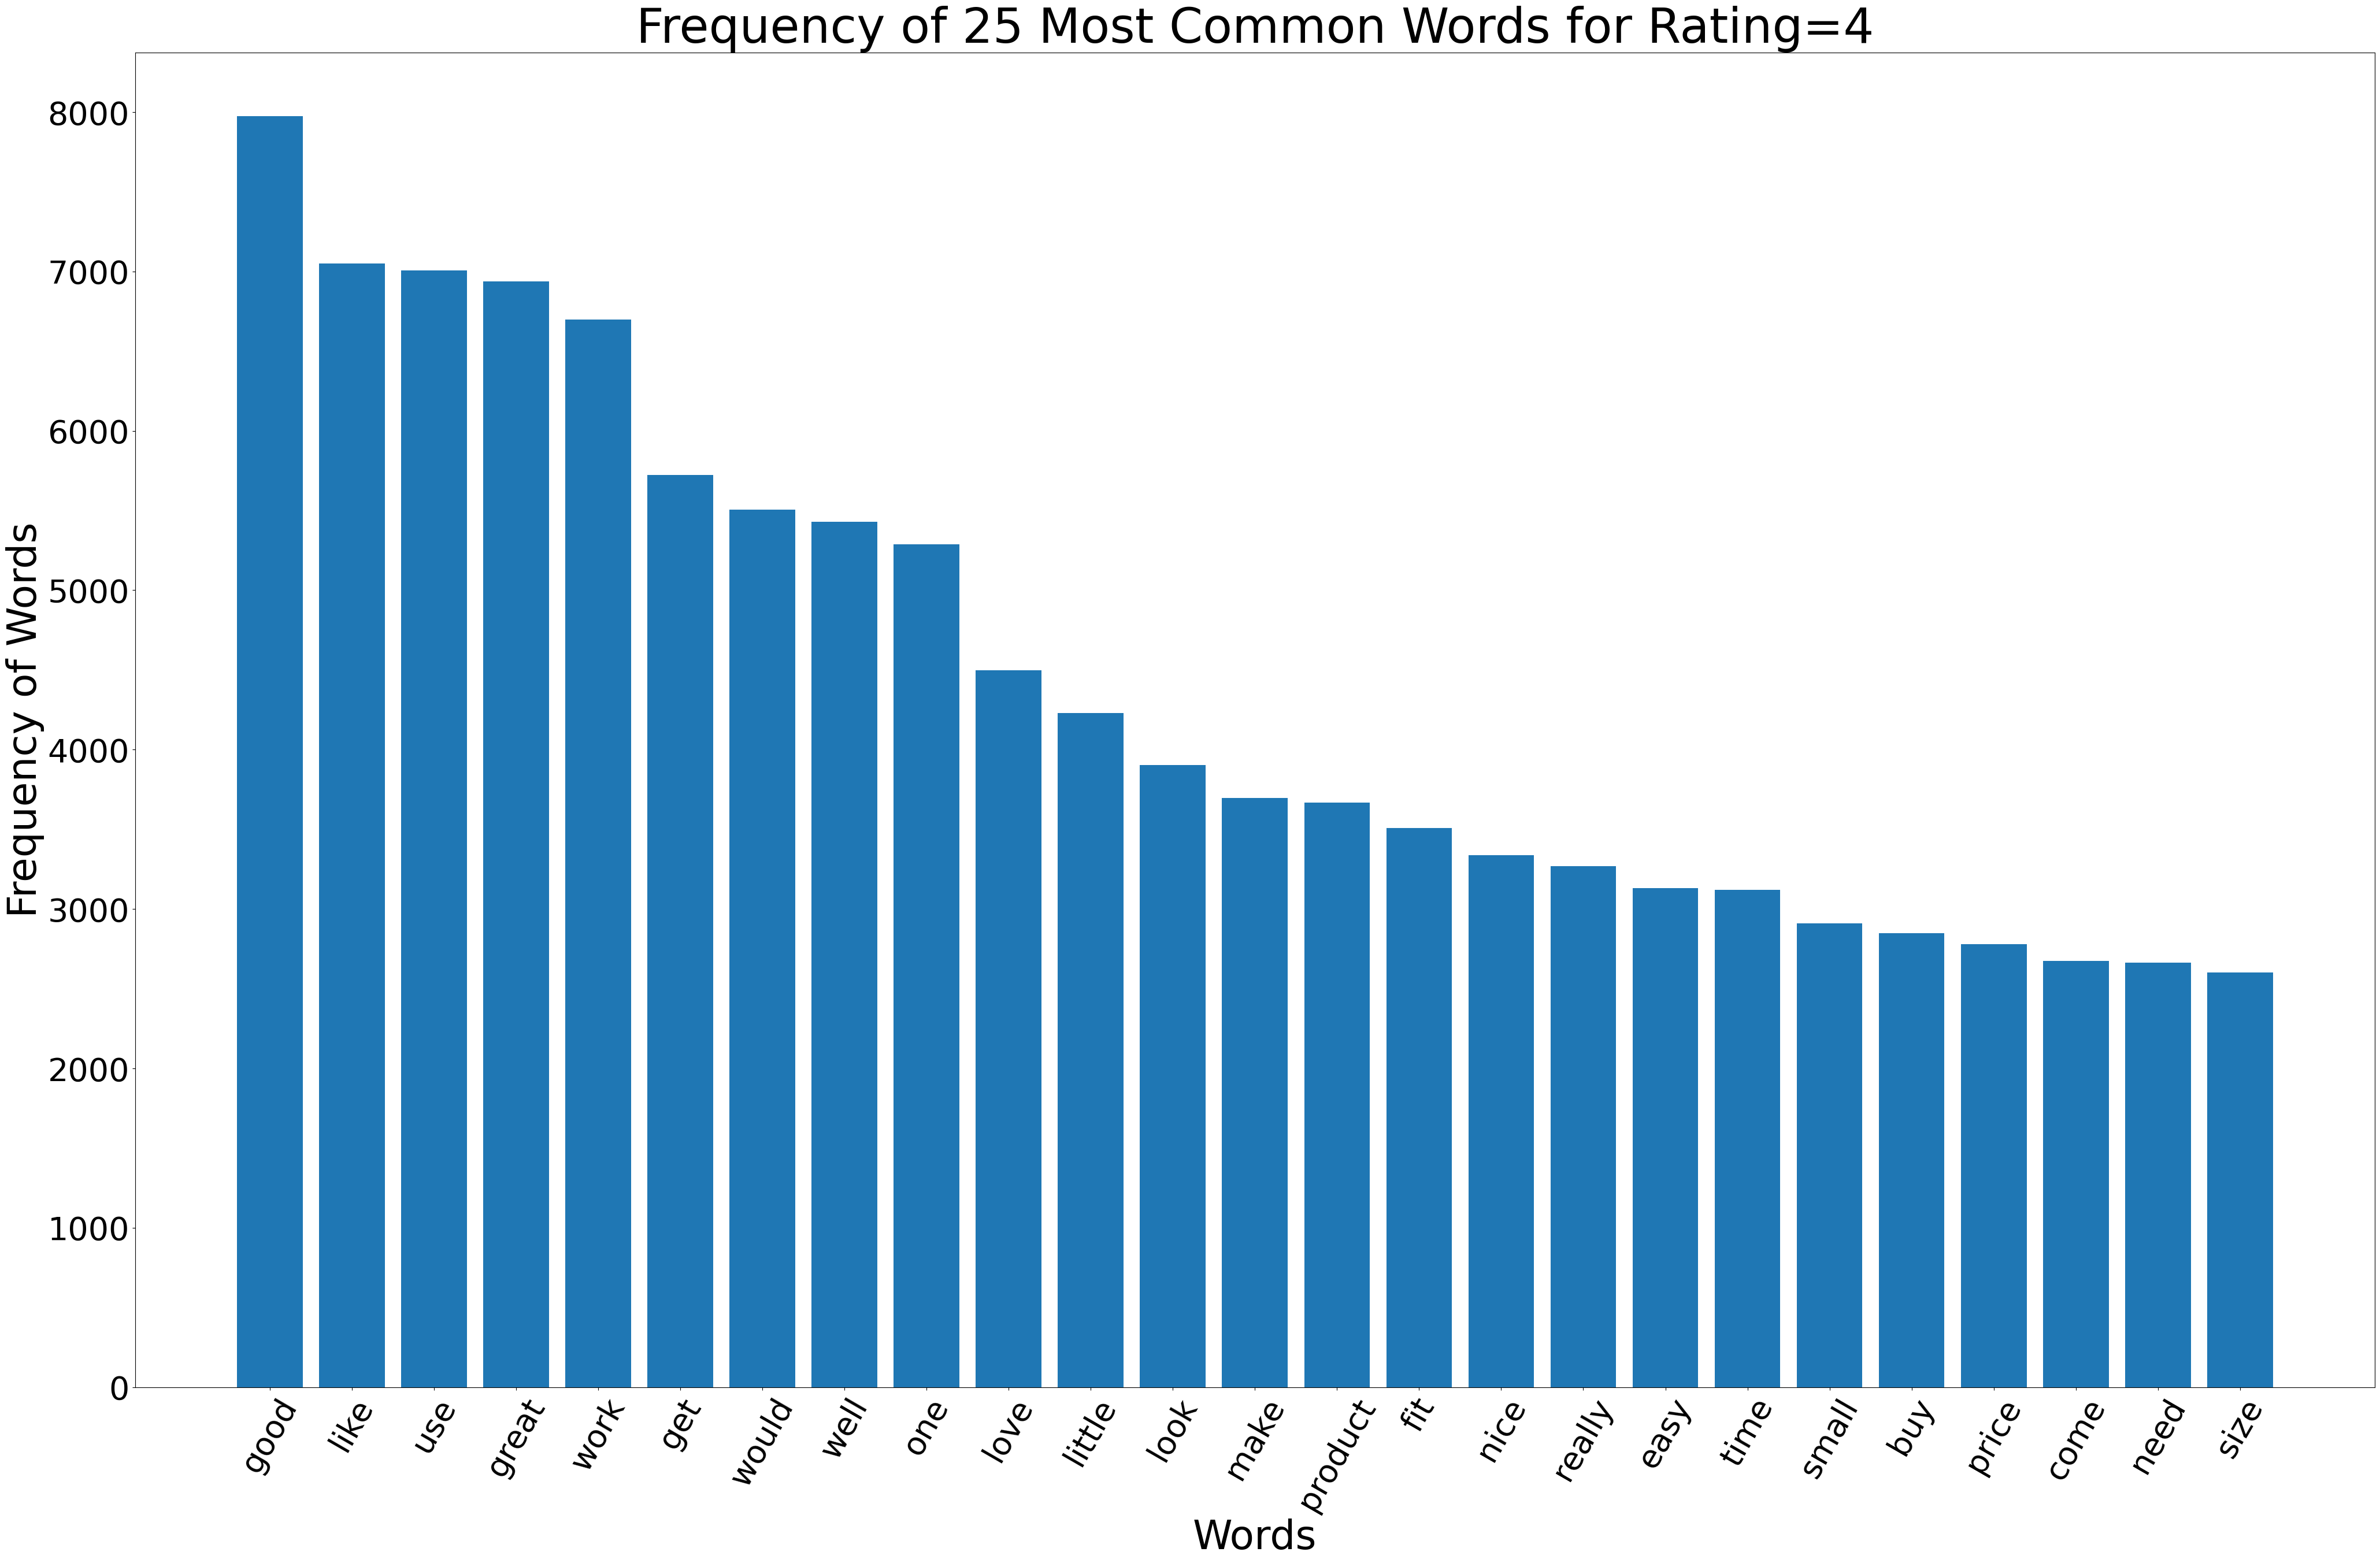

In [ ]:
group_by_3 = group_by.iloc[3]
words3 = list(zip(*group_by_3))[0]
freq3 = list(zip(*group_by_3))[1]
plt.figure(figsize=(50,30))
plt.bar(words3, freq3)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=4', fontsize=60)
plt.show()

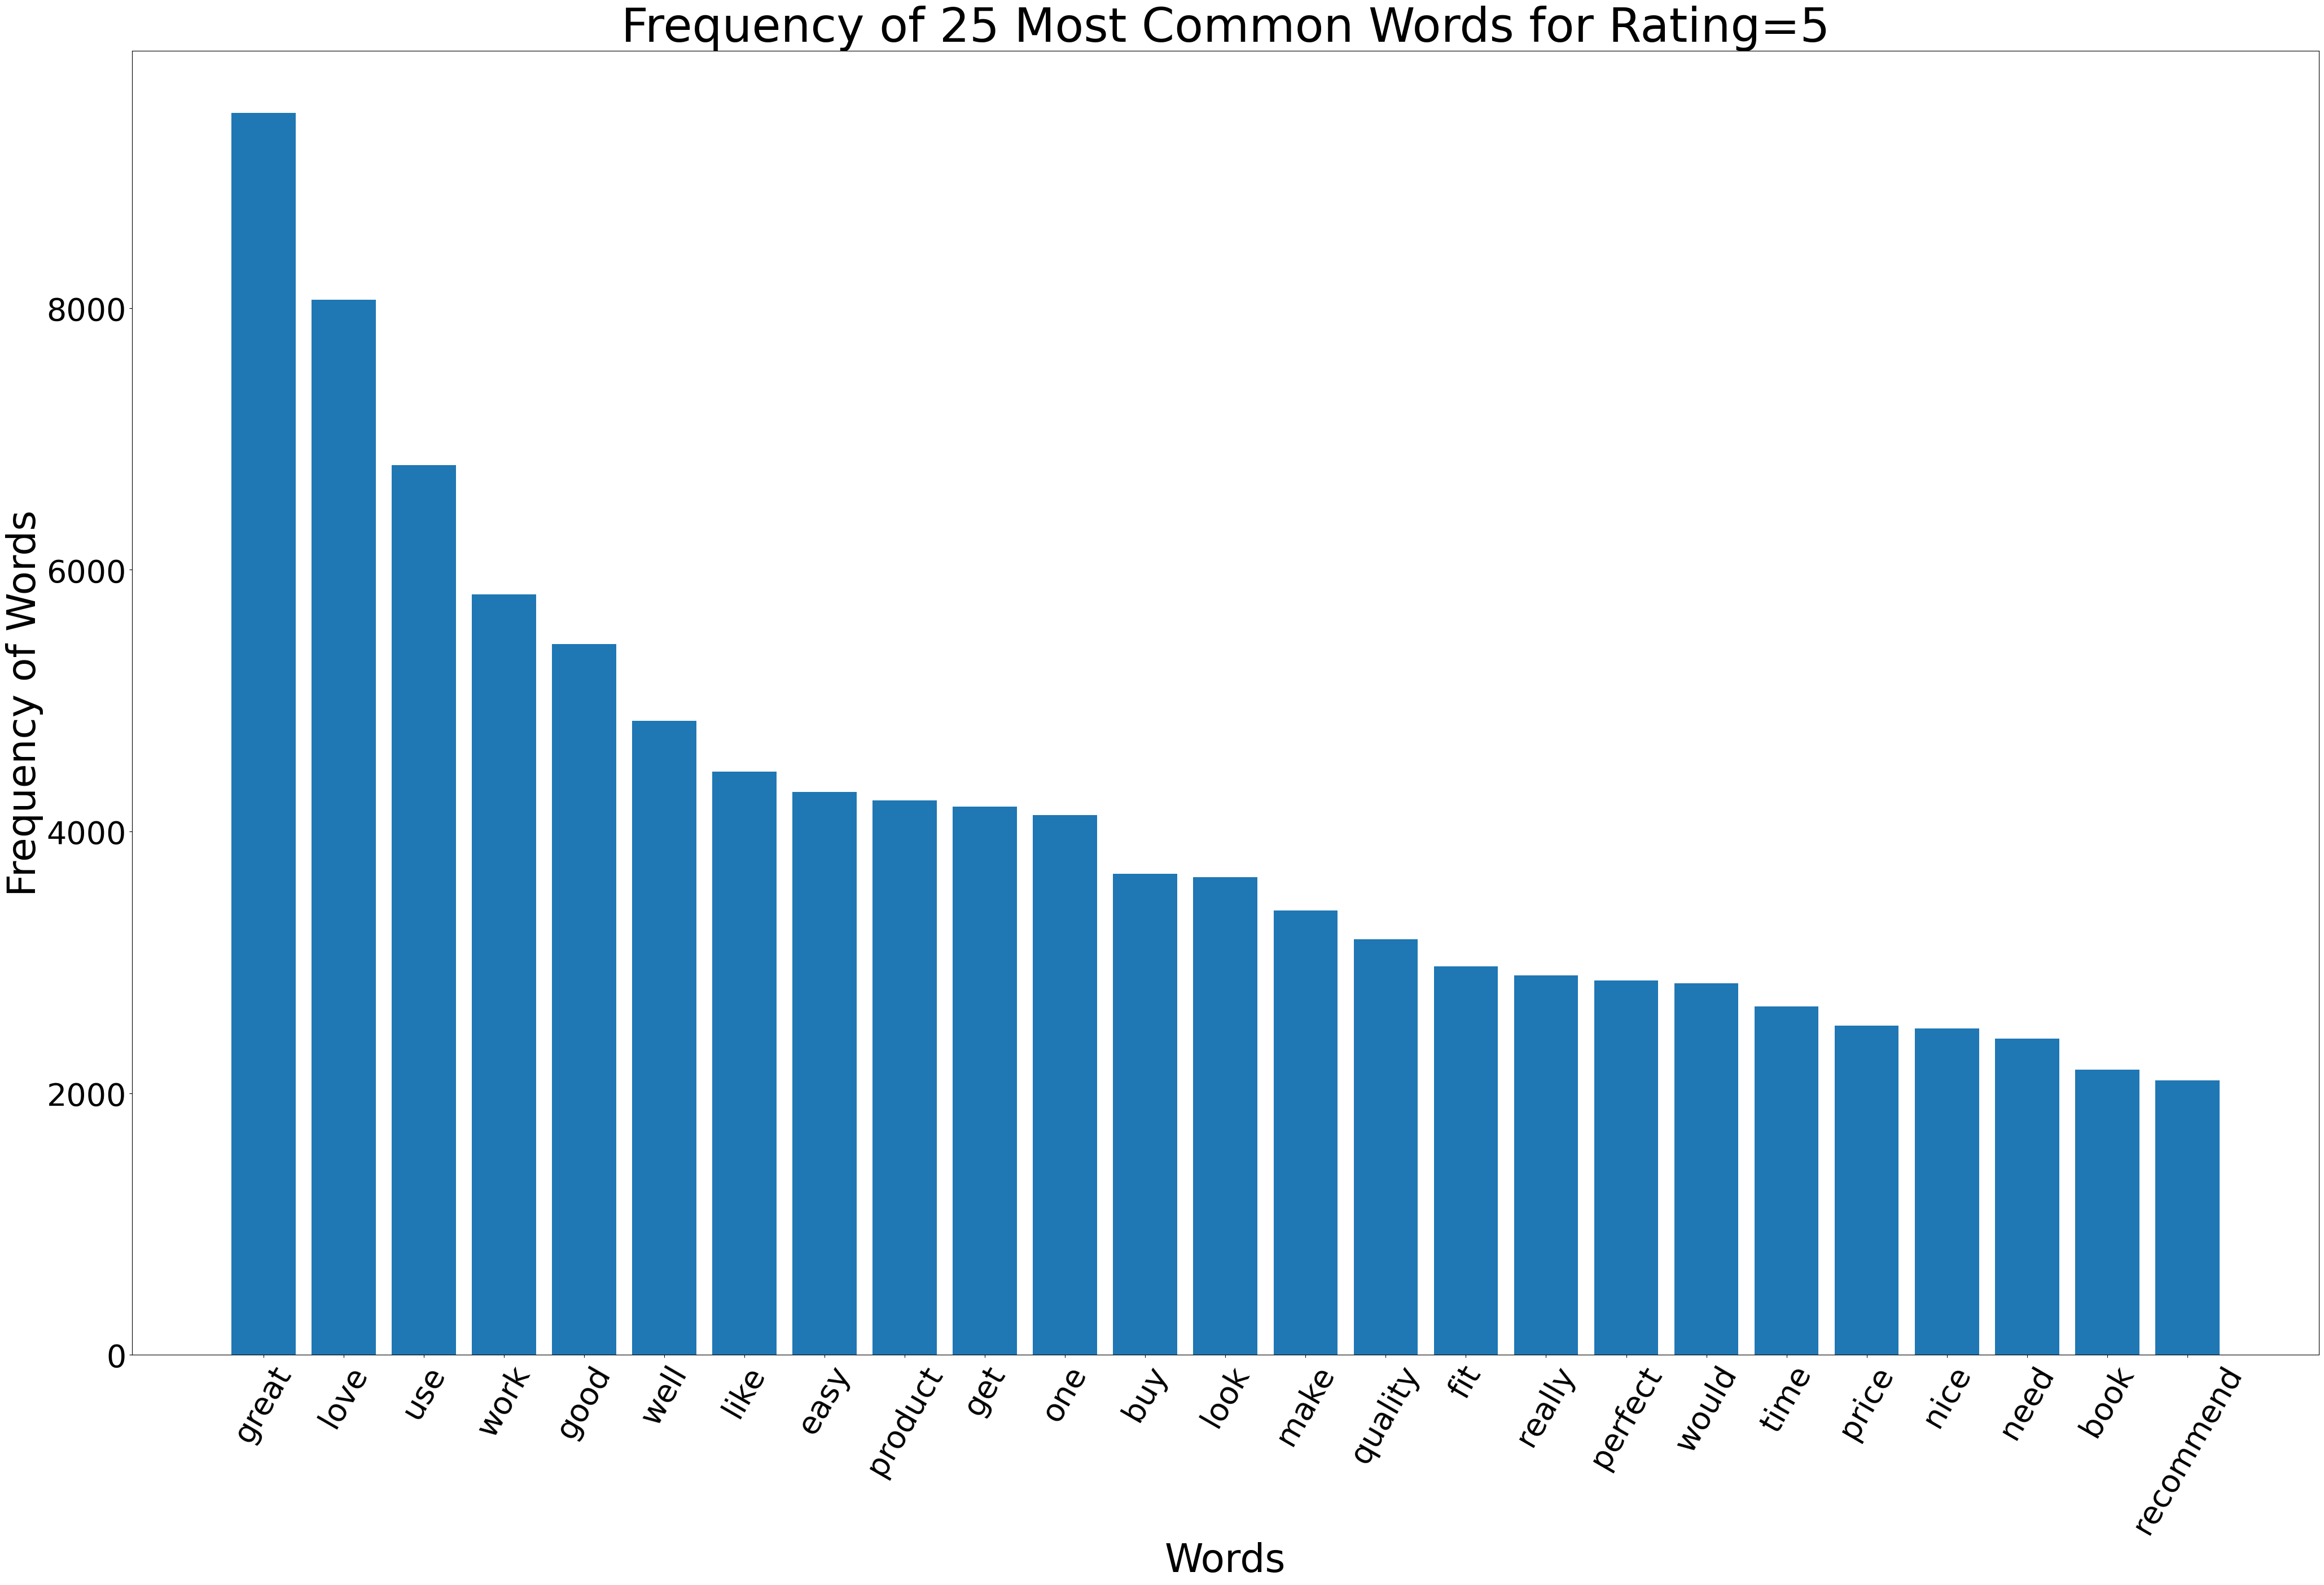

In [ ]:
group_by_4 = group_by.iloc[4]
words4 = list(zip(*group_by_4))[0]
freq4 = list(zip(*group_by_4))[1]
plt.figure(figsize=(50,30))
plt.bar(words4, freq4)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=5', fontsize=60)
plt.show()

As expected, the most common word for rating 4 is "good" and for rating 5 is "great". Furthermore, ratings of 4 and 5 had very similar terms as customers enjoyed their orders. The words such as "quality" and "perfect" also make appearances. 


In [113]:
subset_rate12 = rws_train[(rws_train['rating'] < 3)]
subset_rate12.head()


rating   
1        2  \
5        1   
10       1   
12       2   
13       2   

                                                                                            review_body   
1   The finger hole is small. Not suitable for a larger man. Does not adjust at all. Would not recom...  \
5   I received these in the mail and they look great. Just like the picture. Trying to try them on w...   
10                                      Both zippers broke my first time using it. Would not recommend.   
12  Not enough pockets. I travel internationally and have to be prepared for missed flights in out o...   
13  I bought these utensils 4 months ago and almost all of the handles have split in two just as the...   

                           review_title product_category   
1                        Not adjustable   office_product  \
5                      incredibly small            shoes   
10                   Broke on first use          kitchen   
12                   Not enough Pockets               pc   
13  Just like all the other reviews say             home   

                                                                                            review_full   
1   Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...  \
5   incredibly small I received these in the mail and they look great. Just like the picture. Trying...   
10                   Broke on first use Both zippers broke my first time using it. Would not recommend.   
12  Not enough Pockets Not enough pockets. I travel internationally and have to be prepared for miss...   
13  Just like all the other reviews say I bought these utensils 4 months ago and almost all of the h...   

                                                                                            no_contract   
1   [Not, adjustable, The, finger, hole, is, small., Not, suitable, for, a, larger, man., Does, not,...  \
5   [incredibly, small, I, received, these, in, the, mail, and, they, look, great., Just, like, the,...   
10   [Broke, on, first, use, Both, zippers, broke, my, first, time, using, it., Would, not, recommend.]   
12  [Not, enough, Pockets, Not, enough, pockets., I, travel, internationally, and, have, to, be, pre...   
13  [Just, like, all, the, other, reviews, say, I, bought, these, utensils, 4, months, ago, and, alm...   

                                                                                        review_body_str   
1   Not adjustable The finger hole is small. Not suitable for a larger man. Does not adjust at all. ...  \
5   incredibly small I received these in the mail and they look great. Just like the picture. Trying...   
10                   Broke on first use Both zippers broke my first time using it. Would not recommend.   
12  Not enough Pockets Not enough pockets. I travel internationally and have to be prepared for miss...   
13  Just like all the other reviews say I bought these utensils 4 months ago and almost all of the h...   

                                                                                              tokenized   
1   [Not, adjustable, The, finger, hole, is, small, ., Not, suitable, for, a, larger, man, ., Does, ...  \
5   [incredibly, small, I, received, these, in, the, mail, and, they, look, great, ., Just, like, th...   
10  [Broke, on, first, use, Both, zippers, broke, my, first, time, using, it, ., Would, not, recomme...   
12  [Not, enough, Pockets, Not, enough, pockets, ., I, travel, internationally, and, have, to, be, p...   
13  [Just, like, all, the, other, reviews, say, I, bought, these, utensils, 4, months, ago, and, alm...   

                                                                                                  lower   
1   [not, adjustable, the, finger, hole, is, small, ., not, suitable, for, a, larger, man, ., does, ...  \
5   [incredibly, small, i, received, these, in, the, mail, and, they, look, great, ., just, like, th...   
10  [broke, on, first,

To understand customer dissatisfaction, negative reviews are explored next (that is, with ratings of 1 and 2).

In [114]:
# use subset_rate12 in following code
subset_rate12 = rws_train[(rws_train['rating'] < 3)]
subset_rate12['product_category'].value_counts()
subset_rate12 = subset_rate12[subset_rate12['product_category'].isin(['home','wireless','apparel'])]
subset_rate12.head()

rating   
13       2  \
14       2   
18       1   
34       1   
41       1   

                                                                                            review_body   
13  I bought these utensils 4 months ago and almost all of the handles have split in two just as the...  \
14  I do not like this reacher tool. It's too heavy for me and it takes a bit of strength to operate...   
18                                                              All the pillows came with holes in them   
34                                                               does not fit an iphone 7. do not order   
41  Submitted request to return for one that actually works, but I'm disappointed. This is brand new...   

                           review_title product_category   
13  Just like all the other reviews say             home  \
14                     Too Heavy for Me             home   
18                                Holes             home   
34                             One Star         wireless   
41                       Does not work!             home   

                                                                                            review_full   
13  Just like all the other reviews say I bought these utensils 4 months ago and almost all of the h...  \
14  Too Heavy for Me I do not like this reacher tool. It's too heavy for me and it takes a bit of st...   
18                                                        Holes All the pillows came with holes in them   
34                                                      One Star does not fit an iphone 7. do not order   
41  Does not work! Submitted request to return for one that actually works, but I'm disappointed. Th...   

                                                                                            no_contract   
13  [Just, like, all, the, other, reviews, say, I, bought, these, utensils, 4, months, ago, and, alm...  \
14  [Too, Heavy, for, Me, I, do, not, like, this, reacher, tool., It is, too, heavy, for, me, and, i...   
18                                              [Holes, All, the, pillows, came, with, holes, in, them]   
34                                          [One, Star, does, not, fit, an, iphone, 7., do, not, order]   
41  [Does, not, work!, Submitted, request, to, return, for, one, that, actually, works,, but, I am, ...   

                                                                                        review_body_str   
13  Just like all the other reviews say I bought these utensils 4 months ago and almost all of the h...  \
14  Too Heavy for Me I do not like this reacher tool. It is too heavy for me and it takes a bit of s...   
18                                                        Holes All the pillows came with holes in them   
34                                                      One Star does not fit an iphone 7. do not order   
41  Does not work! Submitted request to return for one that actually works, but I am disappointed. T...   

                                                                                              tokenized   
13  [Just, like, all, the, other, reviews, say, I, bought, these, utensils, 4, months, ago, and, alm...  \
14  [Too, Heavy, for, Me, I, do, not, like, this, reacher, tool, ., It, is, too, heavy, for, me, and...   
18                                              [Holes, All, the, pillows, came, with, holes, in, them]   
34                                          [One, Star, does, not, fit, an, iphone, 7., do, not, order]   
41  [Does, not, work, !, Submitted, request, to, return, for, one, that, actually, works, ,, but, I,...   

                                                                                                  lower   
13  [just, like, all, the, other, reviews, say, i, bought, these, utensils, 4, months, ago, and, alm...  \
14  [too, heavy, for, me, i, do, not, like, this, reacher, tool, ., it, is, too, heavy, for, me, and...   
18                    

# TASK 2

In the previous EDA section, it was discovered that 'home', 'apparell' and 'wireless' have the most reviews, which also happen to be negative (with ratings of 1 or 2). This will be the focus of Task 2.

First, the ratio of certain words and word combinations in the dataset will be inspected and analyzed. 

In [115]:
def get_simple_topic_percentage(topic):
    """
    Returns a percentage of rows that this particular topic is found
    in using simple string manipulation. Note: this can have overlaps,
    for example if you have two topics, one 'Internet' and one 'Speed',
    you will get duplicate findings if the customer has 'Internet Speed'
    as their topic.
    
    topic: the customer complaint category entered by the customer.
    """
    return rws_train[rws_train['review_body_str'].str.contains(topic, case=False)].shape[0] / len(rws_train['review_body_str']) * 100
    

print('Bad quality:', get_simple_topic_percentage('bad quality'))
print('Poor:', get_simple_topic_percentage('poor'))
print('Return:', get_simple_topic_percentage('return'))
print('Returned:', get_simple_topic_percentage('returned'))
print('Quality:', get_simple_topic_percentage('quality'))
print('Service:', get_simple_topic_percentage('service'))
print('Customer Service:', get_simple_topic_percentage('customer service'))
print('Bad:', get_simple_topic_percentage('bad'))

Bad quality: 0.14880317121512426
Poor: 2.4942826650404024
Return: 5.700869034913858
Returned: 1.509986278396097
Quality: 8.669004421405702
Service: 1.209330690654063
Customer Service: 0.7556029882604055
Bad: 3.287696295166946


Topics which are commonly mentioned will be analyzed. It can be observed that e.g. the topic "Quality" appears $8.67\%$ in our corpus and "return" $5.70\%$, to mention some examples.

In [147]:
import plotly.graph_objects as go
stopWords_nltk = set(stopwords.words('english'))
texts = subset_rate12['review_body_str']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

In [172]:
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig = make_subplots(rows=1, cols=2)
title_ = ["1", "2"]

for i in [0,1,2,3]:
    texts = subset_rate12[subset_rate12["rating"] == i]['review_body_str']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar"
       # name=title_[i], marker=dict(color=colors[i])), 1, i+1
        ))
    
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

# Topic Modeling

Finally, the focus of the study will be understansing customer returns. To do so, various topic modeling algorithms may be used to help derive specific topics or themes from the reviews. First, the text must be converted into an appropriate format.

## Topic Modelling based on "Returned"
First, the word "return" is filtered.

In [173]:
subset_rate12['lemma_str'] = [' '.join(map(str,l)) for l in subset_rate12['lemmatized']]
subset_rate12.head()

rating   
13       2  \
14       2   
18       1   
34       1   
41       1   

                                                                                            review_body   
13  I bought these utensils 4 months ago and almost all of the handles have split in two just as the...  \
14  I do not like this reacher tool. It's too heavy for me and it takes a bit of strength to operate...   
18                                                              All the pillows came with holes in them   
34                                                               does not fit an iphone 7. do not order   
41  Submitted request to return for one that actually works, but I'm disappointed. This is brand new...   

                           review_title product_category   
13  Just like all the other reviews say             home  \
14                     Too Heavy for Me             home   
18                                Holes             home   
34                             One Star         wireless   
41                       Does not work!             home   

                                                                                            review_full   
13  Just like all the other reviews say I bought these utensils 4 months ago and almost all of the h...  \
14  Too Heavy for Me I do not like this reacher tool. It's too heavy for me and it takes a bit of st...   
18                                                        Holes All the pillows came with holes in them   
34                                                      One Star does not fit an iphone 7. do not order   
41  Does not work! Submitted request to return for one that actually works, but I'm disappointed. Th...   

                                                                                            no_contract   
13  [Just, like, all, the, other, reviews, say, I, bought, these, utensils, 4, months, ago, and, alm...  \
14  [Too, Heavy, for, Me, I, do, not, like, this, reacher, tool., It is, too, heavy, for, me, and, i...   
18                                              [Holes, All, the, pillows, came, with, holes, in, them]   
34                                          [One, Star, does, not, fit, an, iphone, 7., do, not, order]   
41  [Does, not, work!, Submitted, request, to, return, for, one, that, actually, works,, but, I am, ...   

                                                                                        review_body_str   
13  Just like all the other reviews say I bought these utensils 4 months ago and almost all of the h...  \
14  Too Heavy for Me I do not like this reacher tool. It is too heavy for me and it takes a bit of s...   
18                                                        Holes All the pillows came with holes in them   
34                                                      One Star does not fit an iphone 7. do not order   
41  Does not work! Submitted request to return for one that actually works, but I am disappointed. T...   

                                                                                              tokenized   
13  [Just, like, all, the, other, reviews, say, I, bought, these, utensils, 4, months, ago, and, alm...  \
14  [Too, Heavy, for, Me, I, do, not, like, this, reacher, tool, ., It, is, too, heavy, for, me, and...   
18                                              [Holes, All, the, pillows, came, with, holes, in, them]   
34                                          [One, Star, does, not, fit, an, iphone, 7., do, not, order]   
41  [Does, not, work, !, Submitted, request, to, return, for, one, that, actually, works, ,, but, I,...   

                                                                                                  lower   
13  [just, like, all, the, other, reviews, say, i, bought, these, utensils, 4, months, ago, and, alm...  \
14  [too, heavy, for, me, i, do, not, like, this, reacher, tool, ., it, is, too, heavy, for, me, and...   
18                    

In [174]:
return_data = subset_rate12[df["lemma_str"].str.contains("return")]
return_data.shape

/var/folders/22/03qv3nfd1130w7gzh55r_x2r0000gn/T/ipykernel_3070/447791295.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



(1909, 15)

In [175]:
return_data.head()

rating   
41        1  \
138       1   
160       1   
188       2   
240       1   

                                                                                             review_body   
41   Submitted request to return for one that actually works, but I'm disappointed. This is brand new...  \
138  I read the reviews that said the fit was small so ordered a size larger than I normally fit. The...   
160  I wish I could give less than one star. Twice I was purchased this product from this seller & tw...   
188  Just received these. Maybe I need to wash them first, but my feet are sweaty. I bought them for ...   
240  I ordered what I thought was a new gauge, instead I got one poor beaten up gauge. With no abilit...   

           review_title product_category   
41       Does not work!             home  \
138           Don't buy          apparel   
160  POS Product Beware         wireless   
188            Wet feet          apparel   
240  Beaten up and used             home   

                                                                                             review_full   
41   Does not work! Submitted request to return for one that actually works, but I'm disappointed. Th...  \
138  Don't buy I read the reviews that said the fit was small so ordered a size larger than I normall...   
160  POS Product Beware I wish I could give less than one star. Twice I was purchased this product fr...   
188  Wet feet Just received these. Maybe I need to wash them first, but my feet are sweaty. I bought ...   
240  Beaten up and used I ordered what I thought was a new gauge, instead I got one poor beaten up ga...   

                                                                                             no_contract   
41   [Does, not, work!, Submitted, request, to, return, for, one, that, actually, works,, but, I am, ...  \
138  [Do not, buy, I, read, the, reviews, that, said, the, fit, was, small, so, ordered, a, size, lar...   
160  [POS, Product, Beware, I, wish, I, could, give, less, than, one, star., Twice, I, was, purchased...   
188  [Wet, feet, Just, received, these., Maybe, I, need, to, wash, them, first,, but, my, feet, are, ...   
240  [Beaten, up, and, used, I, ordered, what, I, thought, was, a, new, gauge,, instead, I, got, one,...   

                                                                                         review_body_str   
41   Does not work! Submitted request to return for one that actually works, but I am disappointed. T...  \
138  Do not buy I read the reviews that said the fit was small so ordered a size larger than I normal...   
160  POS Product Beware I wish I could give less than one star. Twice I was purchased this product fr...   
188  Wet feet Just received these. Maybe I need to wash them first, but my feet are sweaty. I bought ...   
240  Beaten up and used I ordered what I thought was a new gauge, instead I got one poor beaten up ga...   

                                                                                               tokenized   
41   [Does, not, work, !, Submitted, request, to, return, for, one, that, actually, works, ,, but, I,...  \
138  [Do, not, buy, I, read, the, reviews, that, said, the, fit, was, small, so, ordered, a, size, la...   
160  [POS, Product, Beware, I, wish, I, could, give, less, than, one, star, ., Twice, I, was, purchas...   
188  [Wet, feet, Just, received, these, ., Maybe, I, need, to, wash, them, first, ,, but, my, feet, a...   
240  [Beaten, up, and, used, I, ordered, what, I, thought, was, a, new, gauge, ,, instead, I, got, on...   

                                                                                                   lower   
41   [does, not, work, !, submitted, request, to, return, for, one, that, actually, works, ,, but, i,...  \
138  [do, not, buy, i, read, the, reviews, that, said, the, fit, was, small, so, ordered, a, size, la...   
160  [pos, product, beware, i, wish, i, could, give, less, than, one, star, ., t

CountVectorizer

The CountVectorizer method transforms all the words/tokens into features and then provides a count of occurrence of each word, summarized in a document term matrix.
First, the vectorizer object is created. `Max_df=0.9` will remove words that appear in more than $90\%$ of the reviews. `Min_df=25` removes words that appear in less than 25 reviews.

In [176]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(return_data['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names_out()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

10  30  able  actually  ago  almost  already  also  amazon  another   
0      0   0     0         1    0       0        0     0       0        0  \
1      0   0     0         0    0       0        0     0       0        0   
2      0   0     0         0    0       0        0     0       0        0   
3      0   0     0         0    0       0        0     1       0        0   
4      0   0     0         0    0       0        0     0       0        0   
...   ..  ..   ...       ...  ...     ...      ...   ...     ...      ...   
1904   0   1     0         1    0       0        0     0       1        0   
1905   0   0     0         0    0       0        0     0       0        0   
1906   0   0     0         0    0       0        0     0       0        0   
1907   0   0     0         0    0       0        0     0       0        0   
1908   0   0     0         0    0       0        0     0       0        0   

      ...  wish  within  without  work  worth  would  wrong  xl  year  zipper  
0     ...     0       0        0     3      0      0      0   0     0       0  
1     ...     0       0        0     0      0      0      0   0     0       0  
2     ...     1       0        0     0      0      1      0   0     0       0  
3     ...     0       0        0     0      0      0      0   0     0       0  
4     ...     0       0        0     0      0      0      0   0     0       0  
...   ...   ...     ...      ...   ...    ...    ...    ...  ..   ...     ...  
1904  ...     1       0        0     0      0      0      0   0     0       0  
1905  ...     0       0        1     0      1      0      0   0     0       1  
1906  ...     0       0        0     0      0      0      0   0     0       0  
1907  ...     0       2        0     0      0      0      0   0     0       2  
1908  ...     0       0        0     0      0      0      0   0     0       0  

[1909 rows x 302 columns]

### Latent Dirichlet Allocation (LDA) Topic Modeling

The first approach presented is the Latent Dirichlet Allocation (LDA) <a href="#ref">(Blei et al.)</a>. Its goal is to determine the topics present in the data. Six individual topics are produced(ie. `n_components`). After some hyperparamter exploration, the set giving the best results is the following. 

- `n_components` represents the number of topics,
- `learning_method` is the method used top update `_component`,
- `max_iter` is the maximum number of "epochs"
- `learning_decay` ($\kappa$ in the literature) parameter controls the learning rate in the online learning method.

Then, the topics are displayed using the given function. The top 10 words are chosen to represent each topic. The order and grammar of the words are not considered.


In [218]:
lda_model = LatentDirichletAllocation(n_components=6, learning_method='online', max_iter=300, learning_decay = 0.5, random_state=0).fit(tf)
no_top_words = 10

In [219]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
            

In [220]:
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
get come back one arrive box item time send could
Topic 1:
look like cheap make picture color material one package see
Topic 2:
fit small size order large way big like wear would
Topic 3:
work one buy use time day charge would product first
Topic 4:
case order quality phone receive seller item poor get screen
Topic 5:
good like would pillow much worth end quality put also


To understand the reviews, the original reviews are retrieved for comparison. First, the topic is remapped into the dataset with the initial guess about the topics meaning.

In [227]:
lda_topic_values = lda_model.transform(tf)
return_data['lda_topics'] = lda_topic_values.argmax(axis=1)
#lda_remap = {0: 'Wrong order', 1: 'Bad quality, looks cheap', 2: 'Thin;junk', 3: 'Work bad', 4: 'Problems with amazon delivery', 5: 'Everything is fine (phone)', 6: 'Small size', 7: 'Unclear', 8: 'Never buy again', 9: 'Looks like pictures'}
lda_remap = {0: 'Arrived broken', 1: 'Bad quality, looks cheap', 2: 'Bad fit, wrong item, size problems', 3: 'Waste of money', 4: 'Delivery problems, package arrived open', 5: 'Bad quality (gadgets)'} #, 6: 'Small size', 7: 'Unclear', 8: 'Never buy again', 9: 'Looks like pictures'}
return_data['lda_topics'] = return_data['lda_topics'].map(lda_remap)

Now, the correctness is checked:

In [228]:
print(return_data[return_data['lda_topics']=='Bad fit, wrong item, size problems'].review_body.iloc[1])
print(return_data[return_data['lda_topics']=='Bad quality, looks cheap'].review_body.iloc[1])
print(return_data[return_data['lda_topics']=='Arrived broken'].review_body.iloc[0])
print(return_data[return_data['lda_topics']=='Waste of money'].review_body.iloc[1])
print(return_data[return_data['lda_topics']=='Delivery problems, package arrived open'].review_body.iloc[1])
print(return_data[return_data['lda_topics']=='Bad quality (gadgets)'].review_body.iloc[1])

Way too big, these run very very large! I can tell I would love these but they are way too big to wear without falling down. Dissapointed. I bought another pair of 90 degree pants and based on reviewers size description I should wear a medium but those are too large also. I am 5'5" 130 but i must be lean or something because these fit me like a large. I have contacted the seller and so far no response, so I am disappointed in the customer service. I have started the return process.
Very cheap. Meant to return, but set them aside and forgot....too late now. 😝
When I opened the box, one of the six containers was broken. I don't actually need all six, but it's frustrating because now I need to decide whether to return all 6 and wait another week or more to get the replacements, or just ignore the problem and throw the broken one away.
I wish I could give less than one star. Twice I was purchased this product from this seller & twice it has crapped out shortly after the return window close

The distribution of returns per topic is inspected.

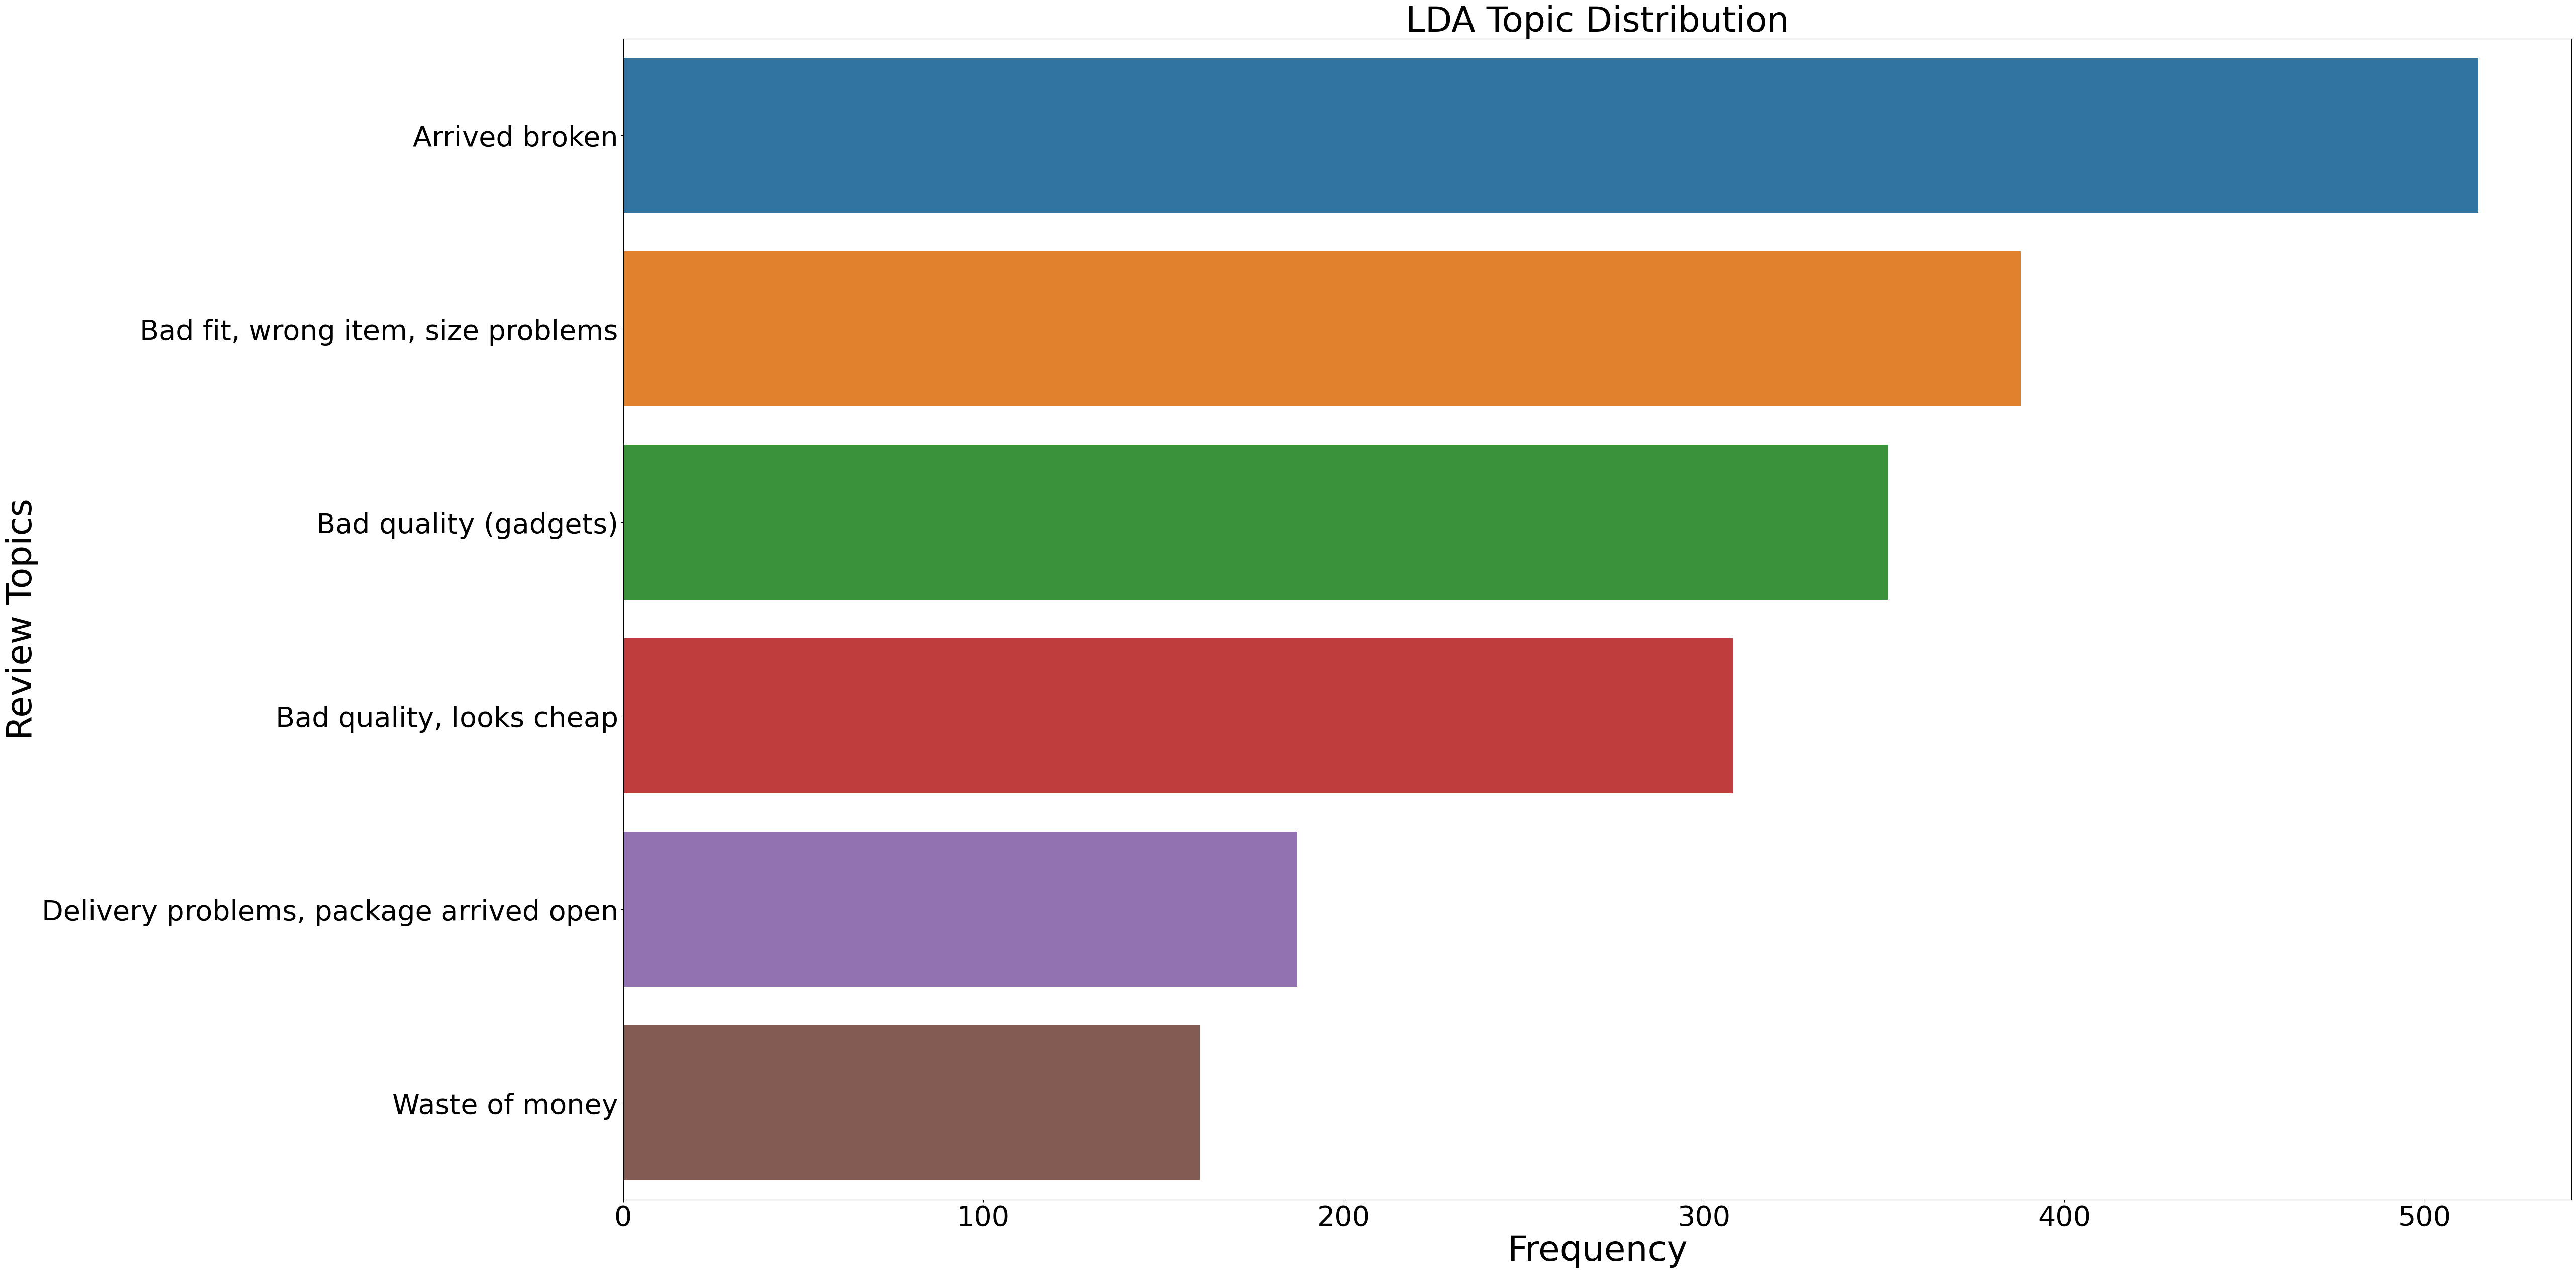

In [249]:
lda_x = return_data['lda_topics'].value_counts()
cat_counts = return_data['product_category'].value_counts()
plt.figure(figsize=(50,30))
sns.barplot(x=lda_x, y=lda_x.sort_index().index)
plt.title("LDA Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)
plt.show()


To gain even more insight, the returns are represented by topic and product category using a heatmap. First, the data is prepared for visualization.

In [243]:
topic_cat_counts = return_data.groupby(['lda_topics', 'product_category']).size().unstack().fillna(0)
topic_cat_counts

product_category                         apparel  home  wireless
lda_topics                                                      
Arrived broken                                39   102        46
Bad fit, wrong item, size problems           269    54        28
Bad quality (gadgets)                         47    74        39
Bad quality, looks cheap                     148   117        43
Delivery problems, package arrived open       95   127       166
Waste of money                                60   216       239

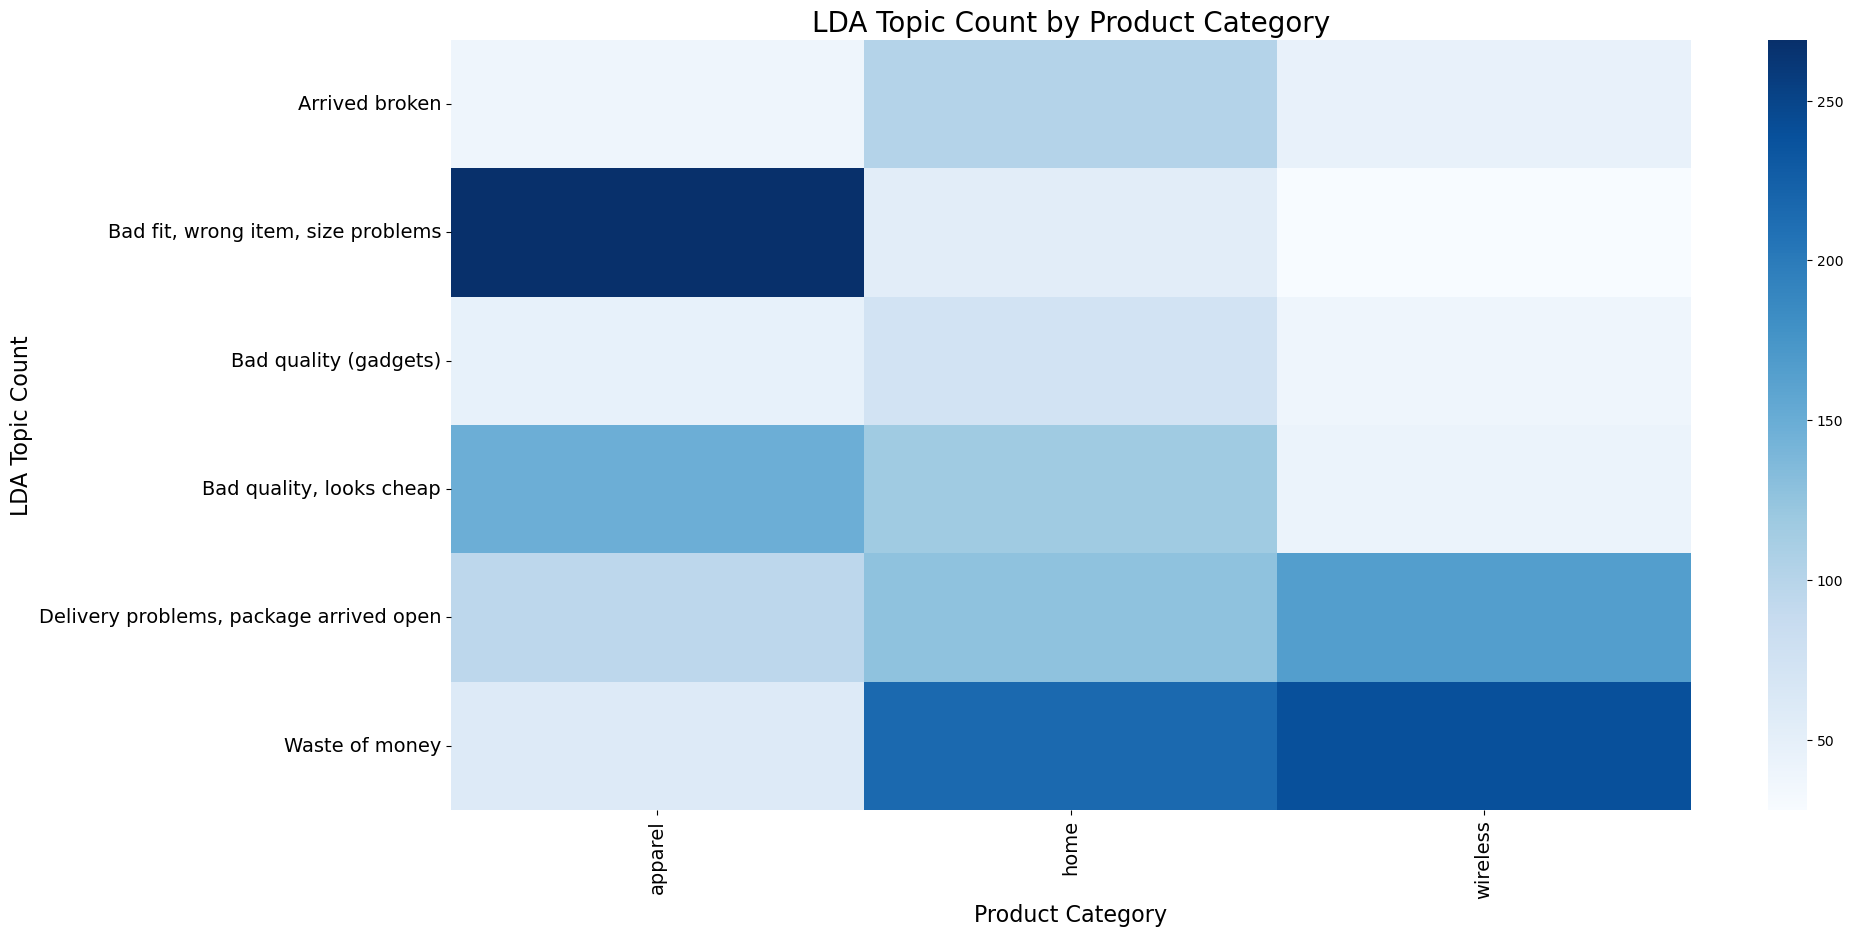

In [248]:
plt.figure(figsize=(20,10))
sns.heatmap(topic_cat_counts, cmap='Blues')
plt.title('LDA Topic Count by Product Category', fontsize=20)
plt.xlabel('Product Category', fontsize=16)
plt.ylabel('LDA Topic Count', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()


Saving the model:

In [230]:
#save the model for later since it takes a long time to fit:
filename = 'lda_model_final.sav'
pickle.dump(lda_model, open(filename, 'wb'))

Another interactive visualization tool is `pyLDAvis` <a href="#ref">(Sievert et al.)</a>. This is an interactive LDA visualization python library. This visualization provides a global view of the topics, their similarities and differences. At the same time, they provide an inspection of how the terms in each topics are distributed. In doing so, they propose the relevancy score for each word and each topic and thus help interpret the results of the LDA model. Unique topics are represented by circles, the size of the circle represents the importance of the topic. The distance between each circle represents how similar the topics are to each other. Selecting a topic/circle will reveal a horizontal bar chart displaying the 30 most relevant words for the topic along with the frequency of each word appearing in the topic and the overall corpus.


In [252]:
import gensim
import gensim.corpora as corpora
import gensim.matutils as matutils

# Converts the sparse matrix into a list of lists
texts = tf_vectorizer.inverse_transform(tf)
texts = [[word for word in doc if word] for doc in texts]

# Creates a gensim dictionary
id2word = corpora.Dictionary(texts)

# Convert the sparse matrix into a gensim corpus
corpus = matutils.Sparse2Corpus(tf, documents_columns=False)

In [253]:
# create a gensim LDA model
lda_model_gensim = gensim.models.ldamodel.LdaModel(corpus, num_topics=6, id2word=id2word)

# create a visualization using pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_model_gensim, corpus, id2word)
pyLDAvis.display(vis)


### Non-Negative Matrix Factorization with TF-IDF

In the last appraoch, a Non-Negative Matrix Factorization (NMF) is used <a href="#ref">(Lee et al.)</a>. NMF expresses documents as a combination of topics. This method is used as a dimensionality reduction approach (similar to PCA or SVD) and for topic extraction. Instead of using the simple CountVectorizer method  (as before) to vectorize the words/tokens, the TF-IDF method is used to bring down the weight/impact of high-frequency words. In TF-IDF, the meaning of each word is defined by a simple function of the counts of nearby words. `Max_df`=0.9 will remove words that appear in more than 90% of the reviews. `Min_df`=25 will remove words that appear in less than 25 reviews.

In [254]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(return_data['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

10        30  able  actually  ago  almost  already      also   amazon   
0     0.0  0.000000   0.0  0.232931  0.0     0.0      0.0  0.000000  0.00000  \
1     0.0  0.000000   0.0  0.000000  0.0     0.0      0.0  0.000000  0.00000   
2     0.0  0.000000   0.0  0.000000  0.0     0.0      0.0  0.000000  0.00000   
3     0.0  0.000000   0.0  0.000000  0.0     0.0      0.0  0.320534  0.00000   
4     0.0  0.000000   0.0  0.000000  0.0     0.0      0.0  0.000000  0.00000   
...   ...       ...   ...       ...  ...     ...      ...       ...      ...   
1904  0.0  0.210271   0.0  0.208345  0.0     0.0      0.0  0.000000  0.16162   
1905  0.0  0.000000   0.0  0.000000  0.0     0.0      0.0  0.000000  0.00000   
1906  0.0  0.000000   0.0  0.000000  0.0     0.0      0.0  0.000000  0.00000   
1907  0.0  0.000000   0.0  0.000000  0.0     0.0      0.0  0.000000  0.00000   
1908  0.0  0.000000   0.0  0.000000  0.0     0.0      0.0  0.000000  0.00000   

      another  ...      wish   within   without      work     worth     would   
0         0.0  ...  0.000000  0.00000  0.000000  0.408866  0.000000  0.000000  \
1         0.0  ...  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
2         0.0  ...  0.213146  0.00000  0.000000  0.000000  0.000000  0.115552   
3         0.0  ...  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
4         0.0  ...  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
...       ...  ...       ...      ...       ...       ...       ...       ...   
1904      0.0  ...  0.203868  0.00000  0.000000  0.000000  0.000000  0.000000   
1905      0.0  ...  0.000000  0.00000  0.140097  0.000000  0.124603  0.000000   
1906      0.0  ...  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
1907      0.0  ...  0.000000  0.54765  0.000000  0.000000  0.000000  0.000000   
1908      0.0  ...  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   

      wrong   xl  year    zipper  
0       0.0  0.0   0.0  0.000000  
1       0.0  0.0   0.0  0.000000  
2       0.0  0.0   0.0  0.000000  
3       0.0  0.0   0.0  0.000000  
4       0.0  0.0   0.0  0.000000  
...     ...  ...   ...       ...  
1904    0.0  0.0   0.0  0.000000  
1905    0.0  0.0   0.0  0.157488  
1906    0.0  0.0   0.0  0.000000  
1907    0.0  0.0   0.0  0.547650  
1908    0.0  0.0   0.0  0.000000  

[1909 rows x 302 columns]

In [255]:
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))

Continuing applying NMF.

In [256]:
nmf = NMF(n_components=6, random_state=0,  init='nndsvd', max_iter = 300).fit(tfidf) #alpha_H=.1,

In [257]:
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
like look cheap quality picture material make fit dress thin
Topic 1:
small size fit run large way order wear big xl
Topic 2:
work stop month buy one charger charge day window great
Topic 3:
star one two broken item give box fabric cheap well
Topic 4:
get item product receive order buy would use money time
Topic 5:
phone case charge screen fit protector use iphone button well


The results from NMF also hint at "looking cheap", the size being too "small" or "large", unreceived items or other problems during refund.

#### LDA for category "home"

In [ ]:
#subset home
return_data_home = return_data[return_data['product_category'].isin(['home'])]

rating   
41        1  \
240       1   
498       1   
518       1   
881       1   

                                                                                             review_body   
41   Submitted request to return for one that actually works, but I'm disappointed. This is brand new...  \
240  I ordered what I thought was a new gauge, instead I got one poor beaten up gauge. With no abilit...   
498                        Very cheap. Meant to return, but set them aside and forgot....too late now. 😝   
518  These kept falling apart, returned for full refund. The plastic handle reinforcements kept falli...   
881  Its very annoying when you search for the product you own and are looking for replacement filter...   

                                                  review_title   
41                                              Does not work!  \
240                                         Beaten up and used   
498                                           Looks very cheap   
518  Fall apart, returned for full refund. Thank you amazon :)   
881                What a waste of money and feeling deceived.   

    product_category   
41              home  \
240             home   
498             home   
518             home   
881             home   

                                                                                             no_contract   
41   [Submitted, request, to, return, for, one, that, actually, works,, but, I am, disappointed., Thi...  \
240  [I, ordered, what, I, thought, was, a, new, gauge,, instead, I, got, one, poor, beaten, up, gaug...   
498         [Very, cheap., Meant, to, return,, but, set, them, aside, and, forgot....too, late, now., 😝]   
518  [These, kept, falling, apart,, returned, for, full, refund., The, plastic, handle, reinforcement...   
881  [Its, very, annoying, when, you, search, for, the, product, you, own, and, are, looking, for, re...   

                                                                                         review_body_str   
41   Submitted request to return for one that actually works, but I am disappointed. This is brand ne...  \
240  I ordered what I thought was a new gauge, instead I got one poor beaten up gauge. With no abilit...   
498                        Very cheap. Meant to return, but set them aside and forgot....too late now. 😝   
518  These kept falling apart, returned for full refund. The plastic handle reinforcements kept falli...   
881  Its very annoying when you search for the product you own and are looking for replacement filter...   

                                                                                               tokenized   
41   [Submitted, request, to, return, for, one, that, actually, works, ,, but, I, am, disappointed, ....  \
240  [I, ordered, what, I, thought, was, a, new, gauge, ,, instead, I, got, one, poor, beaten, up, ga...   
498  [Very, cheap, ., Meant, to, return, ,, but, set, them, aside, and, forgot, ...., too, late, now,...   
518  [These, kept, falling, apart, ,, returned, for, full, refund, ., The, plastic, handle, reinforce...   
881  [Its, very, annoying, when, you, search, for, the, product, you, own, and, are, looking, for, re...   

                                                                                                   lower   
41   [submitted, request, to, return, for, one, that, actually, works, ,, but, i, am, disappointed, ....  \
240  [i, ordered, what, i, thought, was, a, new, gauge, ,, instead, i, got, one, poor, beaten, up, ga...   
498  [very, cheap, ., meant, to, return, ,, but, set, them, aside, and, forgot, ...., too, late, now,...   
518  [these, kept, falling, apart, ,, returned, for, full, refund, ., the, plastic, handle, reinforce...   
881  [its, very, annoying, when, you, search, for, the, product, you, own, and, are, looking, for, re...   

                                                                                                 no_punc   
41   [submitted, re

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf_home = tf_vectorizer.fit_transform(return_data_home['lemma_str'].values.astype('U'))
tf_feature_names_home = tf_vectorizer.get_feature_names_out()
doc_term_matrix_home = pd.DataFrame(tf_home.toarray(), columns=list(tf_feature_names_home))

In [ ]:
lda_model_home = LatentDirichletAllocation(n_components=6, learning_method='online', max_iter=500, random_state=0).fit(tf_home)
no_top_words = 10

In [ ]:
display_topics(lda_model_home, tf_feature_names_home, no_top_words)

Topic 0:
use money product window go make week back waste put
Topic 1:
like look cheap pillow picture color pay feel price quality
Topic 2:
piece fit size set small really good use purchase well
Topic 3:
one work buy give would box get quality well even
Topic 4:
order item arrive would receive seller say send never amazon
Topic 5:
product get work one would day amazon first pillow month


In [258]:
# identify broken products
search_for = ["break", "broken", "broke"]
broken_data = subset_rate12[df["lemma_str"].str.contains('|'.join(search_for))]
broken_data.shape

/var/folders/22/03qv3nfd1130w7gzh55r_x2r0000gn/T/ipykernel_3070/2520238772.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



(1474, 15)

In [259]:
broken_data.product_category.value_counts()

product_category
wireless    767
home        549
apparel     158
Name: count, dtype: int64

In [278]:
broken_data.head()

rating   
116       2  \
120       1   
562       1   
597       1   
667       2   

                                                                                             review_body   
116  At 1st I was very happy with the product But given just a little bit of time my Side holster bro...  \
120  The Ring broke off less than 3 weeks after purchasing. It was cute, but clearly made very cheap....   
562  It is metal. There is a felt-like material covering the metal that breaks off exposing the rust ...   
597  A piece of Chinese junk, it snapped and broke the center of the grate with he first fire I start...   
667  Sorry, IThe adhesive is too strong. I wripped the back off my remote trying to move it to anothe...   

                            review_title product_category   
116             Some durability problems         wireless  \
120            Didn't even last a MONTH!         wireless   
562                          Rusty metal          apparel   
597                   Cheap Chinese junk             home   
667  Adhesion too strong for regular use         wireless   

                                                                                             review_full   
116  Some durability problems At 1st I was very happy with the product But given just a little bit of...  \
120  Didn't even last a MONTH! The Ring broke off less than 3 weeks after purchasing. It was cute, bu...   
562  Rusty metal It is metal. There is a felt-like material covering the metal that breaks off exposi...   
597  Cheap Chinese junk A piece of Chinese junk, it snapped and broke the center of the grate with he...   
667  Adhesion too strong for regular use Sorry, IThe adhesive is too strong. I wripped the back off m...   

                                                                                             no_contract   
116  [Some, durability, problems, At, 1st, I, was, very, happy, with, the, product, But, given, just,...  \
120  [Did not, even, last, a, MONTH!, The, Ring, broke, off, less, than, 3, weeks, after, purchasing....   
562  [Rusty, metal, It, is, metal., There, is, a, felt-like, material, covering, the, metal, that, br...   
597  [Cheap, Chinese, junk, A, piece, of, Chinese, junk,, it, snapped, and, broke, the, center, of, t...   
667  [Adhesion, too, strong, for, regular, use, Sorry,, IThe, adhesive, is, too, strong., I, wripped,...   

                                                                                         review_body_str   
116  Some durability problems At 1st I was very happy with the product But given just a little bit of...  \
120  Did not even last a MONTH! The Ring broke off less than 3 weeks after purchasing. It was cute, b...   
562  Rusty metal It is metal. There is a felt-like material covering the metal that breaks off exposi...   
597  Cheap Chinese junk A piece of Chinese junk, it snapped and broke the center of the grate with he...   
667  Adhesion too strong for regular use Sorry, IThe adhesive is too strong. I wripped the back off m...   

                                                                                               tokenized   
116  [Some, durability, problems, At, 1st, I, was, very, happy, with, the, product, But, given, just,...  \
120  [Did, not, even, last, a, MONTH, !, The, Ring, broke, off, less, than, 3, weeks, after, purchasi...   
562  [Rusty, metal, It, is, metal, ., There, is, a, felt-like, material, covering, the, metal, that, ...   
597  [Cheap, Chinese, junk, A, piece, of, Chinese, junk, ,, it, snapped, and, broke, the, center, of,...   
667  [Adhesion, too, strong, for, regular, use, Sorry, ,, IThe, adhesive, is, too, strong, ., I, wrip...   

                                                                                                   lower   
116  [some, durability, problems, at, 1st, i, was, very, happy, with, the, product, but, given, just,...  \
120  [did, not, even, last, a, month, !, the, ring, broke, off, less, than, 3, weeks, 

It seems like the most frequently broken products are from the wireless category.

In order to understand which products get broken most, the "broken_data" dataset is merged with the initial dataset to retrieve the product IDs of interest.

In [264]:
broken_indices = broken_data.index.tolist()

merged_data = pd.merge(df_train.loc[broken_indices], pd.DataFrame({'index': broken_indices}), left_index=True, right_index=True)

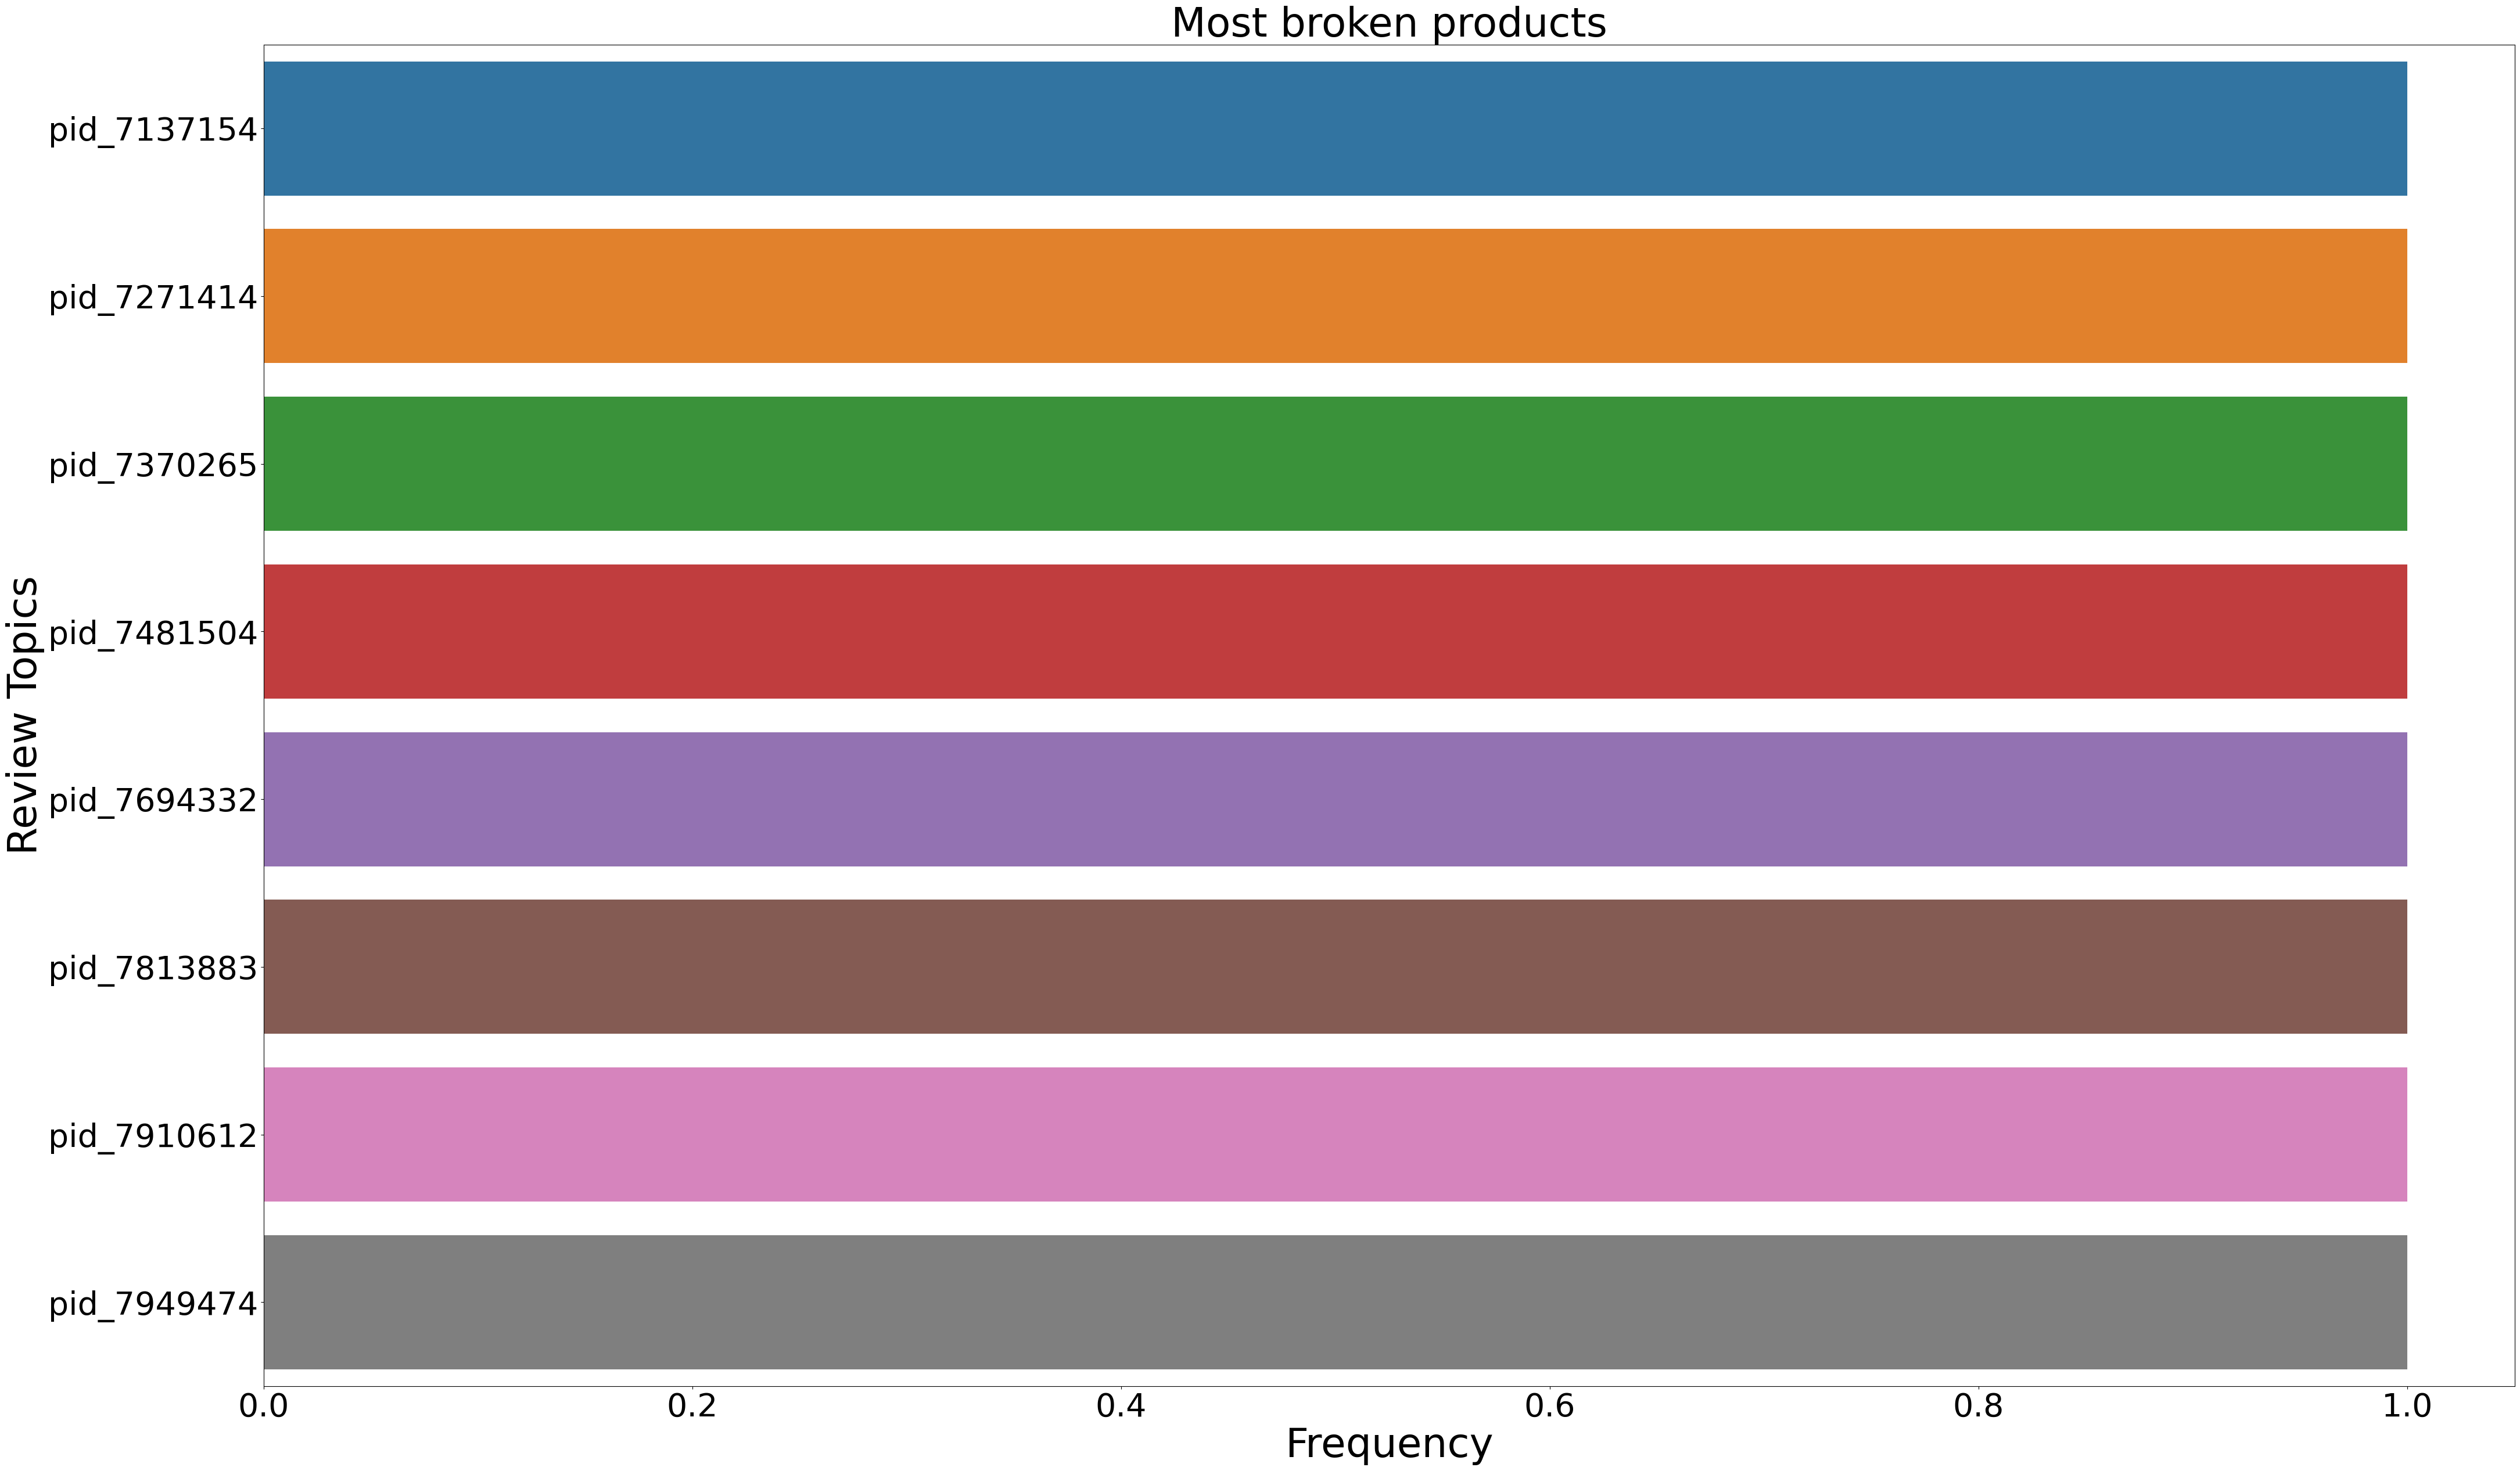

In [272]:
x = merged_data['product_id'].value_counts()
plt.figure(figsize=(50,30))
sns.barplot(x=x, y=x.sort_index().index)
plt.title("Broken products id's", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)
plt.show()


There seems to be only one broken product for each type of product. Further inspection will be conducted.

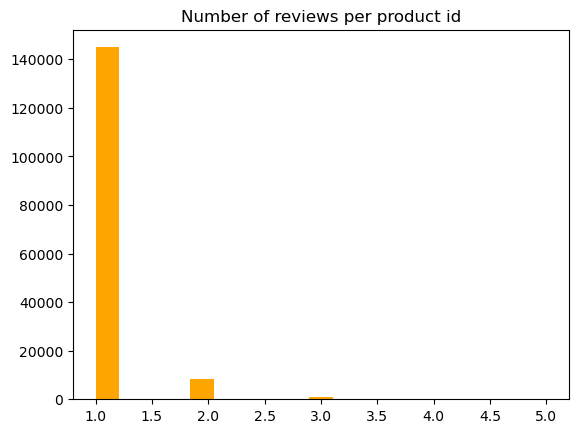

In [277]:
c = df_train.product_id.value_counts()
a = np.hstack(c)
_ = plt.hist(a, bins='auto', color="orange")  # arguments are passed to np.histogram
plt.title("Number of reviews per product id")
plt.show()

Most products were only reviewed once. This does not provide much insight.

### Recommendations to increase costumer satisfaction and decrease returns:
- Improving product quality, to the point where they do not break too quickly, should be a company priority (see LDA).
- Order detail verification (particularly product size) should be performed with more care; an improvement which could have a high impact on customer reviews and sales at a low cost to the company.
- Providing thorough and precise product description could help decrease returns. 
- Packaging improvement could help avoid products arriving open. 
- Working on delivery and distribution center issues is also advisable.

<h2 id="ref">References</h2>

Blei, D.M., Ng A.Y., Jordan, M.I. (2003). Latent Dirichlet allocation. JMLR, 3(5):993-1022.

Jurafsky, D., James H. M. (2023). Speech and Language Processing (3rd ed. draft), available <a href="https://web.stanford.edu/~jurafsky/slp3/">here.</a>

Kim, Y., Levy, J., & Liu, Y. (2020). Speech sentiment and customer satisfaction estimation in socialbot conversations. arXiv preprint arXiv:2008.12376.

Lee, D.D., Seung, H.S. (1999). Learning the parts of objects by non-negative matrix factorization. Nature, 401(6755):788-791.

Sievert, C., Shirley, K. LDAvis: A method for visualizing and interpreting topics <a href="https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf">available here</a>.